
            data = tf.concat([data, hand_bone, pose_bone, padded_velocity_data, padded_acceleration_data], axis=1)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

2023-05-01 11:17:22.909336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 11:17:23.137599: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 11:17:23.808120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-01 11:17:23.808234: W tensorflow/

Tensorflow V2.11.0
Keras V2.11.0
Python V3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


In [2]:
from datetime import datetime, timezone, timedelta

tz_jst = timezone(timedelta(hours=9))
train_start_time = datetime.now(tz=tz_jst).strftime('%Y%m%d_%H%M')

suffix = "_alldata"
preffix = "exp23_aug_largemodel_input32_block2_"

out_root = "./models/" + "training_" + preffix + train_start_time + suffix + "/"
out_root
os.makedirs(out_root, exist_ok=True)

In [3]:
import logging

def setLogger(output_path):
    logging_outfile = output_path + "/logger.log"
    logging.basicConfig(
        level=logging.INFO,
        format="[%(asctime)s][%(name)s][%(funcName)s][%(levelname)s] %(message)s",
        filename=str(logging_outfile),
        filemode="w"
    )
    logger = logging.getLogger(__name__)
    #logger.setLevel(logging.DEBUG)

    ## sets up stream handler
    shandler = logging.StreamHandler()
    shandler.setLevel(logging.INFO)

    ## sets up formatter
    formatter = logging.Formatter("[%(asctime)s][%(name)s][%(funcName)s][%(levelname)s] %(message)s")
    shandler.setFormatter(formatter)

    ## adds handlers to logger
    logger.addHandler(shandler)
    return logger

logger = setLogger(out_root)


class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TrainingLogger, self).__init__()

    def on_epoch_end(self, epoch, logs: dict = None):
        logger.info(f'Epoch {(epoch + 1):05d}')

        max_len = max([len(key) for key in logs.keys()])
        for key, value in logs.items():
            message = f'{key:>{max_len + 1}}: {value:.5f}'
            logger.info(message)
    
    
traininglogger = TrainingLogger()

# Plot Config

In [4]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [5]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# False: use 10% of participants as validation set
# True: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 4949
NUM_CLASSES = 250
# IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 
IS_INTERACTIVE=False

INPUT_SIZE = 32

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

In [6]:
config = {
    'preprocess_data': PREPROCESS_DATA,
    'train_model': TRAIN_MODEL,
    'use_val': USE_VAL,
    'n_rows': N_ROWS,
    'n_dims': N_DIMS,
    'dim_names': DIM_NAMES,
    'seed': SEED,
    'num_classes': NUM_CLASSES,
    'verbose': VERBOSE,
    'is_interactive': IS_INTERACTIVE,
    'input_size': INPUT_SIZE,
    'batch_all_signs_n': BATCH_ALL_SIGNS_N,
    'batch_size': BATCH_SIZE,
    'n_epochs': N_EPOCHS,
    'lr_max': LR_MAX,
    'n_warmup_epochs': N_WARMUP_EPOCHS,
    'wd_ratio': WD_RATIO,
    'mask_val': MASK_VAL
}

# Utils

In [7]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        logger.info(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [8]:
# Read Training Data
# if IS_INTERACTIVE or not PREPROCESS_DATA:
#     train = pd.read_csv('/home/jovyan/pvc-nfs-skobayashi/competition/kaggle/2023_kaggle_gislr/data/kaggle/train.csv').sample(int(5e3), random_state=SEED)
# else:
train = pd.read_csv('./processed_data/base_fix_32/train.csv')

N_SAMPLES = len(train)
logger.info(f'N_SAMPLES: {N_SAMPLES}')

[2023-05-01 11:17:26,174][__main__][<module>][INFO] N_SAMPLES: 94477


# Add File Path

In [9]:
# Get complete file path to file
def get_file_path(path):
    return f'data/distributed/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [10]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [11]:
display(train.head(30))
display(train.info())

,Unnamed: 0,path,participant_id,sequence_id,sign,sign_ord,valid,file_path
0,0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,False,data/distributed/train_landmark_files/26734/10...
1,1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,False,data/distributed/train_landmark_files/28656/10...
2,2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,False,data/distributed/train_landmark_files/16069/10...
3,3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,False,data/distributed/train_landmark_files/25571/10...
4,4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,True,data/distributed/train_landmark_files/62590/10...
5,5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,67,False,data/distributed/train_landmark_files/26734/10...
6,6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy,143,False,data/distributed/train_landmark_files/26734/10...
7,7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips,134,False,data/distributed/train_landmark_files/32319/10...
8,8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower,86,False,data/distributed/train_landmark_files/37055/10...
9,9,train_landmark_files/29302/100039661.parquet,29302,100039661,time,220,True,data/distributed/train_landmark_files/29302/10...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      94477 non-null  int64 
 1   path            94477 non-null  object
 2   participant_id  94477 non-null  int64 
 3   sequence_id     94477 non-null  int64 
 4   sign            94477 non-null  object
 5   sign_ord        94477 non-null  int16 
 6   valid           94477 non-null  bool  
 7   file_path       94477 non-null  object
dtypes: bool(1), int16(1), int64(3), object(3)
memory usage: 4.6+ MB


None

# Landmark Indices

In [12]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
LEYE_IDXS0 = np.array([
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
    ])
REYE_IDXS0 = np.array([
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([500, 502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([501, 503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0, LEYE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0, REYE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS  = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()
EYE_IDXS        = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEYE_IDXS0)).squeeze()

POSELEN = N_COLS
print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 83


In [13]:
# Bone indices
#LEFT_HAND_BONE_IDXS0 = np.array([[0, 1], [0, 5], [0, 17], [1, 2], [2, 3], [3, 4], [5, 6], [5, 9], [6, 7], [7, 8], [9, 10], [9, 13], [10, 11], [11, 12], [13, 14], [13, 17], [14, 15], [15, 16], [17, 18], [18, 19], [19, 20]])
LEFT_HAND_BONE_IDXS0 = np.array([[468, 469], [468, 473], [468, 485], [469, 470], [470, 471], [471, 472], [473, 474], [473, 477], [474, 475], [475, 476], 
                                 [477, 478], [477, 481], [478, 479], [479, 480], [481, 482], [481, 485], [482, 483], [483, 484], [485, 486], [486, 487], [487, 488]])
RIGHT_HAND_BONE_IDXS0 = np.array([[522, 523], [522, 527], [522, 539], [523, 524], [524, 525], [525, 526], [527, 528], [527, 531], [528, 529], [529, 530], 
                                  [531, 532], [531, 535], [532, 533], [533, 534], [535, 536], [535, 539], [536, 537], [537, 538], [539, 540], [540, 541], [541, 542]])
LEFT_POSE_BONE_IDXS0 = np.array([[500, 502], [502, 504], [504, 506], [504, 508], [504, 510], [506, 508]])
RIGHT_POSE_BONE_IDXS0 = np.array([[501, 503], [503, 505], [505, 507], [505, 509], [505, 511], [507, 509]])

LEFT_HAND_BONE_0 = LEFT_HAND_BONE_IDXS0[:, 0]
LEFT_HAND_BONE_1 = LEFT_HAND_BONE_IDXS0[:, 1]
RIGHT_HAND_BONE_0 = RIGHT_HAND_BONE_IDXS0[:, 0]
RIGHT_HAND_BONE_1 = RIGHT_HAND_BONE_IDXS0[:, 1]
LEFT_POSE_BONE_0 = LEFT_POSE_BONE_IDXS0[:, 0]
LEFT_POSE_BONE_1 = LEFT_POSE_BONE_IDXS0[:, 1]
RIGHT_POSE_BONE_0 = RIGHT_POSE_BONE_IDXS0[:, 0]
RIGHT_POSE_BONE_1 = RIGHT_POSE_BONE_IDXS0[:, 1]

LEFT_HAND_BONE_IDXS = np.arange(LANDMARK_IDXS_LEFT_DOMINANT0.size, LANDMARK_IDXS_LEFT_DOMINANT0.size + len(LEFT_HAND_BONE_IDXS0))
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size + len(LEFT_HAND_BONE_IDXS0)
LEFT_POSE_BONE_IDXS = np.arange(N_COLS, N_COLS + len(LEFT_POSE_BONE_IDXS0))
N_COLS = N_COLS + len(LEFT_POSE_BONE_IDXS0)
print(f'# HAND_IDXS: {len(HAND_IDXS)}, POSE_IDXS: {len(POSE_IDXS)}, LIPS_IDXS: {len(LIPS_IDXS)}, HAND_BONE_IDXS: {len(LEFT_HAND_BONE_IDXS)}, POSE_BONE_IDXS: {len(LEFT_POSE_BONE_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, POSE_IDXS: 6, LIPS_IDXS: 40, HAND_BONE_IDXS: 21, POSE_BONE_IDXS: 6, N_COLS: 110


In [14]:
# motion (verocity and acceraration)
# data = tf.concat([data, hand_bone, pose_bone, padded_velocity_data, padded_acceleration_data], axis=1)

# LIPS_IDXS自体が配列。なのでこの書き方でOKです。。。

OFFCET = N_COLS

LIPS_VEL_IDXS       = LIPS_IDXS      + OFFCET
LEFT_VEL_HAND_IDXS  = LEFT_HAND_IDXS + OFFCET
RIGHT_VEL_HAND_IDXS = RIGHT_HAND_IDXS+ OFFCET
HAND_VEL_IDXS       = HAND_IDXS      + OFFCET
POSE_VEL_IDXS       = POSE_IDXS      + OFFCET

LIPS_ACC_IDXS       = LIPS_IDXS      + POSELEN + OFFCET
LEFT_ACC_HAND_IDXS  = LEFT_HAND_IDXS + POSELEN + OFFCET
RIGHT_ACC_HAND_IDXS = RIGHT_HAND_IDXS+ POSELEN + OFFCET
HAND_ACC_IDXS       = HAND_IDXS      + POSELEN + OFFCET
POSE_ACC_IDXS       = POSE_IDXS      + POSELEN + OFFCET


#########################
N_COLS  =  N_COLS + POSELEN + POSELEN
OFFSET2 = N_COLS

In [15]:
# padded_hand_relative_angles_velocity_data, padded_pose_relative_angles_velocity_data
HAND_JNT_DIST_IDXS       = np.arange(N_COLS, N_COLS + len(RIGHT_HAND_BONE_IDXS0))
N_COLS = N_COLS + HAND_JNT_DIST_IDXS.size

HAND_REL_ANG_IDXS        = np.arange(N_COLS, N_COLS + (len(RIGHT_HAND_BONE_IDXS0) -1 ))
N_COLS = N_COLS + HAND_REL_ANG_IDXS.size

POSE_JNT_DIST_IDXS       = np.arange(N_COLS, N_COLS + len(LEFT_POSE_BONE_IDXS0))
N_COLS = N_COLS + POSE_JNT_DIST_IDXS.size

POSE_REL_ANG_IDXS        = np.arange(N_COLS, N_COLS + (len(LEFT_POSE_BONE_IDXS0) -1))
N_COLS = N_COLS + POSE_REL_ANG_IDXS.size

HAND_REL_ANG_VEL_IDXS    = np.arange(N_COLS, N_COLS + (len(RIGHT_HAND_BONE_IDXS0) -1 ))
N_COLS = N_COLS + HAND_REL_ANG_VEL_IDXS.size

POSE_REL_ANG_VEL_IDXS    = np.arange(N_COLS, N_COLS + (len(LEFT_POSE_BONE_IDXS0) -1))
N_COLS = N_COLS + POSE_REL_ANG_VEL_IDXS.size


In [16]:
LEFT_HAND_SHAPE_IDXS0 = np.array([[470, 485], [472, 476], [476, 480], [480, 484], [484, 488],
                                 [468, 472], [468, 476], [468, 480], [468, 484], [468, 488], [472, 485]])
RIGHT_HAND_SHAPE_IDXS0 = np.array([[524, 539], [526, 530], [530, 534], [534, 538], [538, 542],
                                  [522, 526], [522, 530], [522, 534], [522, 538], [522, 542], [526, 539]])

LEFT_POSE_SHAPE_IDXS0 = np.array([[500, 504], [504, 512], [504, 501], [504, 513]])
RIGHT_POSE_SHAPE_IDXS0 = np.array([[501, 505], [505, 513], [505, 500], [505, 512]])

LEFT_HAND_SHAPE_IDXS = np.arange(N_COLS, N_COLS + len(LEFT_HAND_SHAPE_IDXS0))
N_COLS = N_COLS + len(LEFT_HAND_SHAPE_IDXS)
LEFT_POSE_SHAPE_IDXS = np.arange(N_COLS, N_COLS + len(LEFT_POSE_SHAPE_IDXS0))
N_COLS = N_COLS + len(LEFT_POSE_SHAPE_IDXS)



In [17]:
N_COLS

368

In [18]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

logger.info(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

[2023-05-01 11:17:26,463][__main__][<module>][INFO] LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [19]:
# Bone
HAND_BONE_START = POSE_START + POSE_IDXS.size
POSE_BONE_START = HAND_BONE_START + LEFT_HAND_BONE_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}, HAND_BONE_START: {HAND_BONE_START}, POSE_BONE_START: {POSE_BONE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61, HAND_BONE_START: 67, POSE_BONE_START: 88


In [20]:
#vel and acc start
LIPS_VEL_START = OFFCET
LEFT_VEL_HAND_START  = LIPS_VEL_START + LIPS_IDXS.size
RIGHT_VEL_HAND_START = LEFT_VEL_HAND_START + LEFT_HAND_IDXS.size
POSE_VEL_START       = RIGHT_VEL_HAND_START + RIGHT_HAND_IDXS.size

LIPS_ACC_START = POSE_VEL_START + POSE_IDXS.size
LEFT_ACC_HAND_START  = LIPS_ACC_START + LIPS_IDXS.size
RIGHT_ACC_HAND_START = LEFT_ACC_HAND_START + LEFT_HAND_IDXS.size
POSE_ACC_START       = RIGHT_ACC_HAND_START + RIGHT_HAND_IDXS.size


print(LIPS_VEL_START, LEFT_VEL_HAND_START, RIGHT_VEL_HAND_START, POSE_VEL_START, LIPS_ACC_START, LEFT_ACC_HAND_START, RIGHT_ACC_HAND_START, POSE_ACC_START)


110 150 171 171 177 217 238 238


In [21]:
#vel and acc start
HAND_JNT_DIST_START    = OFFSET2
HAND_REL_ANG_START     = HAND_JNT_DIST_START + HAND_JNT_DIST_IDXS.size
POSE_JNT_DIST_START    = HAND_REL_ANG_START + HAND_REL_ANG_IDXS.size
POSE_REL_ANG_START     = POSE_JNT_DIST_START + POSE_JNT_DIST_IDXS.size

HAND_REL_ANG_VEL_START = POSE_REL_ANG_START + POSE_REL_ANG_IDXS.size
POSE_REL_ANG_VEL_START = HAND_REL_ANG_VEL_START + HAND_REL_ANG_VEL_IDXS.size

In [22]:
print(HAND_JNT_DIST_START   ,HAND_REL_ANG_START    ,POSE_JNT_DIST_START   ,POSE_REL_ANG_START    ,HAND_REL_ANG_VEL_START,POSE_REL_ANG_VEL_START)

276 297 317 323 328 348


In [23]:
HAND_SHAPE_START = POSE_REL_ANG_VEL_START + POSE_REL_ANG_VEL_IDXS.size
POSE_SHAPE_START = HAND_SHAPE_START + LEFT_HAND_SHAPE_IDXS.size

print(HAND_SHAPE_START)

353


In [24]:
POSE_OFFSET = START_IDX+21

In [25]:
config.update({
    'use_types': USE_TYPES,
    'start_idx': START_IDX,
    'lips_idxs0': LIPS_IDXS0,
    'left_hand_idxs0': LEFT_HAND_IDXS0,
    'right_hand_idxs0': RIGHT_HAND_IDXS0,
    'left_pose_idxs0': LEFT_POSE_IDXS0,
    'right_pose_idxs0': RIGHT_POSE_IDXS0,
    'landmark_idxs_left_dominant0': LANDMARK_IDXS_LEFT_DOMINANT0,
    'landmark_idxs_right_dominant0': LANDMARK_IDXS_RIGHT_DOMINANT0,
    'hand_idxs0': HAND_IDXS0,
    'n_cols': N_COLS,
    'lips_idxs': LIPS_IDXS,
    'left_hand_idxs': LEFT_HAND_IDXS,
    'right_hand_idxs': RIGHT_HAND_IDXS,
    'hand_idxs': HAND_IDXS,
    'pose_idxs': POSE_IDXS
})

# Process Data Tensorflow

In [26]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [27]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
def tf_acos(x):
    negate = tf.cast(x < 0, dtype=tf.float32)
    x = tf.abs(x)
    ret = tf.constant(-0.0187293, dtype=tf.float32)
    ret = ret * x
    ret = ret + tf.constant(0.0742610, dtype=tf.float32)
    ret = ret * x
    ret = ret - tf.constant(0.2121144, dtype=tf.float32)
    ret = ret * x
    ret = ret + tf.constant(1.5707288, dtype=tf.float32)
    ret = ret * tf.sqrt(1.0 - x)
    ret = ret - 2 * negate * ret
    return negate * tf.constant(3.14159265358979, dtype=tf.float32) + ret

def angle_between_vectors_tf(v1, v2):
    cos_theta = tf.math.divide_no_nan(tf.einsum('ij,ij->i', v1, v2),
                                      (tf.norm(v1, axis=-1) * tf.norm(v2, axis=-1)))
    return tf_acos(tf.clip_by_value(cos_theta, -1, 1))

class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS) + [0] * len(EYE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1, 0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # normalize points
        pose_center = (data0[:, POSE_OFFSET+11, :] + data0[:, POSE_OFFSET+12, :])/2
        pose_center = tf.reshape(pose_center, [-1, 1, pose_center.shape[1]])
        data0 = data0 - pose_center
        
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            #######################################
            # bone
            #######################################
            hand_bone = tf.expand_dims(data[:, LEFT_HAND_BONE_IDXS0[0][1]] - data[:, LEFT_HAND_BONE_IDXS0[0][0]], axis=1)
            for i in range(1, len(LEFT_HAND_BONE_IDXS0)):
                hand_bone = tf.concat([hand_bone, tf.expand_dims(data[:, LEFT_HAND_BONE_IDXS0[i][1]] - data[:, LEFT_HAND_BONE_IDXS0[i][0]], axis=1)], axis=1)
                
            pose_bone = tf.expand_dims(data[:, LEFT_POSE_BONE_IDXS0[0][1]] - data[:, LEFT_POSE_BONE_IDXS0[0][0]], axis=1)
            for i in range(1, len(LEFT_POSE_BONE_IDXS0)):
                pose_bone = tf.concat([pose_bone, tf.expand_dims(data[:, LEFT_POSE_BONE_IDXS0[i][1]] - data[:, LEFT_POSE_BONE_IDXS0[i][0]], axis=1)], axis=1)
            
            hand_shape = tf.expand_dims(data[:, LEFT_HAND_SHAPE_IDXS0[0][1]] - data[:, LEFT_HAND_SHAPE_IDXS0[0][0]], axis=1)
            for i in range(1, len(LEFT_HAND_SHAPE_IDXS0)):
                hand_shape = tf.concat([hand_shape, tf.expand_dims(data[:, LEFT_HAND_SHAPE_IDXS0[i][1]] - data[:, LEFT_HAND_SHAPE_IDXS0[i][0]], axis=1)], axis=1)
                
            pose_shape = tf.expand_dims(data[:, LEFT_POSE_SHAPE_IDXS0[0][1]] - data[:, LEFT_POSE_SHAPE_IDXS0[0][0]], axis=1)
            for i in range(1, len(LEFT_POSE_SHAPE_IDXS0)):
                pose_shape = tf.concat([pose_shape, tf.expand_dims(data[:, LEFT_POSE_SHAPE_IDXS0[i][1]] - data[:, LEFT_POSE_SHAPE_IDXS0[i][0]], axis=1)], axis=1)

            #######################################
            # distance, angle, 
            #######################################
            # drop Z...?   
            # hand ----------
            # dist
            pose_data = data
            hand_joint_distances = []
            for i, j in LEFT_HAND_BONE_IDXS0:
                hand_joint_distances.append(tf.norm(pose_data[:, i] - pose_data[:, j], axis=-1))
            hand_joint_distances = tf.stack(hand_joint_distances, axis=-1)
            hand_joint_distances = tf.expand_dims(hand_joint_distances, axis=-1) # [163, 33, 1]にする
            hand_joint_distances = tf.tile(hand_joint_distances, [1, 1, 3]) # [163, 33, 3]にする
            
            # angle
            hand_relative_angles = []
            for (i1, j1), (i2, j2) in zip(LEFT_HAND_BONE_IDXS0[:-1], LEFT_HAND_BONE_IDXS0[1:]):
                v1 = pose_data[:, i1] - pose_data[:, j1]
                v2 = pose_data[:, i2] - pose_data[:, j2]

                hand_relative_angles.append(angle_between_vectors_tf(v1, v2))
            hand_relative_angles = tf.stack(hand_relative_angles, axis=-1)
            hand_relative_angles = tf.expand_dims(hand_relative_angles, axis=-1) # [163, 33, 1]にする
            hand_relative_angles = tf.tile(hand_relative_angles, [1, 1, 3]) # [163, 33, 3]にする            
            
            # body ----------
            # dist
            pose_data = data
            pose_joint_distances = []
            for i, j in LEFT_POSE_BONE_IDXS0:
                pose_joint_distances.append(tf.norm(pose_data[:, i] - pose_data[:, j], axis=-1))
            pose_joint_distances = tf.stack(pose_joint_distances, axis=-1)
            pose_joint_distances = tf.expand_dims(pose_joint_distances, axis=-1) # [163, 33, 1]にする
            pose_joint_distances = tf.tile(pose_joint_distances, [1, 1, 3]) # [163, 33, 3]にする         
            
            # angle
            pose_relative_angles = []
            for (i1, j1), (i2, j2) in zip(LEFT_POSE_BONE_IDXS0[:-1], LEFT_POSE_BONE_IDXS0[1:]):
                v1 = pose_data[:, i1] - pose_data[:, j1]
                v2 = pose_data[:, i2] - pose_data[:, j2]

                pose_relative_angles.append(angle_between_vectors_tf(v1, v2))
            pose_relative_angles = tf.stack(pose_relative_angles, axis=-1)    
            pose_relative_angles = tf.expand_dims(pose_relative_angles, axis=-1) # [163, 33, 1]にする
            pose_relative_angles = tf.tile(pose_relative_angles, [1, 1, 3]) # [163, 33, 3]にする     

            #######################################
            # angle motion
            #######################################
            if N_FRAMES > 1:
                padded_hand_relative_angles_velocity_data = tf.pad(hand_relative_angles[1:] - hand_relative_angles[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_hand_relative_angles_velocity_data = tf.zeros_like(hand_relative_angles)
            
            if N_FRAMES > 1:
                padded_pose_relative_angles_velocity_data = tf.pad(pose_relative_angles[1:] - pose_relative_angles[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_pose_relative_angles_velocity_data = tf.zeros_like(pose_relative_angles)
               
            #######################################
            # pose 実行順番に注意。ここでdataが削減されます。
            #######################################
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
            
            #######################################
            # motion
            #######################################
            if N_FRAMES > 1:
                padded_velocity_data = tf.pad(data[1:] - data[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_velocity_data = tf.zeros_like(data)
                
            #######################################
            # acceraration
            #######################################
            if N_FRAMES > 2:
                acceleration_data = (data[1:] - data[:-1])[1:] - (data[1:] - data[:-1])[:-1]
                padded_acceleration_data = tf.pad(acceleration_data, [[0, 2], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_acceleration_data = tf.zeros_like(data)  
                

            
            #######################################
            # concat
            #######################################
            data = tf.concat([data,
                              hand_bone, pose_bone, 
                              padded_velocity_data, padded_acceleration_data, 
                              hand_joint_distances, hand_relative_angles, 
                              pose_joint_distances, pose_relative_angles, 
                              padded_hand_relative_angles_velocity_data, 
                              padded_pose_relative_angles_velocity_data,
                             hand_shape, pose_shape
                             ], axis=1)
            
        else:
            #######################################
            # bone
            #######################################
            hand_bone = tf.expand_dims(data[:, RIGHT_HAND_BONE_IDXS0[0][1]] - data[:, RIGHT_HAND_BONE_IDXS0[0][0]], axis=1)
            for i in range(1, len(RIGHT_HAND_BONE_IDXS0)):
                hand_bone = tf.concat([hand_bone, tf.expand_dims(data[:, RIGHT_HAND_BONE_IDXS0[i][1]] - data[:, RIGHT_HAND_BONE_IDXS0[i][0]], axis=1)], axis=1)
                
            pose_bone = tf.expand_dims(data[:, RIGHT_POSE_BONE_IDXS0[0][1]] - data[:, RIGHT_POSE_BONE_IDXS0[0][0]], axis=1)
            for i in range(1, len(RIGHT_POSE_BONE_IDXS0)):
                pose_bone = tf.concat([pose_bone, tf.expand_dims(data[:, RIGHT_POSE_BONE_IDXS0[i][1]] - data[:, RIGHT_POSE_BONE_IDXS0[i][0]], axis=1)], axis=1)

                
            hand_shape = tf.expand_dims(data[:, RIGHT_HAND_SHAPE_IDXS0[0][1]] - data[:, RIGHT_HAND_SHAPE_IDXS0[0][0]], axis=1)
            for i in range(1, len(RIGHT_HAND_SHAPE_IDXS0)):
                hand_shape = tf.concat([hand_shape, tf.expand_dims(data[:, RIGHT_HAND_SHAPE_IDXS0[i][1]] - data[:, RIGHT_HAND_SHAPE_IDXS0[i][0]], axis=1)], axis=1)
                
            pose_shape = tf.expand_dims(data[:, RIGHT_POSE_SHAPE_IDXS0[0][1]] - data[:, RIGHT_POSE_SHAPE_IDXS0[0][0]], axis=1)
            for i in range(1, len(RIGHT_POSE_SHAPE_IDXS0)):
                pose_shape = tf.concat([pose_shape, tf.expand_dims(data[:, RIGHT_POSE_SHAPE_IDXS0[i][1]] - data[:, RIGHT_POSE_SHAPE_IDXS0[i][0]], axis=1)], axis=1)
                
            hand_bone = hand_bone * tf.constant([-1., 1., 1.])
            pose_bone = pose_bone * tf.constant([-1., 1., 1.])
            hand_shape = hand_shape * tf.constant([-1., 1., 1.])
            pose_shape = pose_shape * tf.constant([-1., 1., 1.])

            #######################################
            # distance, angle, 
            #######################################
            # drop Z...?   
            # hand ----------
            # dist
            pose_data = tf.identity(data)
            pose_data = pose_data * tf.constant([-1., 1., 1.])
            hand_joint_distances = []
            for i, j in RIGHT_HAND_BONE_IDXS0:
                hand_joint_distances.append(tf.norm(pose_data[:, i] - pose_data[:, j], axis=-1))
            hand_joint_distances = tf.stack(hand_joint_distances, axis=-1)
            hand_joint_distances = tf.expand_dims(hand_joint_distances, axis=-1) # [163, 33, 1]にする
            hand_joint_distances = tf.tile(hand_joint_distances, [1, 1, 3]) # [163, 33, 3]にする
            
            # angle
            hand_relative_angles = []
            for (i1, j1), (i2, j2) in zip(RIGHT_HAND_BONE_IDXS0[:-1], RIGHT_HAND_BONE_IDXS0[1:]):
                v1 = pose_data[:, i1] - pose_data[:, j1]
                v2 = pose_data[:, i2] - pose_data[:, j2]

                hand_relative_angles.append(angle_between_vectors_tf(v1, v2))
            hand_relative_angles = tf.stack(hand_relative_angles, axis=-1)
            hand_relative_angles = tf.expand_dims(hand_relative_angles, axis=-1) # [163, 33, 1]にする
            hand_relative_angles = tf.tile(hand_relative_angles, [1, 1, 3]) # [163, 33, 3]にする            
            
            # body ----------
            # dist
            # pose_data = data
            pose_joint_distances = []
            for i, j in RIGHT_POSE_BONE_IDXS0:
                pose_joint_distances.append(tf.norm(pose_data[:, i] - pose_data[:, j], axis=-1))
            pose_joint_distances = tf.stack(pose_joint_distances, axis=-1)
            pose_joint_distances = tf.expand_dims(pose_joint_distances, axis=-1) # [163, 33, 1]にする
            pose_joint_distances = tf.tile(pose_joint_distances, [1, 1, 3]) # [163, 33, 3]にする         
            
            # angle
            pose_relative_angles = []
            for (i1, j1), (i2, j2) in zip(RIGHT_POSE_BONE_IDXS0[:-1], RIGHT_POSE_BONE_IDXS0[1:]):
                v1 = pose_data[:, i1] - pose_data[:, j1]
                v2 = pose_data[:, i2] - pose_data[:, j2]

                pose_relative_angles.append(angle_between_vectors_tf(v1, v2))
            pose_relative_angles = tf.stack(pose_relative_angles, axis=-1)    
            pose_relative_angles = tf.expand_dims(pose_relative_angles, axis=-1) # [163, 33, 1]にする
            pose_relative_angles = tf.tile(pose_relative_angles, [1, 1, 3]) # [163, 33, 3]にする     
            
            #######################################
            # angle motion
            #######################################
            if N_FRAMES > 1:
                padded_hand_relative_angles_velocity_data = tf.pad(hand_relative_angles[1:] - hand_relative_angles[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_hand_relative_angles_velocity_data = tf.zeros_like(hand_relative_angles)
            
            if N_FRAMES > 1:
                padded_pose_relative_angles_velocity_data = tf.pad(pose_relative_angles[1:] - pose_relative_angles[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_pose_relative_angles_velocity_data = tf.zeros_like(pose_relative_angles)
                
                
            #######################################
            # pose 実行順番に注意。ここでdataが削減されます。
            #######################################
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
            
            #######################################
            # motion
            #######################################
            if N_FRAMES > 1:
                padded_velocity_data = tf.pad(data[1:] - data[:-1], [[0, 1], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_velocity_data = tf.zeros_like(data)
                
            #######################################
            # acceraration
            #######################################
            if N_FRAMES > 2:
                acceleration_data = (data[1:] - data[:-1])[1:] - (data[1:] - data[:-1])[:-1]
                padded_acceleration_data = tf.pad(acceleration_data, [[0, 2], [0, 0], [0, 0]], "CONSTANT", constant_values=np.NaN)
            else:
                padded_acceleration_data = tf.zeros_like(data)    
            
                
            #######################################
            # concat
            #######################################
            data = tf.concat([data,
                              hand_bone, pose_bone, 
                              padded_velocity_data, padded_acceleration_data, 
                              hand_joint_distances, hand_relative_angles, 
                              pose_joint_distances, pose_relative_angles, 
                              padded_hand_relative_angles_velocity_data, 
                              padded_pose_relative_angles_velocity_data,
                             hand_shape, pose_shape
                             ], axis=1)
            
            
        #######################################
        # resize
        #######################################       
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

2023-05-01 11:17:26.695209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 11:17:27.247877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


# Interpolate NaN Values

In [28]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

# Create Dataset

In [29]:
dataroot_base = "./processed_data/base_fix_32/"
dataroot_augment = "./processed_data/augment_fix_32/"

In [31]:

############
X_train = np.load(f'{dataroot_base}/X.npy')
y_train = np.load(f'{dataroot_base}/y.npy')
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{dataroot_base}/NON_EMPTY_FRAME_IDXS.npy')

X_train_aug = np.load(f'{dataroot_augment}/X.npy')
y_train_aug = np.load(f'{dataroot_augment}/y.npy')
NON_EMPTY_FRAME_IDXS_TRAIN_aug = np.load(f'{dataroot_augment}/NON_EMPTY_FRAME_IDXS.npy')

# stack
X_train = np.concatenate([X_train, X_train_aug], axis=0)
y_train = np.concatenate([y_train, y_train_aug], axis=0)
NON_EMPTY_FRAME_IDXS_TRAIN = np.concatenate([NON_EMPTY_FRAME_IDXS_TRAIN, NON_EMPTY_FRAME_IDXS_TRAIN_aug], axis=0)

############
# X_val = np.load(f'{dataroot_base}/X_val.npy')
# y_val = np.load(f'{dataroot_base}/y_val.npy')
# NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{dataroot_base}/NON_EMPTY_FRAME_IDXS_VAL.npy')

# Split Statistics
# logger.info(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# logger.info(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

# validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
    
    
# Train 
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
logger.info(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

[2023-05-01 11:20:00,752][__main__][print_shape_dtype][INFO] X_train shape: (188954, 32, 368, 3), dtype: float32
[2023-05-01 11:20:00,753][__main__][print_shape_dtype][INFO] y_train shape: (188954,), dtype: int32
[2023-05-01 11:20:00,754][__main__][print_shape_dtype][INFO] NON_EMPTY_FRAME_IDXS_TRAIN shape: (188954, 32), dtype: float32
[2023-05-01 11:20:11,100][__main__][<module>][INFO] # NaN Values X_train: 0


In [32]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
135,830
136,828
194,822
60,820
148,816
56,624
170,624
21,620
231,614
249,598


# Percentage of Frames Filled

In [33]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
logger.info(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

[2023-05-01 11:20:11,186][__main__][<module>][INFO] P_DATA_FILLED: 58.07%


# Feature Statistics - Lips

In [34]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
logger.info(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

[2023-05-01 11:20:34,229][__main__][<module>][INFO] P_LEFT_LIPS_MEASUREMENTS: 99.76%


  0%|          | 0/40 [00:00<?, ?it/s]

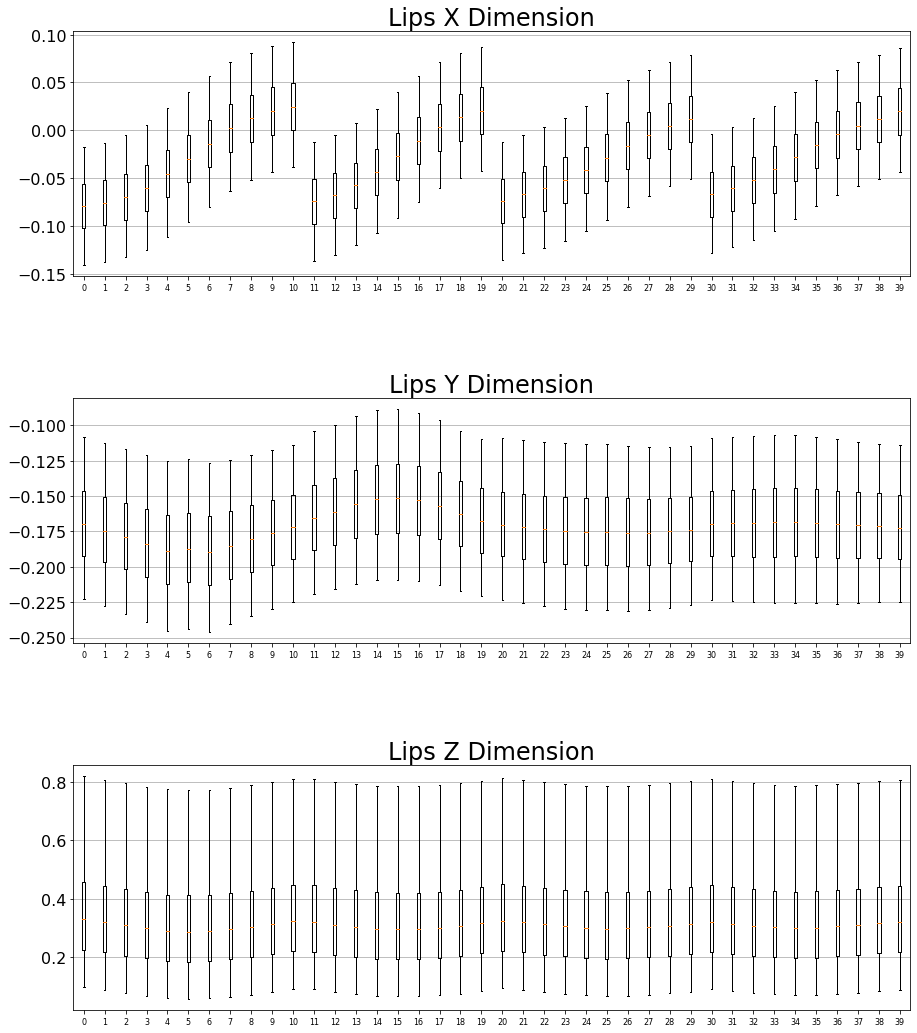

In [35]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [36]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
logger.info(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

[2023-05-01 11:21:18,309][__main__][<module>][INFO] P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

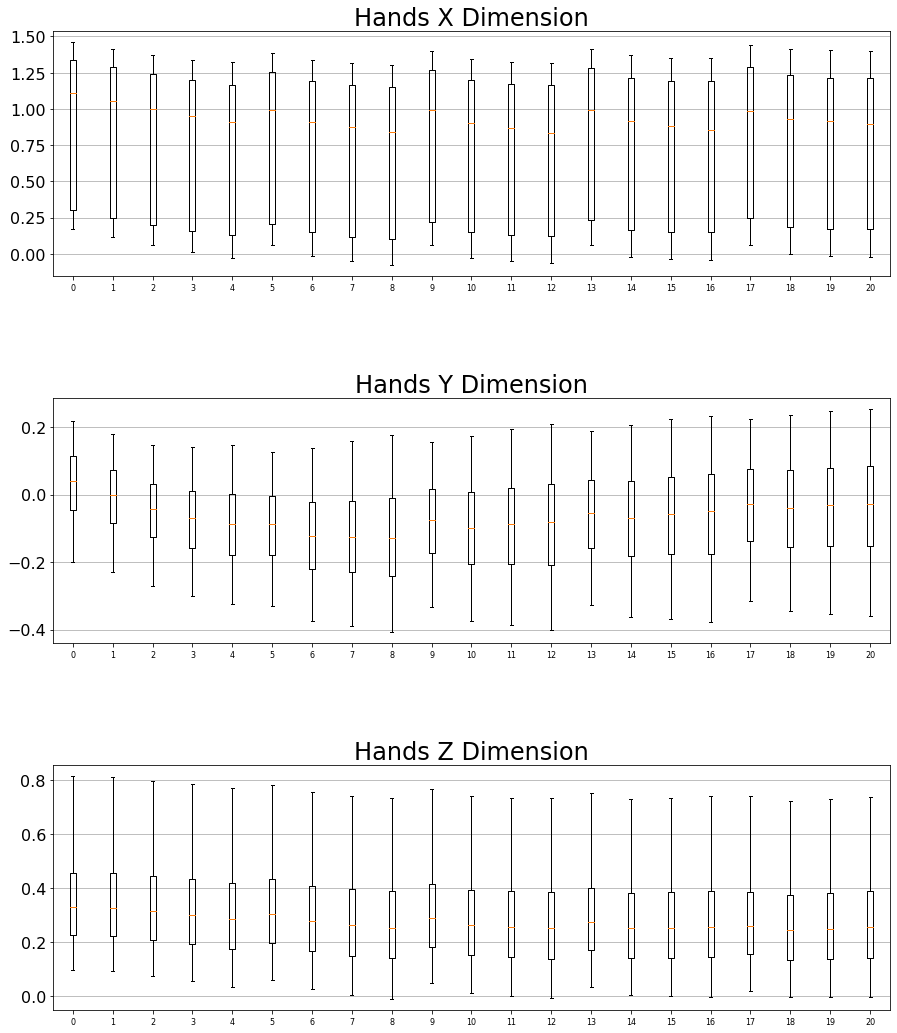

In [37]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [38]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
logger.info(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

[2023-05-01 11:21:38,585][__main__][<module>][INFO] P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/6 [00:00<?, ?it/s]

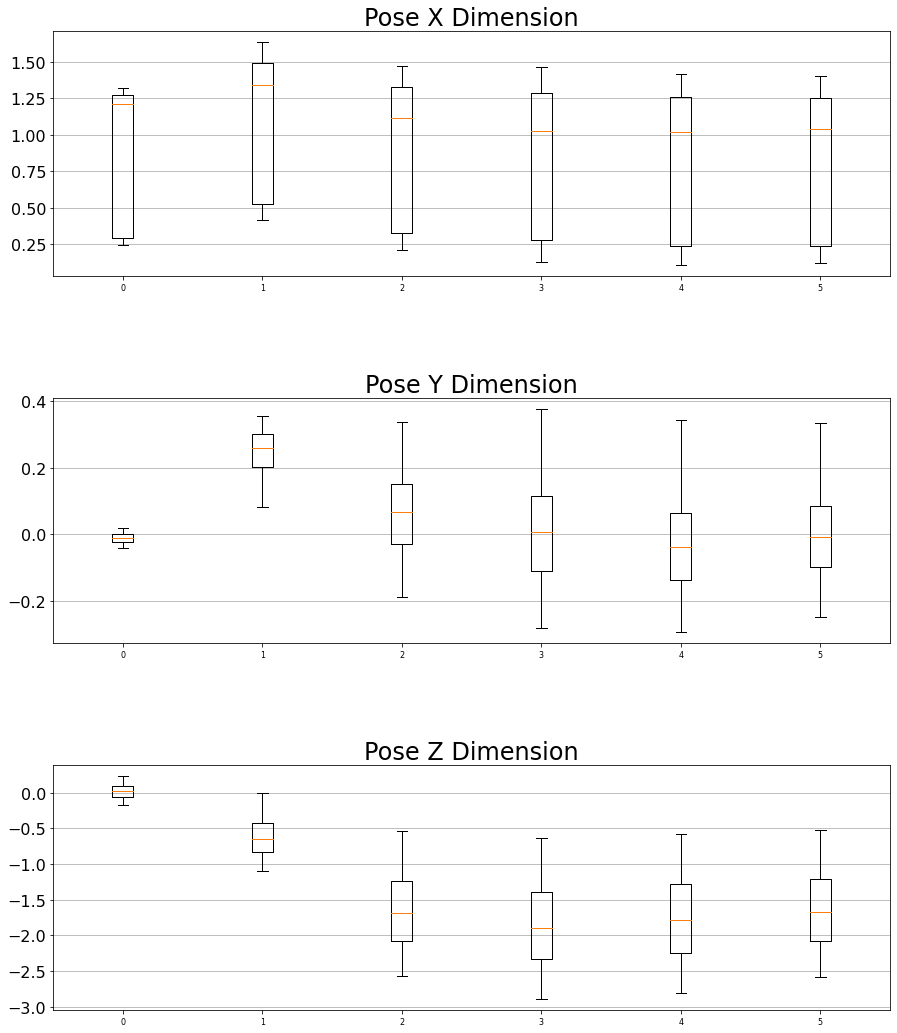

In [39]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Feature Statistics - EYE

In [40]:
# Percentage of Lips Measurements
P_EYE_MEASUREMENTS = (X_train[:,:,EYE_IDXS] != 0).sum() / X_train[:,:,EYE_IDXS].size / P_DATA_FILLED * 1e4
logger.info(f'P_EYE_MEASUREMENTS: {P_EYE_MEASUREMENTS:.2f}%')

[2023-05-01 11:21:52,784][__main__][<module>][INFO] P_EYE_MEASUREMENTS: 99.76%


  0%|          | 0/16 [00:00<?, ?it/s]

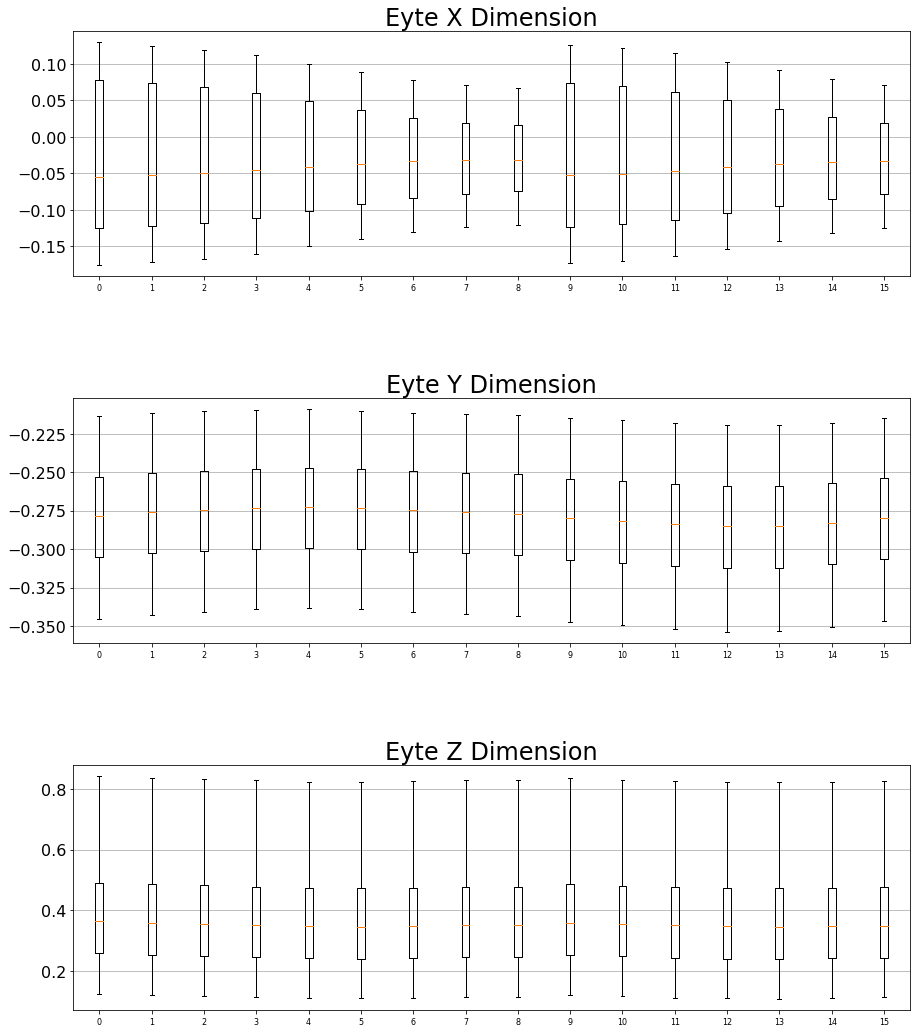

In [41]:
def get_eye_mean_std():
    # EYE
    EYE_MEAN_X = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_MEAN_Y = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_STD_X = np.zeros([EYE_IDXS.size], dtype=np.float32)
    EYE_STD_Y = np.zeros([EYE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,EYE_IDXS], [2,3,0,1]).reshape([EYE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                EYE_MEAN_X[col] = v.mean()
                EYE_STD_X[col] = v.std()
            if dim == 1: # Y
                EYE_MEAN_Y[col] = v.mean()
                EYE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Eyte {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    EYE_MEAN = np.array([EYE_MEAN_X, EYE_MEAN_Y]).T
    EYE_STD = np.array([EYE_STD_X, EYE_STD_Y]).T
    
    return EYE_MEAN, EYE_STD

EYE_MEAN, EYE_STD = get_eye_mean_std()

#  Feature Statistics - HAND BONE

In [42]:
# Verify Normalised to Left Hand Bone Dominant
P_LEFT_HAND_BONE_MEASUREMENTS = (X_train[:,:,LEFT_HAND_BONE_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_BONE_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_BONE_MEASUREMENTS: {P_LEFT_HAND_BONE_MEASUREMENTS:.2f}%')

P_LEFT_HAND_BONE_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

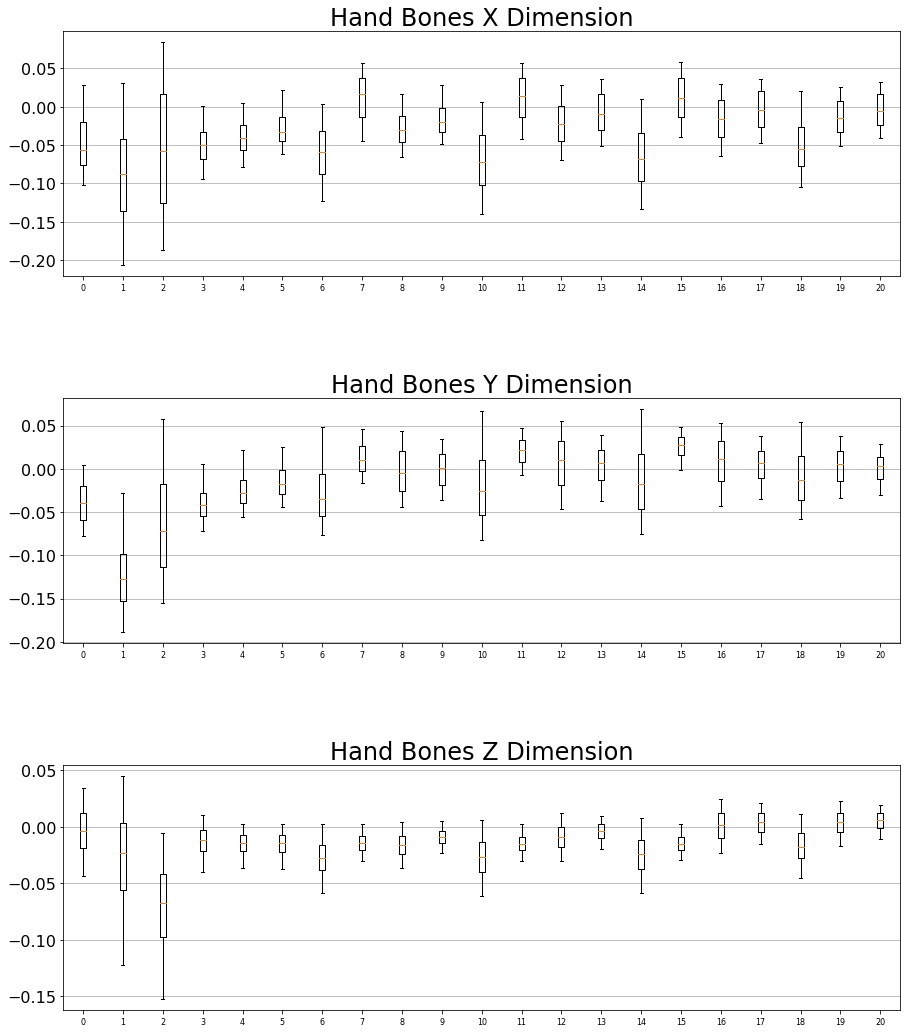

In [43]:
def get_left_right_hand_bone_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([LEFT_HAND_BONE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_BONE_IDXS], [2,3,0,1]).reshape([LEFT_HAND_BONE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD = get_left_right_hand_bone_mean_std()

# Feature Statistics - POSE BONE

In [44]:
# Percentage of Lips Measurements
P_LEFT_POSE_MEASUREMENTS = (X_train[:,:,LEFT_POSE_BONE_IDXS] != 0).sum() / X_train[:,:,LEFT_POSE_BONE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_POSE_MEASUREMENTS: {P_LEFT_POSE_MEASUREMENTS:.2f}%')

P_LEFT_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/6 [00:00<?, ?it/s]

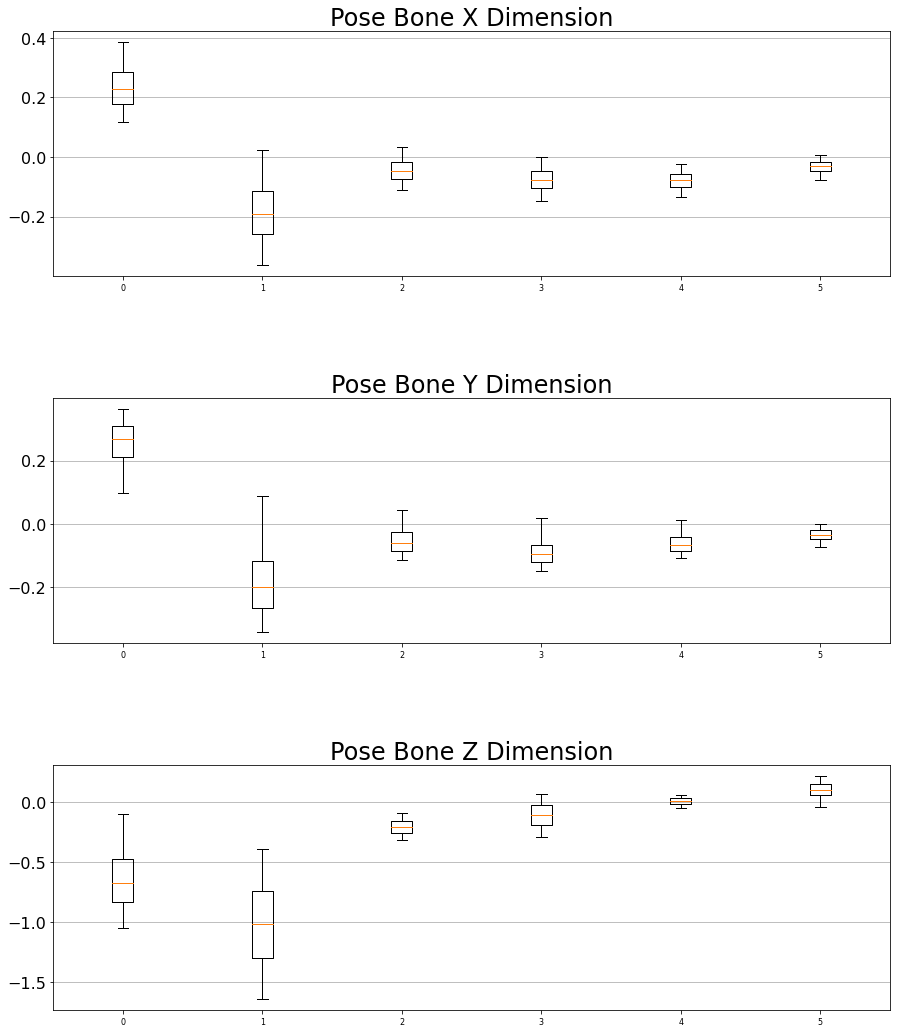

In [45]:
def get_pose_bone_mean_std():
    # POSE BONE
    LEFT_POSEBONES_MEAN_X = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Y = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Z = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_X = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Y = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Z = np.zeros([LEFT_POSE_BONE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_POSE_BONE_IDXS], [2,3,0,1]).reshape([LEFT_POSE_BONE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_POSEBONES_MEAN_X[col] = v.mean()
                LEFT_POSEBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_POSEBONES_MEAN_Y[col] = v.mean()
                LEFT_POSEBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_POSEBONES_MEAN_Z[col] = v.mean()
                LEFT_POSEBONES_STD_Z[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose Bone {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_POSEBONES_MEAN = np.array([LEFT_POSEBONES_MEAN_X, LEFT_POSEBONES_MEAN_Y, LEFT_POSEBONES_MEAN_Z]).T
    LEFT_POSEBONES_STD = np.array([LEFT_POSEBONES_STD_X, LEFT_POSEBONES_STD_Y, LEFT_POSEBONES_STD_Z]).T
    
    return LEFT_POSEBONES_MEAN, LEFT_POSEBONES_STD

LEFT_POSEBONES_MEAN, LEFT_POSEBONES_STD = get_pose_bone_mean_std()

# Feature Statistics - LIPS MOTION

  0%|          | 0/40 [00:00<?, ?it/s]

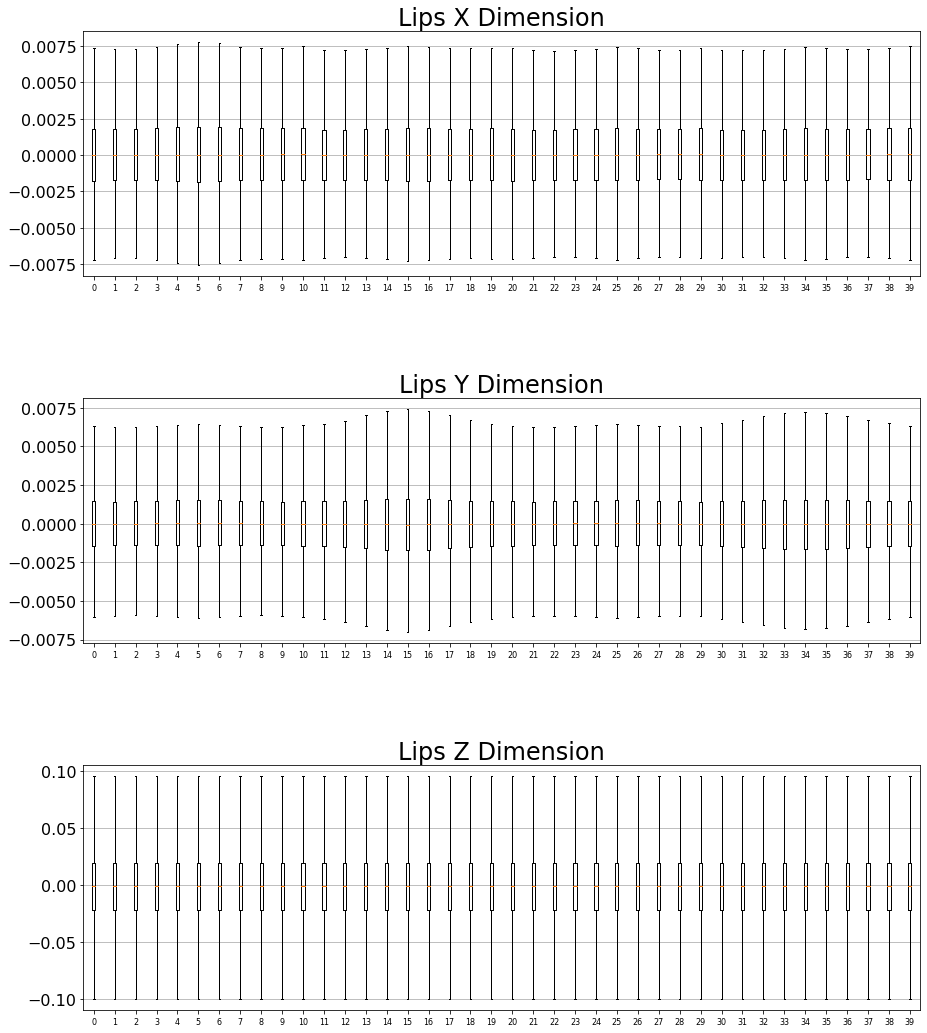

In [46]:
def get_lips_motion_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_VEL_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_VEL_MEAN, LIPS_VEL_STD = get_lips_motion_mean_std()

# Feature Statistics - LIPS ACC

  0%|          | 0/40 [00:00<?, ?it/s]

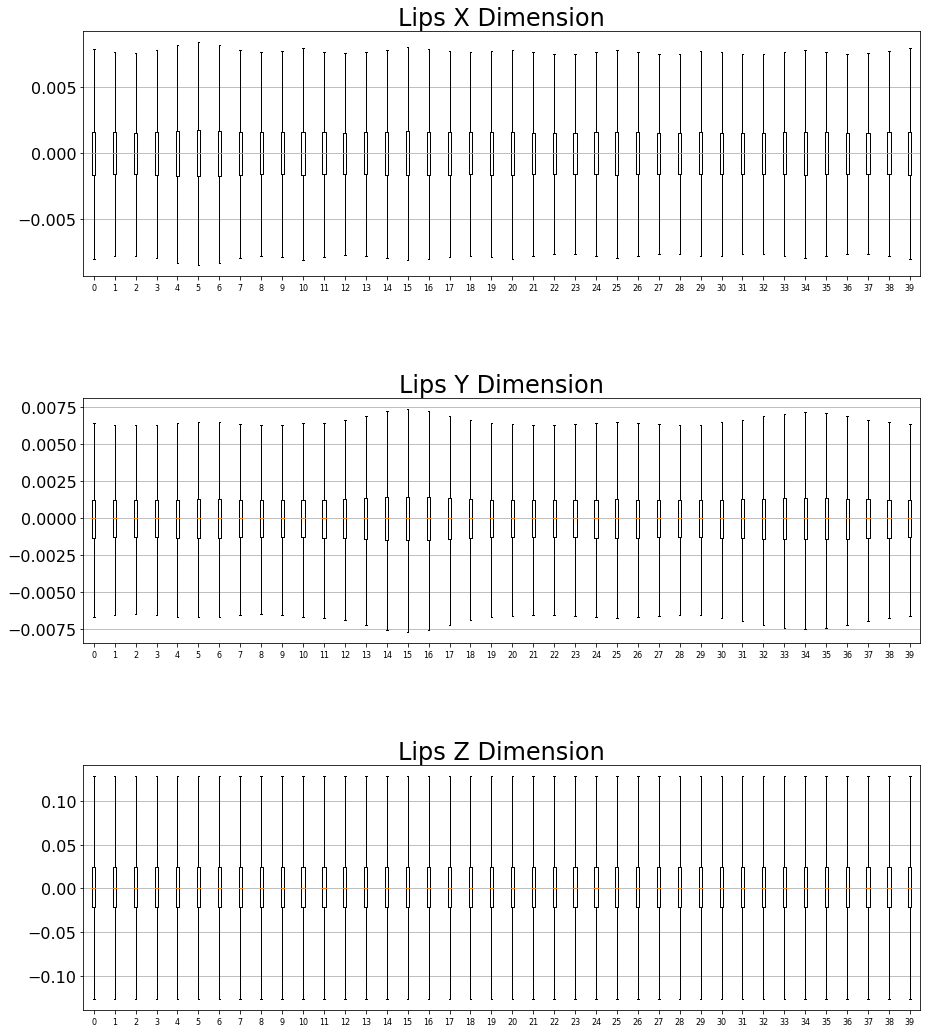

In [47]:
def get_lips_acc_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_ACC_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_ACC_MEAN, LIPS_ACC_STD = get_lips_acc_mean_std()

# Feature Statistics - Hands vel

  0%|          | 0/21 [00:00<?, ?it/s]

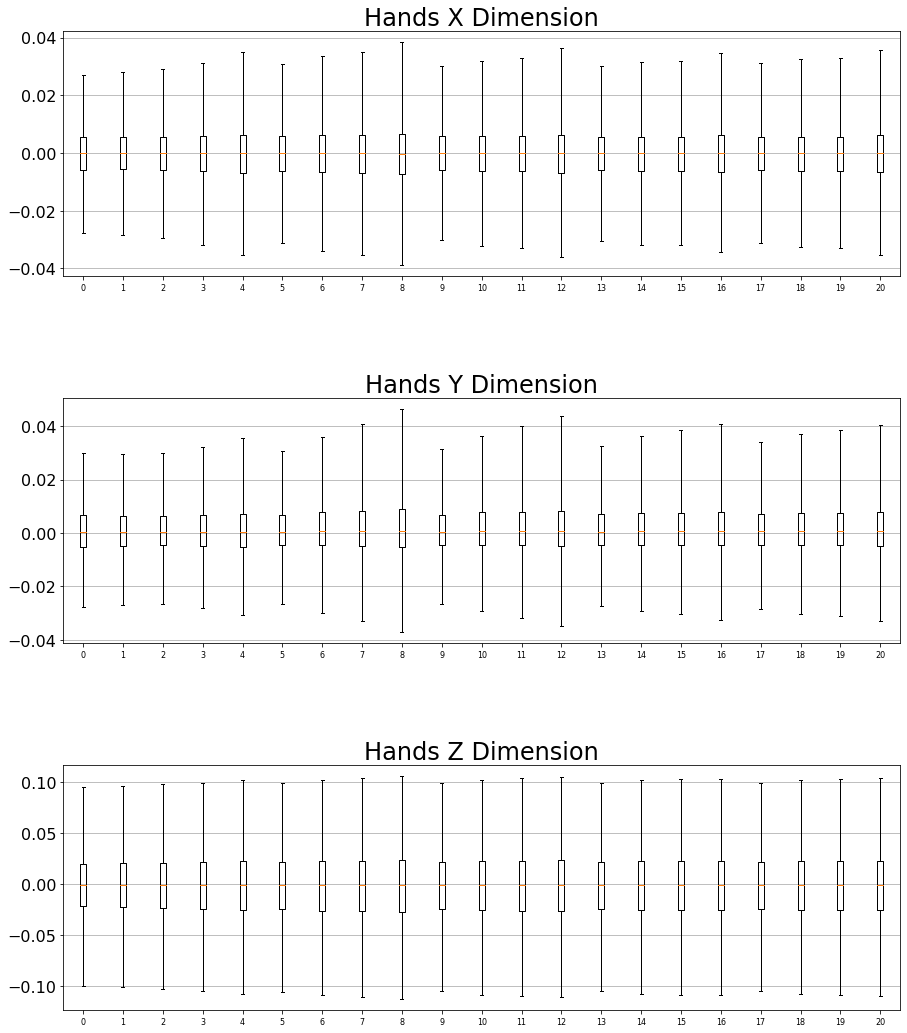

In [48]:
def get_left_right_hand_vel_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_VEL_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_VEL_HANDS_MEAN, LEFT_VEL_HANDS_STD = get_left_right_hand_vel_mean_std()

# Feature Statistics - Hands acc

  0%|          | 0/21 [00:00<?, ?it/s]

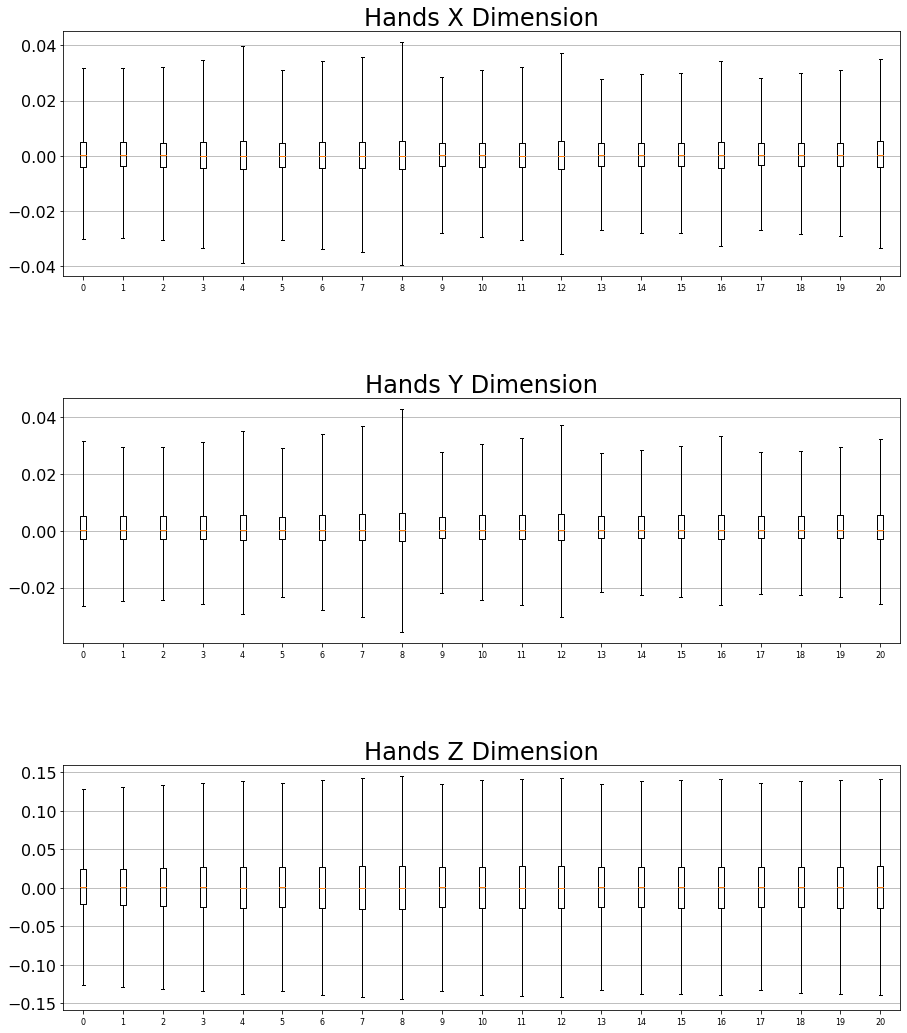

In [49]:
def get_left_right_hand_acc_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_ACC_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_ACC_HANDS_MEAN, LEFT_ACC_HANDS_STD = get_left_right_hand_acc_mean_std()

# Feature Statistics - pose vel

  0%|          | 0/6 [00:00<?, ?it/s]

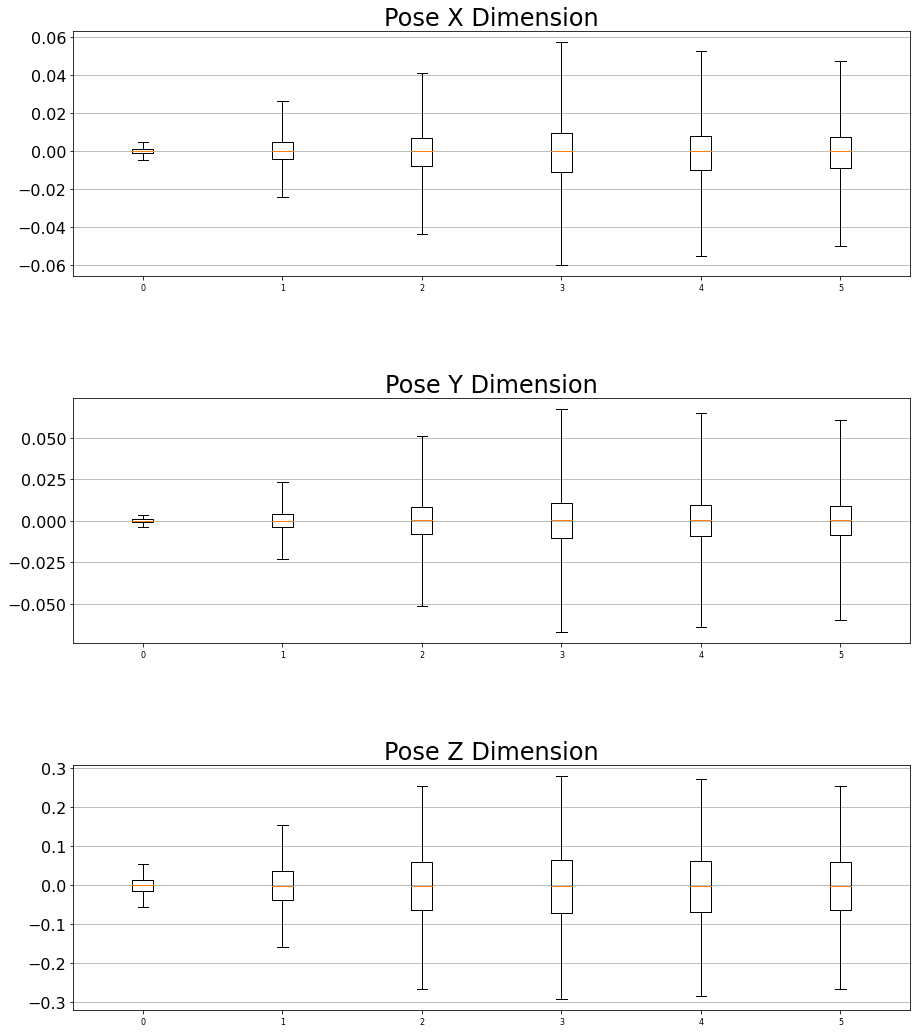

In [50]:
def get_pose_vel_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_VEL_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_VEL_MEAN, POSE_VEL_STD = get_pose_vel_mean_std()

# Feature Statistics - pose acc

  0%|          | 0/6 [00:00<?, ?it/s]

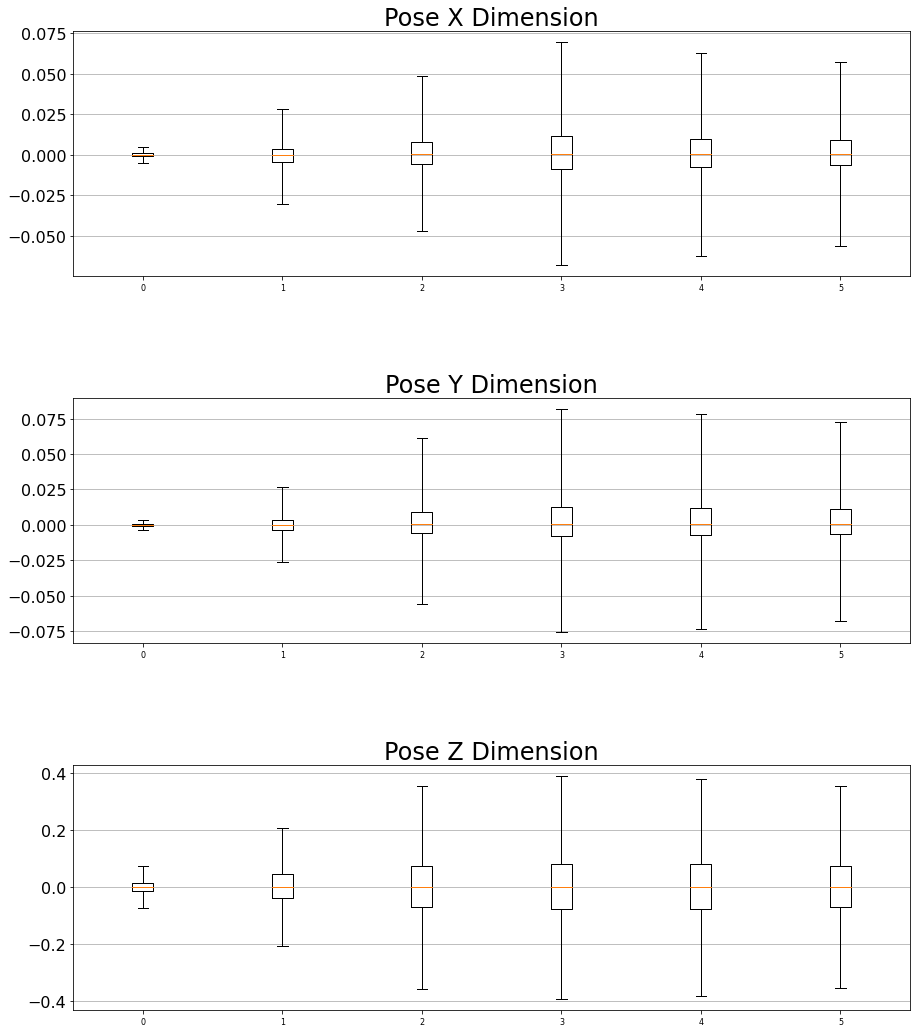

In [51]:
def get_pose_acc_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_ACC_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_ACC_MEAN, POSE_ACC_STD = get_pose_acc_mean_std()

In [52]:
# data = tf.concat([data, hand_bone, pose_bone, padded_velocity_data, padded_acceleration_data, hand_joint_distances, hand_relative_angles, pose_joint_distances, pose_relative_angles, padded_hand_relative_angles_velocity_data, padded_pose_relative_angles_velocity_data], axis=1)
#hand_joint_distances, hand_relative_angles, pose_joint_distances, pose_relative_angles, padded_hand_relative_angles_velocity_data, padded_pose_relative_angles_velocity_data

# hand_joint_distances

  0%|          | 0/21 [00:00<?, ?it/s]

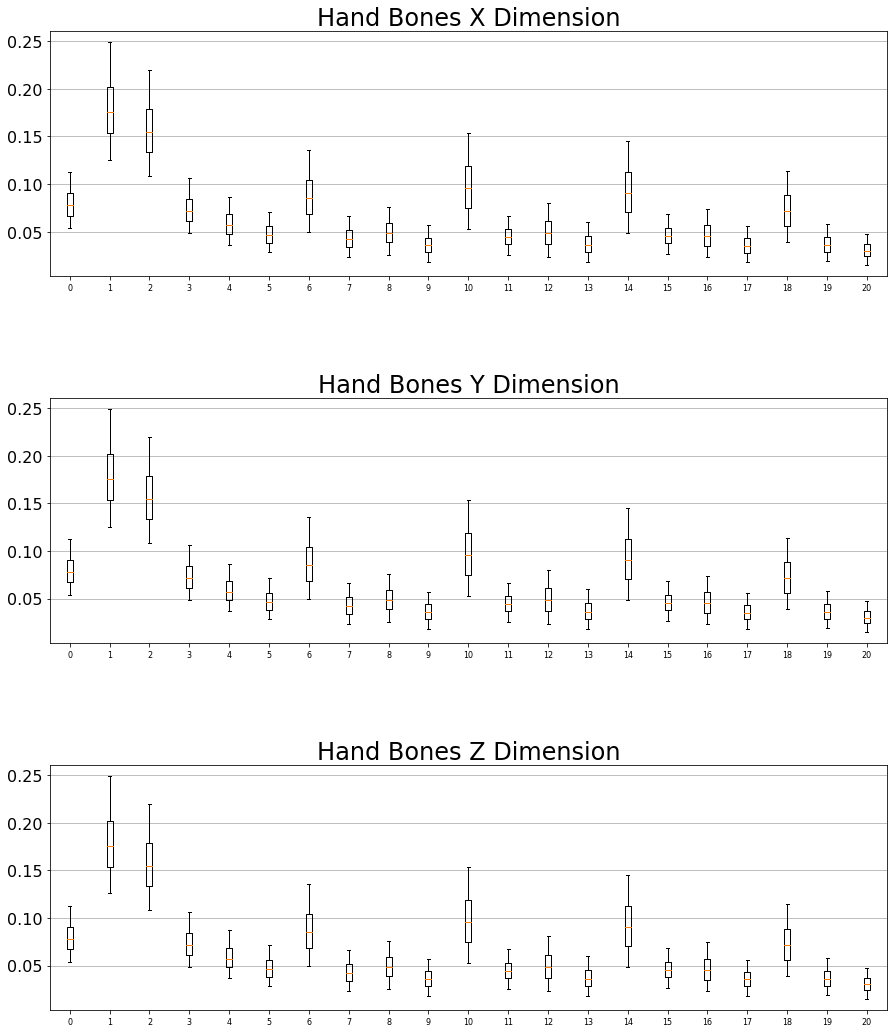

In [53]:
def get_left_right_hand_jnt_dist_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([HAND_JNT_DIST_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,HAND_JNT_DIST_IDXS], [2,3,0,1]).reshape([HAND_JNT_DIST_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_HAND_JNT_DIST_MEAN, LEFT_HAND_JNT_DIST_STD = get_left_right_hand_jnt_dist_mean_std()

# hand_relative_angles

  0%|          | 0/20 [00:00<?, ?it/s]

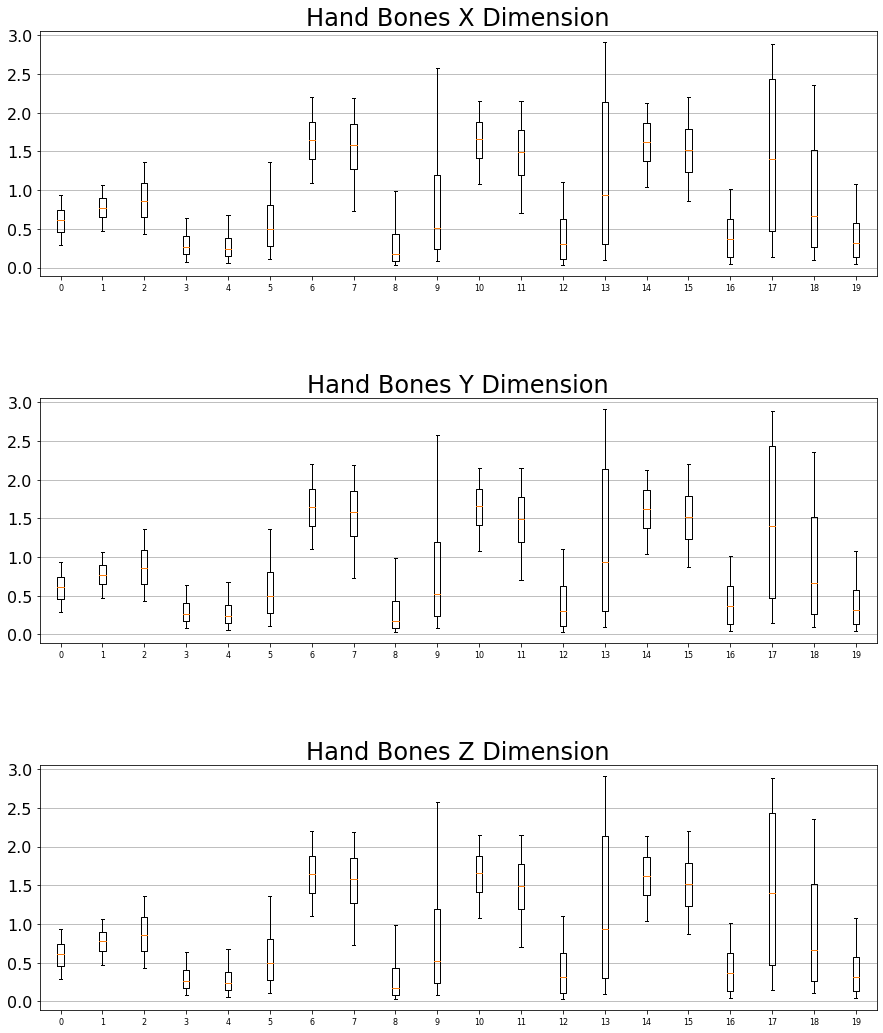

In [54]:
def get_left_right_hand_rel_ang_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([HAND_REL_ANG_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,HAND_REL_ANG_IDXS], [2,3,0,1]).reshape([HAND_REL_ANG_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_HAND_REL_ANG_MEAN, LEFT_HAND_REL_ANG_STD = get_left_right_hand_rel_ang_mean_std()

# pose_joint_distances

  0%|          | 0/6 [00:00<?, ?it/s]

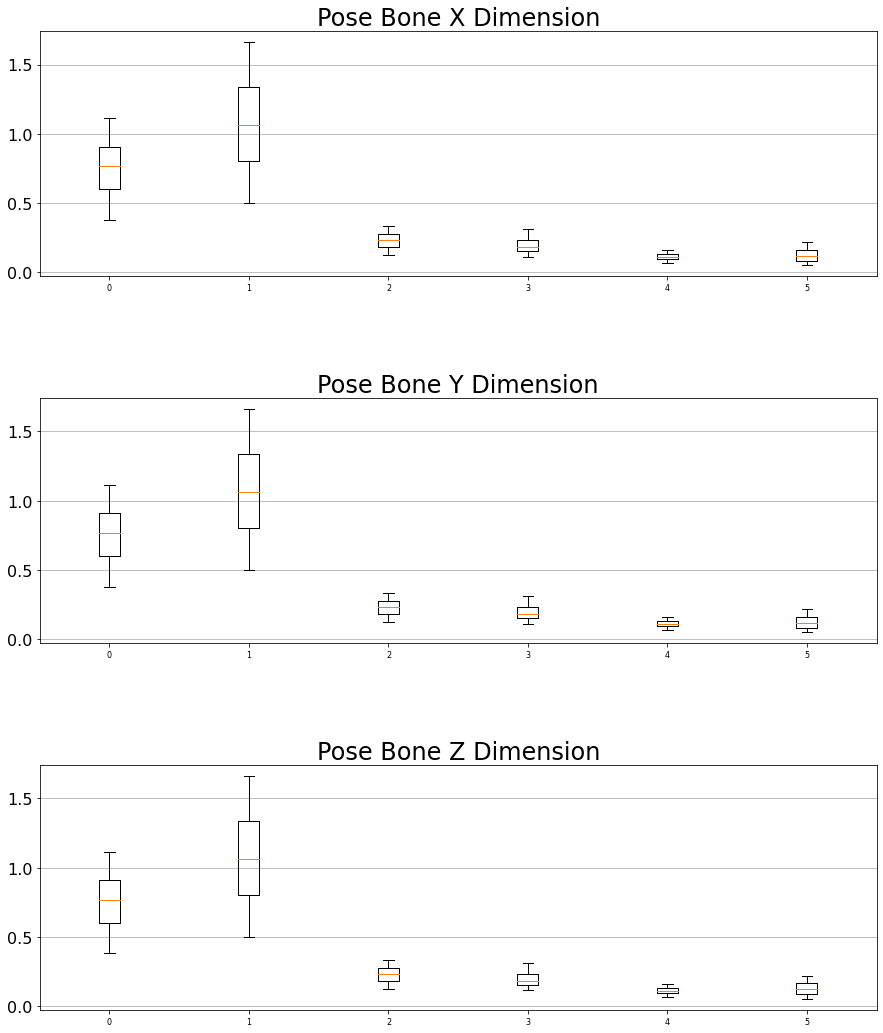

In [55]:
def get_pose_jnt_dist_mean_std():
    # POSE BONE
    LEFT_POSEBONES_MEAN_X = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Y = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Z = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_X = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Y = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Z = np.zeros([POSE_JNT_DIST_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_JNT_DIST_IDXS], [2,3,0,1]).reshape([POSE_JNT_DIST_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_POSEBONES_MEAN_X[col] = v.mean()
                LEFT_POSEBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_POSEBONES_MEAN_Y[col] = v.mean()
                LEFT_POSEBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_POSEBONES_MEAN_Z[col] = v.mean()
                LEFT_POSEBONES_STD_Z[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose Bone {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_POSEBONES_MEAN = np.array([LEFT_POSEBONES_MEAN_X, LEFT_POSEBONES_MEAN_Y, LEFT_POSEBONES_MEAN_Z]).T
    LEFT_POSEBONES_STD = np.array([LEFT_POSEBONES_STD_X, LEFT_POSEBONES_STD_Y, LEFT_POSEBONES_STD_Z]).T
    
    return LEFT_POSEBONES_MEAN, LEFT_POSEBONES_STD

LEFT_POSE_JNT_DIST_MEAN, LEFT_POSE_JNT_DIST_STD = get_pose_jnt_dist_mean_std()

In [56]:
# pose_relative_angles

  0%|          | 0/5 [00:00<?, ?it/s]

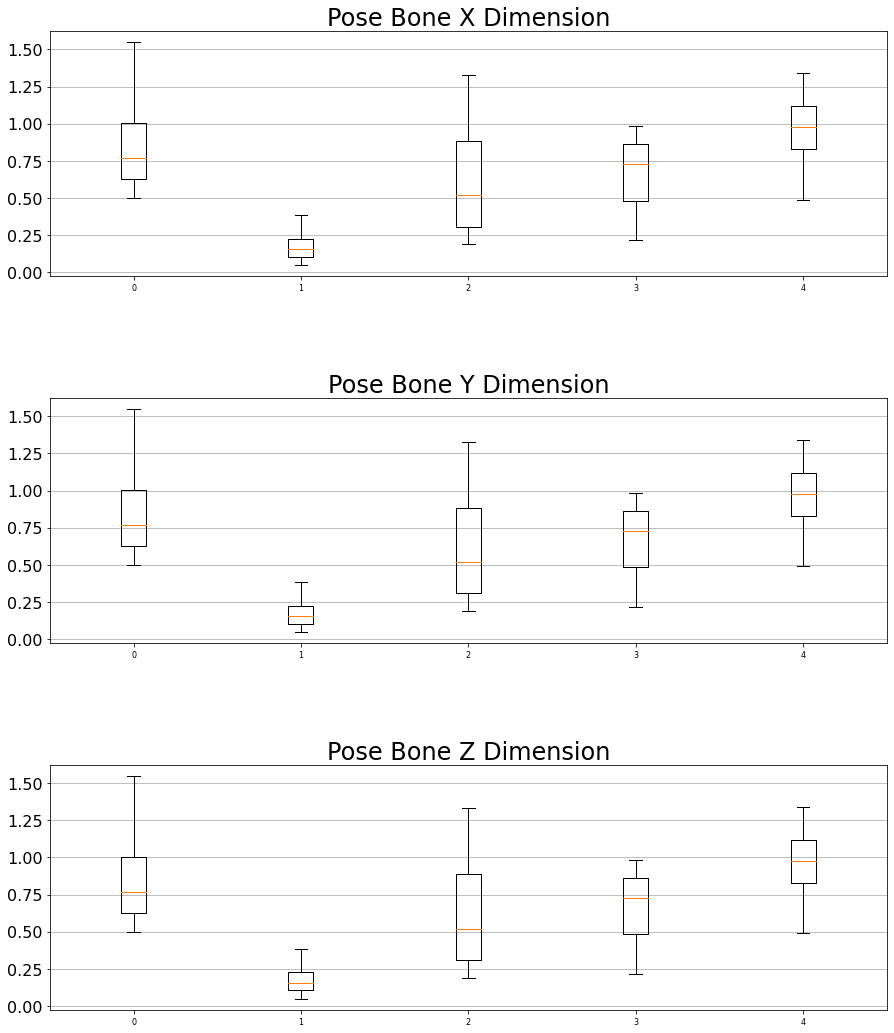

In [57]:
def get_pose_bone_rel_ang_std():
    # POSE BONE
    LEFT_POSEBONES_MEAN_X = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Y = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Z = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_X = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Y = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Z = np.zeros([POSE_REL_ANG_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_REL_ANG_IDXS], [2,3,0,1]).reshape([POSE_REL_ANG_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_POSEBONES_MEAN_X[col] = v.mean()
                LEFT_POSEBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_POSEBONES_MEAN_Y[col] = v.mean()
                LEFT_POSEBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_POSEBONES_MEAN_Z[col] = v.mean()
                LEFT_POSEBONES_STD_Z[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose Bone {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_POSEBONES_MEAN = np.array([LEFT_POSEBONES_MEAN_X, LEFT_POSEBONES_MEAN_Y, LEFT_POSEBONES_MEAN_Z]).T
    LEFT_POSEBONES_STD = np.array([LEFT_POSEBONES_STD_X, LEFT_POSEBONES_STD_Y, LEFT_POSEBONES_STD_Z]).T
    
    return LEFT_POSEBONES_MEAN, LEFT_POSEBONES_STD

LEFT_POSE_REL_ANG_MEAN, LEFT_POSE_REL_ANG_STD = get_pose_bone_rel_ang_std()

# padded_hand_relative_angles_velocity_data

  0%|          | 0/20 [00:00<?, ?it/s]

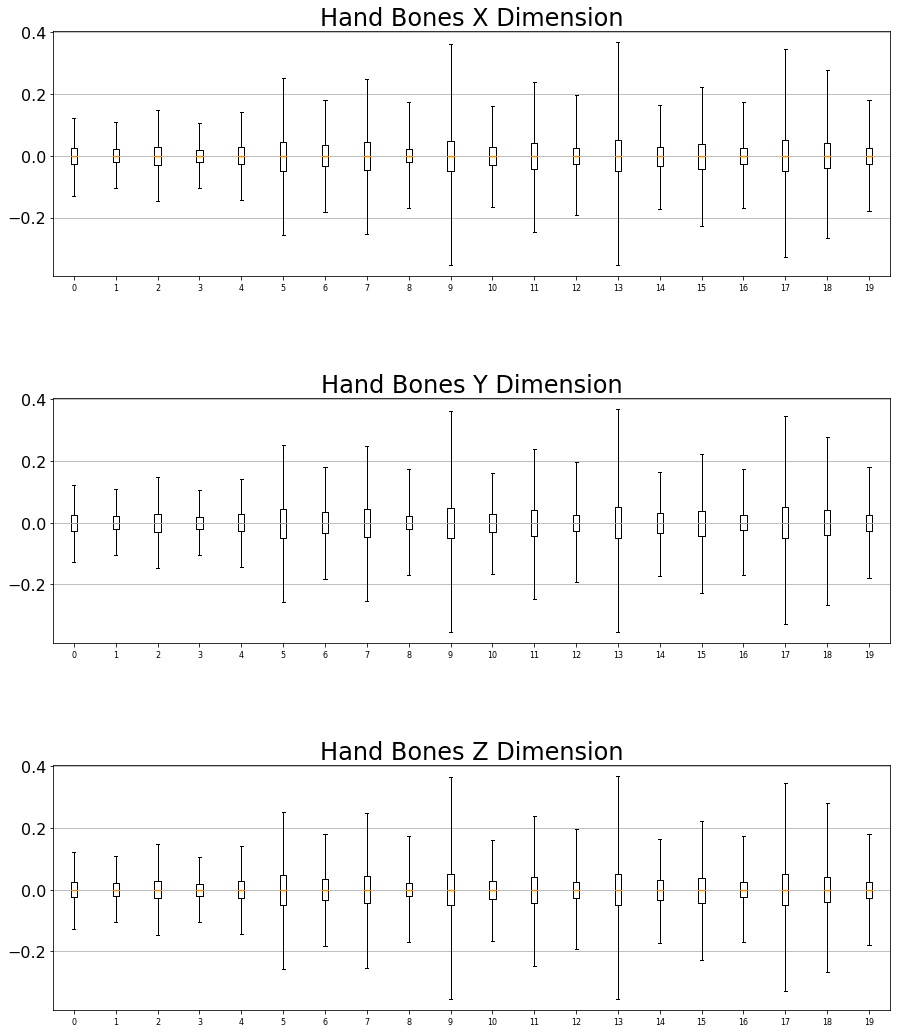

In [58]:
def get_left_right_hand_rel_ang_vel_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([HAND_REL_ANG_VEL_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,HAND_REL_ANG_VEL_IDXS], [2,3,0,1]).reshape([HAND_REL_ANG_VEL_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_HAND_REL_ANG_VEL_MEAN, LEFT_HAND_REL_ANG_VEL_STD = get_left_right_hand_rel_ang_vel_mean_std()

# padded_pose_relative_angles_velocity_data

  0%|          | 0/5 [00:00<?, ?it/s]

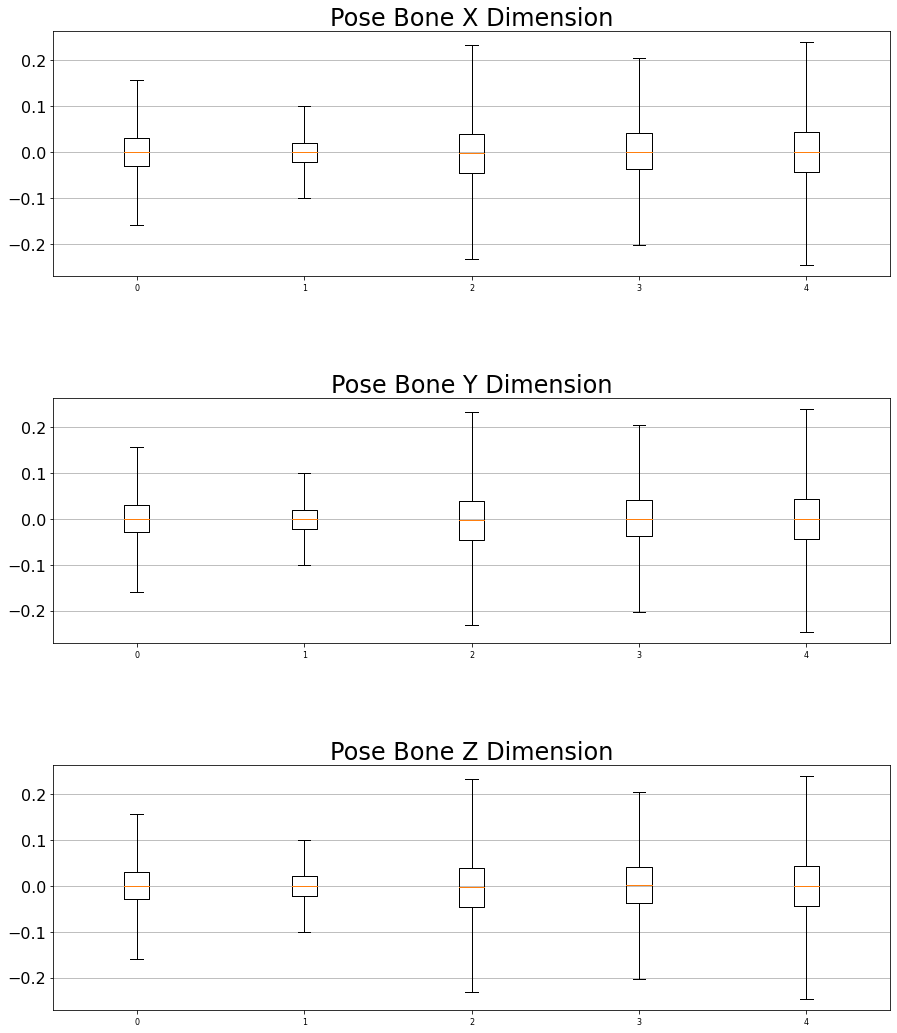

In [59]:
def get_pose_rel_ang_vel_mean_std():
    # POSE BONE
    LEFT_POSEBONES_MEAN_X = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Y = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_MEAN_Z = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_X = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Y = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)
    LEFT_POSEBONES_STD_Z = np.zeros([POSE_REL_ANG_VEL_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_REL_ANG_VEL_IDXS], [2,3,0,1]).reshape([POSE_REL_ANG_VEL_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_POSEBONES_MEAN_X[col] = v.mean()
                LEFT_POSEBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_POSEBONES_MEAN_Y[col] = v.mean()
                LEFT_POSEBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_POSEBONES_MEAN_Z[col] = v.mean()
                LEFT_POSEBONES_STD_Z[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose Bone {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_POSEBONES_MEAN = np.array([LEFT_POSEBONES_MEAN_X, LEFT_POSEBONES_MEAN_Y, LEFT_POSEBONES_MEAN_Z]).T
    LEFT_POSEBONES_STD = np.array([LEFT_POSEBONES_STD_X, LEFT_POSEBONES_STD_Y, LEFT_POSEBONES_STD_Z]).T
    
    return LEFT_POSEBONES_MEAN, LEFT_POSEBONES_STD

LEFT_POSE_REL_ANG_VEL_MEAN, LEFT_POSE_REL_ANG_VEL_STD = get_pose_rel_ang_vel_mean_std()

# hand shapse

  0%|          | 0/11 [00:00<?, ?it/s]

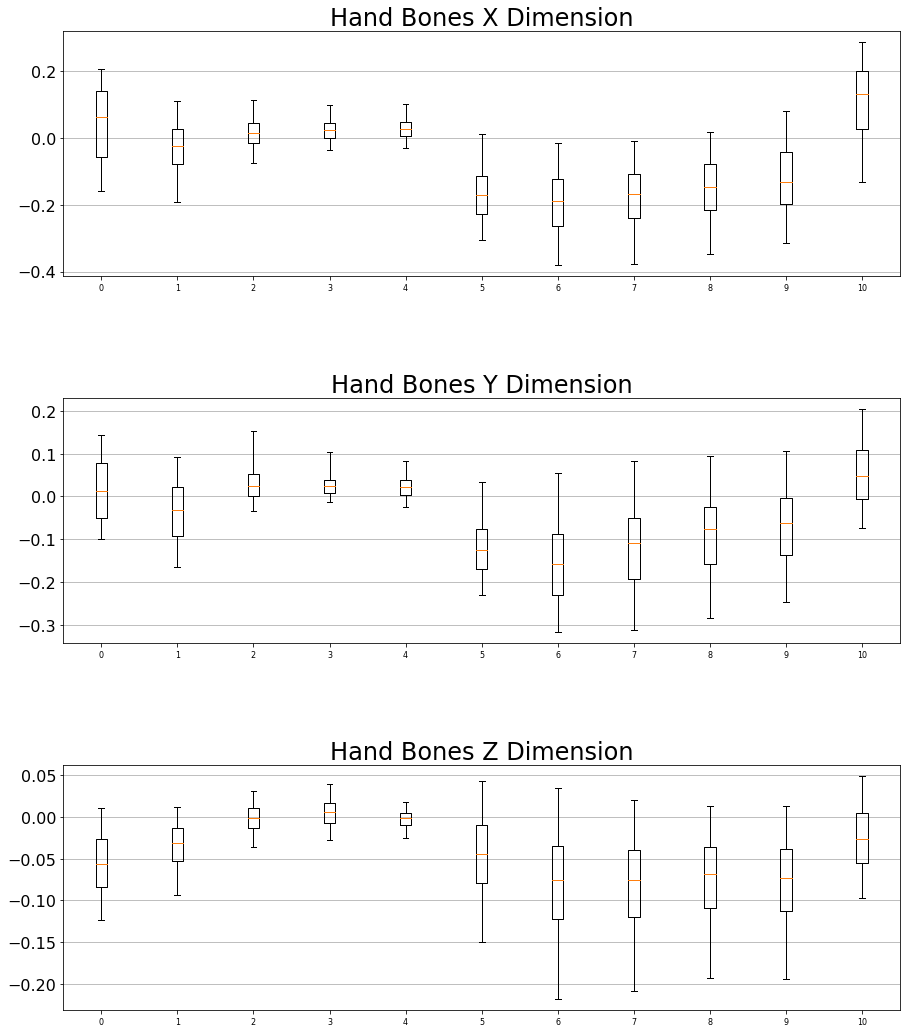

In [60]:
def get_left_right_hand_shape_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([LEFT_HAND_SHAPE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_SHAPE_IDXS], [2,3,0,1]).reshape([LEFT_HAND_SHAPE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_HAND_SHAPE_MEAN, LEFT_HAND_SHAPE_STD = get_left_right_hand_shape_mean_std()

# pose shapse

  0%|          | 0/4 [00:00<?, ?it/s]

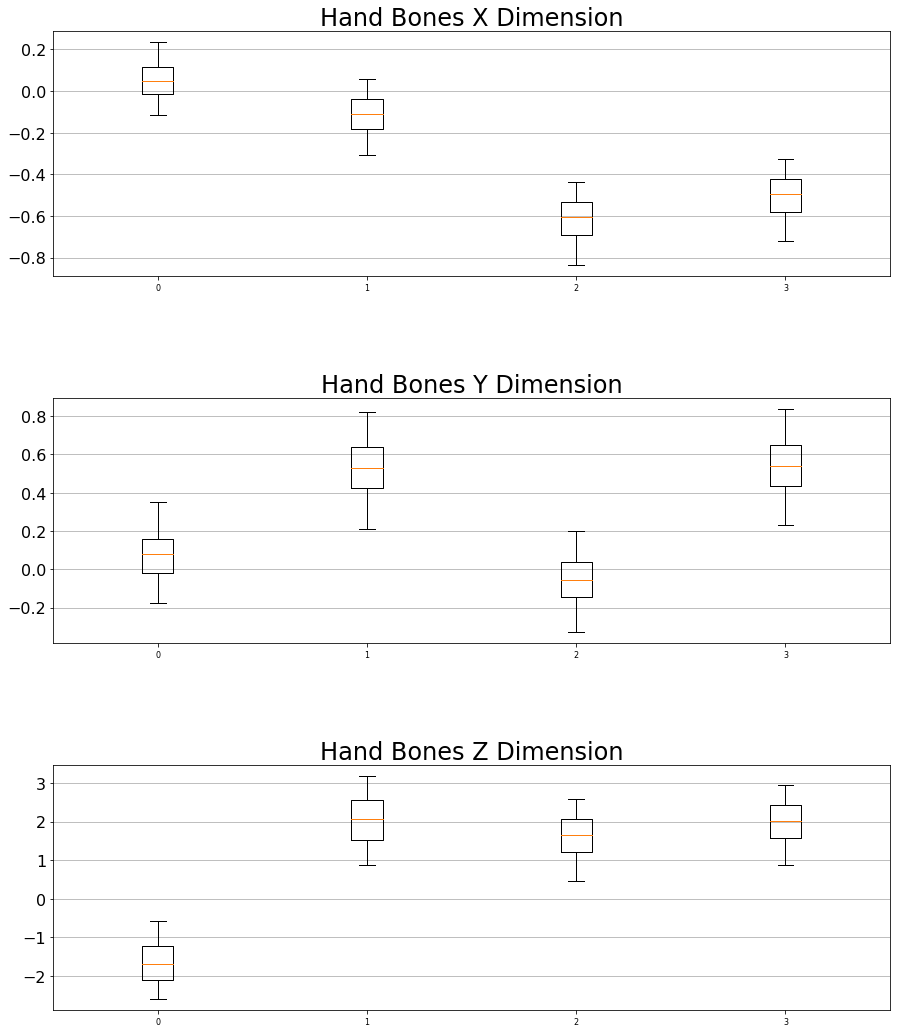

In [61]:
def get_left_right_pose_shape_mean_std():
    # LEFT HAND BONE
    LEFT_HANDBONES_MEAN_X = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Y = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_MEAN_Z = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_X = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Y = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)
    LEFT_HANDBONES_STD_Z = np.zeros([LEFT_POSE_SHAPE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_POSE_SHAPE_IDXS], [2,3,0,1]).reshape([LEFT_POSE_SHAPE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDBONES_MEAN_X[col] = v.mean()
                LEFT_HANDBONES_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDBONES_MEAN_Y[col] = v.mean()
                LEFT_HANDBONES_STD_Y[col] = v.std()
            if dim == 2: # Z
                LEFT_HANDBONES_MEAN_Z[col] = v.mean()
                LEFT_HANDBONES_STD_Z[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hand Bones {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDBONES_MEAN = np.array([LEFT_HANDBONES_MEAN_X, LEFT_HANDBONES_MEAN_Y, LEFT_HANDBONES_MEAN_Z]).T
    LEFT_HANDBONES_STD = np.array([LEFT_HANDBONES_STD_X, LEFT_HANDBONES_STD_Y, LEFT_HANDBONES_STD_Z]).T
    
    return LEFT_HANDBONES_MEAN, LEFT_HANDBONES_STD

LEFT_POSE_SHAPE_MEAN, LEFT_POSE_SHAPE_STD = get_left_right_pose_shape_mean_std()

# Samples

In [62]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [63]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    logger.info(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
logger.info(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

[2023-05-01 11:26:09,097][__main__][<module>][INFO] frames shape: (1000, 32, 368, 3), dtype: float32
[2023-05-01 11:26:09,099][__main__][<module>][INFO] non_empty_frame_idxs shape: (1000, 32), dtype: float32
[2023-05-01 11:26:09,100][__main__][<module>][INFO] y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


# Model Config

In [64]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
EYE_UNITS = 384
HANDBONES_UNITS = 384
POSEBONES_UNITS = 384
LIPS_VEL_UNITS = 384
HANDS_VEL_UNITS = 384
POSE_VEL_UNITS = 384
LIPS_ACC_UNITS = 384
HANDS_ACC_UNITS = 384
POSE_ACC_UNITS = 384

# final embedding and transformer embedding size
UNITS = 512

INPUT_DIMS = 2
# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 4

# Dropout
EMBEDDING_DROPOUT = 0.0
MLP_DROPOUT_RATIO = 0.15
CLASSIFIER_DROPOUT_RATIO = 0.0

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

logger.info(f'UNITS: {UNITS}')

[2023-05-01 11:26:09,121][__main__][<module>][INFO] UNITS: 512


In [65]:
# さらに新しい変数を辞書に追加する
config.update({
    'layer_norm_eps': LAYER_NORM_EPS,
    'lips_units': LIPS_UNITS,
    'hands_units': HANDS_UNITS,
    'pose_units': POSE_UNITS,
    'units': UNITS,
    'num_blocks': NUM_BLOCKS,
    'mlp_ratio': MLP_RATIO,
    'embedding_dropout': EMBEDDING_DROPOUT,
    'mlp_dropout_ratio': MLP_DROPOUT_RATIO,
    'classifier_dropout_ratio': CLASSIFIER_DROPOUT_RATIO,
    # 'init_he_uniform': INIT_HE_UNIFORM,
    # 'init_glorot_uniform': INIT_GLOROT_UNIFORM,
    # 'init_zeros': INIT_ZEROS,
    # 'gelu': GELU
})


In [66]:
import json

def ndarray_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# 辞書の値をリストに変換する
config_converted = {k: ndarray_to_list(v) for k, v in config.items()}

# 辞書を JSON 形式でファイルに保存する
with open(out_root + 'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_converted, f, ensure_ascii=False, indent=4)

print("config が config.json ファイルに保存されました。")


config が config.json ファイルに保存されました。


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [67]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [68]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding

In [69]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [70]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        self.eye_embedding = LandmarkEmbedding(POSE_UNITS, 'eye')
        
        self.handbones_embedding = LandmarkEmbedding(HANDBONES_UNITS, 'hand_bone')
        self.posebones_embedding = LandmarkEmbedding(POSEBONES_UNITS, 'pose_bone')
        
        self.lips_vel_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips_vel')
        self.left_vel_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand_vel')
        self.pose_vel_embedding = LandmarkEmbedding(POSE_UNITS, 'pose_vel')
        
        self.lips_acc_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips_acc')
        self.left_acc_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand_acc')
        self.pose_acc_embedding = LandmarkEmbedding(POSE_UNITS, 'pose_acc')        
        
        #########################
        # new
        ####
        self.left_jnt_dist_hand_embedding    = LandmarkEmbedding(HANDS_UNITS, 'left_hand_jnt_dist')
        self.left_rel_ang_hand_embedding     = LandmarkEmbedding(HANDS_UNITS, 'left_hand_rel_ang')
        
        self.pose_jnt_dist_embedding         = LandmarkEmbedding(HANDS_UNITS, 'pose_jnt_dist')
        self.pose_rel_ang_embedding          = LandmarkEmbedding(HANDS_UNITS, 'pose_rel_ang')
        # vel
        self.left_rel_ang_vel_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand_rel_ang_vel')
        self.pose_rel_ang_vel_embedding      = LandmarkEmbedding(HANDS_UNITS, 'pose_rel_ang_vel')
                
        self.left_hand_shape_embedding       = LandmarkEmbedding(HANDS_UNITS, 'left_hand_shape')
        self.left_pose_shape_embedding       = LandmarkEmbedding(HANDS_UNITS, 'left_pose_shape')
        
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([20], dtype=tf.float32), name='landmark_weights')
        
        
        
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, eye0,
             handbones0, posebones0, 
             lips_vel0, left_hand_vel0, pose_vel0, 
             lips_acc0, left_hand_acc0, pose_acc0,
            left_jnt_dist_hand, left_rel_ang_hand, 
            pose_jnt_dist, pose_rel_ang, 
            left_rel_ang_vel_hand, pose_rel_ang_vel,
             left_hand_shape, left_pose_shape,
             non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Eye
        eye_embedding = self.eye_embedding(eye0)
        # Hand Bone
        handbones_embedding = self.handbones_embedding(handbones0)
        # Pose Bone
        posebones_embedding = self.posebones_embedding(posebones0)
        
        # Lips
        lips_vel_embedding = self.lips_vel_embedding(lips_vel0)
        # Left Hand
        left_vel_hand_embedding = self.left_vel_hand_embedding(left_hand_vel0)
        # Pose
        pose_vel_embedding = self.pose_vel_embedding(pose_vel0) 

        # Left Hand
        left_acc_hand_embedding = self.left_acc_hand_embedding(left_hand_acc0)
        # Pose
        pose_acc_embedding = self.pose_acc_embedding(pose_acc0) 
        # Lips
        lips_acc_embedding = self.lips_acc_embedding(lips_acc0)
        
        left_jnt_dist_hand_embedding   =self.left_jnt_dist_hand_embedding(left_jnt_dist_hand)
        left_rel_ang_hand_embedding    =self.left_rel_ang_hand_embedding(left_rel_ang_hand)    
        pose_jnt_dist_embedding        =self.pose_jnt_dist_embedding(pose_jnt_dist)        
        pose_rel_ang_embedding         =self.pose_rel_ang_embedding(pose_rel_ang)         
        left_rel_ang_vel_hand_embedding=self.left_rel_ang_vel_hand_embedding(left_rel_ang_vel_hand)
        pose_rel_ang_vel_embedding     =self.pose_rel_ang_vel_embedding(pose_rel_ang_vel)     

        left_hand_shape_embedding     =self.left_hand_shape_embedding(left_hand_shape)     
        left_pose_shape_embedding     =self.left_pose_shape_embedding(left_pose_shape)     
        
        
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding, eye_embedding, 
            handbones_embedding, posebones_embedding, 
            lips_vel_embedding, left_vel_hand_embedding, pose_vel_embedding,
            lips_acc_embedding, left_acc_hand_embedding, pose_acc_embedding,
            left_jnt_dist_hand_embedding,   left_rel_ang_hand_embedding,    
            pose_jnt_dist_embedding,        pose_rel_ang_embedding,         
            left_rel_ang_vel_hand_embedding,pose_rel_ang_vel_embedding,   
            left_hand_shape_embedding, left_pose_shape_embedding,
        ), axis=3)
        
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Sparse Categorical Crossentropy With Label Smoothing

In [71]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [72]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    print(x.shape)
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 6, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # EYE
    eye = tf.slice(x, [0,0,67,0], [-1,INPUT_SIZE, 16, 2])
    eye = tf.where(
            tf.math.equal(eye, 0.0),
            0.0,
            (eye - EYE_MEAN) / EYE_STD,
        )
    
    # HAND BONE
    hand_bones = tf.slice(x, [0,0,HAND_BONE_START,0], [-1,INPUT_SIZE, len(LEFT_HAND_BONE_IDXS), INPUT_DIMS])
    hand_bones = tf.where(
            tf.math.equal(hand_bones, 0.0),
            0.0,
            (hand_bones - LEFT_HANDBONES_MEAN[:, :INPUT_DIMS]) / LEFT_HANDBONES_STD[:, :INPUT_DIMS],
        )
    # POSE BONE
    pose_bones = tf.slice(x, [0,0,POSE_BONE_START,0], [-1,INPUT_SIZE, len(LEFT_POSE_BONE_IDXS), INPUT_DIMS])
    pose_bones = tf.where(
            tf.math.equal(pose_bones, 0.0),
            0.0,
            (pose_bones - LEFT_POSEBONES_MEAN[:, :INPUT_DIMS]) / LEFT_POSEBONES_STD[:, :INPUT_DIMS],
        )
    
    #print(LIPS_VEL_START, LEFT_VEL_HAND_START, RIGHT_VEL_HAND_START, POSE_VEL_START, LIPS_ACC_START, LEFT_ACC_HAND_START, RIGHT_ACC_HAND_START, POSE_ACC_START)
    # LIPS_VEL
    lips_vel = tf.slice(x, [0,0,LIPS_VEL_START,0], [-1,INPUT_SIZE, 40, 2])
    lips_vel = tf.where(
            tf.math.equal(lips_vel, 0.0),
            0.0,
            (lips_vel - LIPS_VEL_MEAN) / LIPS_VEL_STD,
        )
    # LEFT HAND_VEL
    left_hand_vel = tf.slice(x, [0,0,LEFT_VEL_HAND_START,0], [-1,INPUT_SIZE, 21, 2])
    left_hand_vel = tf.where(
            tf.math.equal(left_hand_vel, 0.0),
            0.0,
            (left_hand_vel - LEFT_VEL_HANDS_MEAN) / LEFT_VEL_HANDS_STD,
        )
    # POSE_VEL
    pose_vel = tf.slice(x, [0,0,POSE_VEL_START,0], [-1,INPUT_SIZE, 6, 2])
    pose_vel = tf.where(
            tf.math.equal(pose_vel, 0.0),
            0.0,
            (pose_vel - POSE_VEL_MEAN) / POSE_VEL_STD,
        )
    # LIPS_ACC
    lips_acc = tf.slice(x, [0,0,LIPS_ACC_START,0], [-1,INPUT_SIZE, 40, 2])
    lips_acc = tf.where(
            tf.math.equal(lips_acc, 0.0),
            0.0,
            (lips_acc - LIPS_ACC_MEAN) / LIPS_ACC_STD,
        )
    # LEFT HAND_ACC
    left_hand_acc = tf.slice(x, [0,0,LEFT_ACC_HAND_START,0], [-1,INPUT_SIZE, 21, 2])
    left_hand_acc = tf.where(
            tf.math.equal(left_hand_acc, 0.0),
            0.0,
            (left_hand_acc - LEFT_ACC_HANDS_MEAN) / LEFT_ACC_HANDS_STD,
        )
    # POSE_ACC
    pose_acc = tf.slice(x, [0,0,POSE_ACC_START,0], [-1,INPUT_SIZE, 6, 2])
    pose_acc = tf.where(
            tf.math.equal(pose_acc, 0.0),
            0.0,
            (pose_acc - POSE_ACC_MEAN) / POSE_ACC_STD,
        )
    
    # new feature ###########################
    INPUT_DIMS_2 = 1
    
    left_jnt_dist_hand = tf.slice(x, [0,0,HAND_JNT_DIST_START,0], [-1,INPUT_SIZE, 21, INPUT_DIMS_2])
    left_jnt_dist_hand  = tf.where(
            tf.math.equal(left_jnt_dist_hand, 0.0),
            0.0,
            (left_jnt_dist_hand - LEFT_HAND_JNT_DIST_MEAN[:, :INPUT_DIMS_2]) / LEFT_HAND_JNT_DIST_STD[:, :INPUT_DIMS_2],
        )
    
    left_rel_ang_hand = tf.slice(x, [0,0,HAND_REL_ANG_START,0], [-1,INPUT_SIZE, 20, INPUT_DIMS_2])
    left_rel_ang_hand= tf.where(
            tf.math.equal(left_rel_ang_hand, 0.0),
            0.0,
            (left_rel_ang_hand - LEFT_HAND_REL_ANG_MEAN[:, :INPUT_DIMS_2]) / LEFT_HAND_REL_ANG_STD[:, :INPUT_DIMS_2],
        )
    pose_jnt_dist = tf.slice(x, [0,0,POSE_JNT_DIST_START,0], [-1,INPUT_SIZE, 6, INPUT_DIMS_2])
    pose_jnt_dist= tf.where(
            tf.math.equal(pose_jnt_dist, 0.0),
            0.0,
            (pose_jnt_dist - LEFT_POSE_JNT_DIST_MEAN[:, :INPUT_DIMS_2]) / LEFT_POSE_JNT_DIST_STD[:, :INPUT_DIMS_2],
        )
    pose_rel_ang = tf.slice(x, [0,0,POSE_REL_ANG_START,0], [-1,INPUT_SIZE, 5, INPUT_DIMS_2])
    pose_rel_ang= tf.where(
            tf.math.equal(pose_rel_ang, 0.0),
            0.0,
            (pose_rel_ang - LEFT_POSE_REL_ANG_MEAN[:, :INPUT_DIMS_2]) / LEFT_POSE_REL_ANG_STD[:, :INPUT_DIMS_2],
        )
    left_rel_ang_vel_hand = tf.slice(x, [0,0,HAND_REL_ANG_VEL_START,0], [-1,INPUT_SIZE, 20, INPUT_DIMS_2])
    left_rel_ang_vel_hand= tf.where(
            tf.math.equal(left_rel_ang_vel_hand, 0.0),
            0.0,
            (left_rel_ang_vel_hand - LEFT_HAND_REL_ANG_VEL_MEAN[:, :INPUT_DIMS_2]) / LEFT_HAND_REL_ANG_VEL_STD[:, :INPUT_DIMS_2],
        )
    pose_rel_ang_vel = tf.slice(x, [0,0,POSE_REL_ANG_VEL_START,0], [-1,INPUT_SIZE, 5, INPUT_DIMS_2])
    pose_rel_ang_vel= tf.where(
            tf.math.equal(pose_rel_ang_vel, 0.0),
            0.0,
            (pose_rel_ang_vel - LEFT_POSE_REL_ANG_VEL_MEAN[:, :INPUT_DIMS_2]) / LEFT_POSE_REL_ANG_VEL_STD[:, :INPUT_DIMS_2],
        )
    
    left_hand_shape = tf.slice(x, [0,0,HAND_SHAPE_START,0], [-1,INPUT_SIZE, len(LEFT_HAND_SHAPE_IDXS), INPUT_DIMS])
    left_hand_shape  = tf.where(
            tf.math.equal(left_hand_shape, 0.0),
            0.0,
            (left_hand_shape - LEFT_HAND_SHAPE_MEAN[:, :INPUT_DIMS]) / LEFT_HAND_SHAPE_STD[:, :INPUT_DIMS],
        )
    
    left_pose_shape = tf.slice(x, [0,0,POSE_SHAPE_START,0], [-1,INPUT_SIZE, len(LEFT_POSE_SHAPE_IDXS), INPUT_DIMS])
    left_pose_shape  = tf.where(
            tf.math.equal(left_pose_shape, 0.0),
            0.0,
            (left_pose_shape - LEFT_POSE_SHAPE_MEAN[:, :INPUT_DIMS]) / LEFT_POSE_SHAPE_STD[:, :INPUT_DIMS],
        )
    
    
    # lips, left_hand, pose = Augmentation(0.1)(lips, left_hand, pose)
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 6*2])
    eye = tf.reshape(eye, [-1, INPUT_SIZE, 16*2])
    
    hand_bones = tf.reshape(hand_bones, [-1, INPUT_SIZE, len(LEFT_HAND_BONE_IDXS)*INPUT_DIMS])
    pose_bones = tf.reshape(pose_bones, [-1, INPUT_SIZE, len(LEFT_POSE_BONE_IDXS)*INPUT_DIMS])        

    lips_vel = tf.reshape(lips_vel, [-1, INPUT_SIZE, 40*2])
    left_hand_vel = tf.reshape(left_hand_vel, [-1, INPUT_SIZE, 21*2])
    pose_vel = tf.reshape(pose_vel, [-1, INPUT_SIZE, 6*2])
    
    lips_acc = tf.reshape(lips_acc, [-1, INPUT_SIZE, 40*2])
    left_hand_acc = tf.reshape(left_hand_acc, [-1, INPUT_SIZE, 21*2])
    pose_acc = tf.reshape(pose_acc, [-1, INPUT_SIZE, 6*2])

    
    left_jnt_dist_hand = tf.reshape(left_jnt_dist_hand, [-1, INPUT_SIZE, 21*INPUT_DIMS_2])
    left_rel_ang_hand = tf.reshape(left_rel_ang_hand, [-1, INPUT_SIZE, 20*INPUT_DIMS_2])
    pose_jnt_dist = tf.reshape(pose_jnt_dist, [-1, INPUT_SIZE, 6*INPUT_DIMS_2])
    pose_rel_ang = tf.reshape(pose_rel_ang, [-1, INPUT_SIZE, 5*INPUT_DIMS_2])
    left_rel_ang_vel_hand = tf.reshape(left_rel_ang_vel_hand, [-1, INPUT_SIZE, 20*INPUT_DIMS_2])
    pose_rel_ang_vel = tf.reshape(pose_rel_ang_vel, [-1, INPUT_SIZE, 5*INPUT_DIMS_2])
    
    left_hand_shape = tf.reshape(left_hand_shape, [-1, INPUT_SIZE, len(LEFT_HAND_SHAPE_IDXS)*INPUT_DIMS])
    left_pose_shape = tf.reshape(left_pose_shape, [-1, INPUT_SIZE, len(LEFT_POSE_SHAPE_IDXS)*INPUT_DIMS])
    
    # Embedding
    x = Embedding()(lips, left_hand, pose, eye, 
                    hand_bones, pose_bones,
                    lips_vel,left_hand_vel, pose_vel, 
                    lips_acc,left_hand_acc, pose_acc, 
                    left_jnt_dist_hand, left_rel_ang_hand, 
                    pose_jnt_dist, pose_rel_ang, 
                    left_rel_ang_vel_hand, pose_rel_ang_vel,
                    left_hand_shape, left_pose_shape,
                    non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [73]:
tf.keras.backend.clear_session()

model = get_model()

(None, 32, 368, 2)


In [74]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 32)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 32)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 32)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 32, 1)        0           ['tf.cast[0][0]']            

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# No NaN Predictions

In [76]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    y_pred = model.predict_on_batch(X_batch).flatten()

    logger.info(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

2023-05-01 11:26:17.333984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
[2023-05-01 11:26:17,510][__main__][<module>][INFO] # NaN Values In Prediction: 0


# Weight Initialization

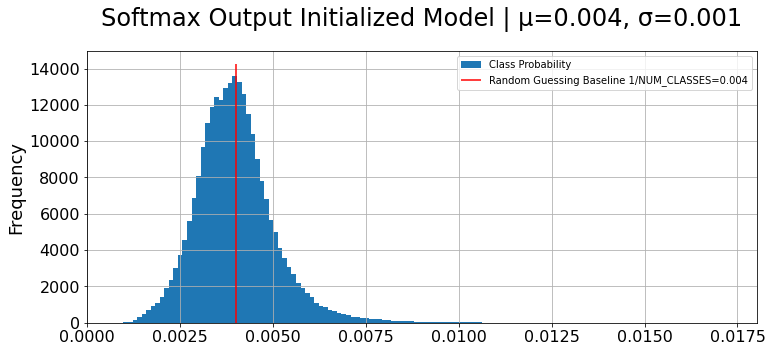

In [77]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [78]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

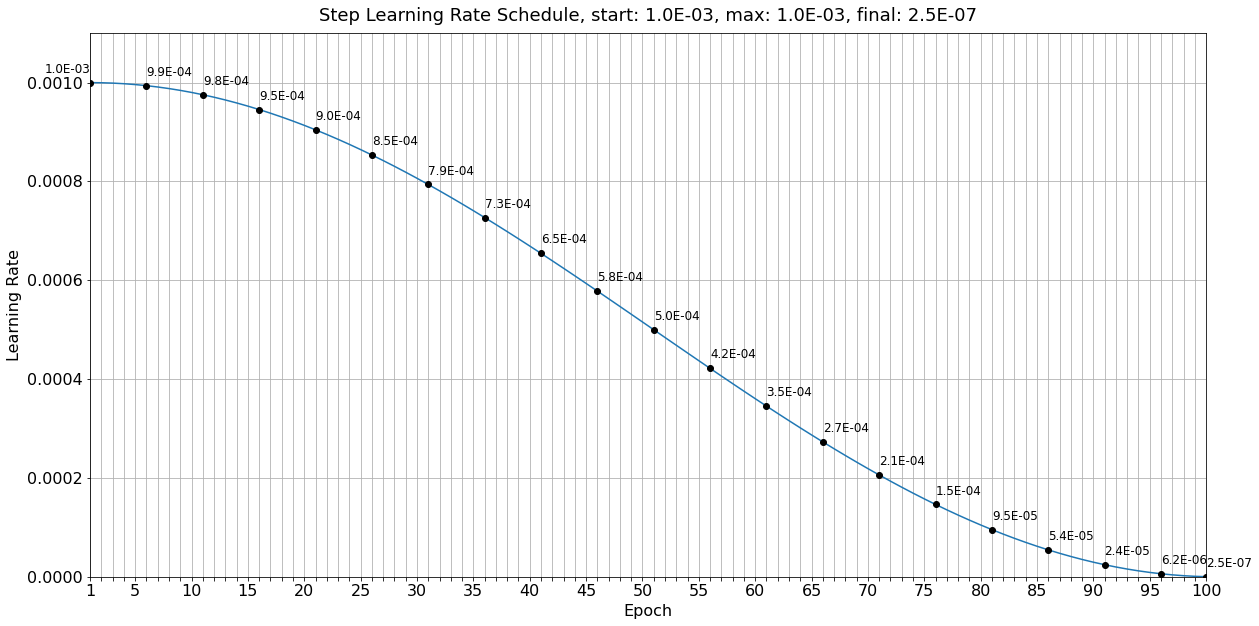

In [79]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [80]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        logger.info(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [81]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
    pass

51.7 ms ± 9.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [82]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    logger.info(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Evaluate Initialzied Model

In [83]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

# Train

In [84]:
if USE_VAL:
    save_best = tf.keras.callbacks.ModelCheckpoint(
        f"{out_root}model_best.h5", monitor="val_acc", save_best_only=True, mode="max"
    )
else:
    save_best = tf.keras.callbacks.ModelCheckpoint(
        f"{out_root}model_best.h5", monitor="acc", save_best_only=True, mode="max"
    )    

In [86]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            # validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
                save_best,
                traininglogger
            ],
            verbose = VERBOSE,
        )

(None, 32, 368, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 32)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 32)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 32)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 32, 1)        0           ['tf.cast[

[2023-05-01 11:28:30,641][__main__][on_epoch_begin][INFO] learning rate: 1.00e-03, weight decay: 5.00e-05


Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 3.6474 - acc: 0.4939 - top_5_acc: 0.7255 - top_10_acc: 0.7911

[2023-05-01 11:29:34,808][__main__][on_epoch_end][INFO] Epoch 00001
[2023-05-01 11:29:34,811][__main__][on_epoch_end][INFO]        loss: 3.64737
[2023-05-01 11:29:34,814][__main__][on_epoch_end][INFO]         acc: 0.49386
[2023-05-01 11:29:34,815][__main__][on_epoch_end][INFO]   top_5_acc: 0.72549
[2023-05-01 11:29:34,816][__main__][on_epoch_end][INFO]  top_10_acc: 0.79107
[2023-05-01 11:29:34,817][__main__][on_epoch_end][INFO]          lr: 0.00100


188/188 [==============================] - 64s 252ms/step - loss: 3.6474 - acc: 0.4939 - top_5_acc: 0.7255 - top_10_acc: 0.7911 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997532801828658.


[2023-05-01 11:29:34,833][__main__][on_epoch_begin][INFO] learning rate: 1.00e-03, weight decay: 5.00e-05


Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 2.8406 - acc: 0.7462 - top_5_acc: 0.9053 - top_10_acc: 0.9319

[2023-05-01 11:30:21,293][__main__][on_epoch_end][INFO] Epoch 00002
[2023-05-01 11:30:21,295][__main__][on_epoch_end][INFO]        loss: 2.84056
[2023-05-01 11:30:21,298][__main__][on_epoch_end][INFO]         acc: 0.74621
[2023-05-01 11:30:21,299][__main__][on_epoch_end][INFO]   top_5_acc: 0.90532
[2023-05-01 11:30:21,300][__main__][on_epoch_end][INFO]  top_10_acc: 0.93187
[2023-05-01 11:30:21,301][__main__][on_epoch_end][INFO]          lr: 0.00100


188/188 [==============================] - 46s 247ms/step - loss: 2.8406 - acc: 0.7462 - top_5_acc: 0.9053 - top_10_acc: 0.9319 - lr: 9.9975e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009990133642141358.


[2023-05-01 11:30:21,317][__main__][on_epoch_begin][INFO] learning rate: 9.99e-04, weight decay: 5.00e-05


Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 2.6541 - acc: 0.8119 - top_5_acc: 0.9338 - top_10_acc: 0.9525

[2023-05-01 11:31:07,804][__main__][on_epoch_end][INFO] Epoch 00003
[2023-05-01 11:31:07,805][__main__][on_epoch_end][INFO]        loss: 2.65405
[2023-05-01 11:31:07,807][__main__][on_epoch_end][INFO]         acc: 0.81186
[2023-05-01 11:31:07,809][__main__][on_epoch_end][INFO]   top_5_acc: 0.93377
[2023-05-01 11:31:07,810][__main__][on_epoch_end][INFO]  top_10_acc: 0.95255
[2023-05-01 11:31:07,810][__main__][on_epoch_end][INFO]          lr: 0.00100


188/188 [==============================] - 46s 247ms/step - loss: 2.6541 - acc: 0.8119 - top_5_acc: 0.9338 - top_10_acc: 0.9525 - lr: 9.9901e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00099778098230154.


[2023-05-01 11:31:07,825][__main__][on_epoch_begin][INFO] learning rate: 9.98e-04, weight decay: 4.99e-05


Epoch 4/100
188/188 [==============================] - ETA: 0s - loss: 2.5459 - acc: 0.8499 - top_5_acc: 0.9502 - top_10_acc: 0.9651

[2023-05-01 11:31:54,766][__main__][on_epoch_end][INFO] Epoch 00004
[2023-05-01 11:31:54,768][__main__][on_epoch_end][INFO]        loss: 2.54586
[2023-05-01 11:31:54,771][__main__][on_epoch_end][INFO]         acc: 0.84987
[2023-05-01 11:31:54,772][__main__][on_epoch_end][INFO]   top_5_acc: 0.95019
[2023-05-01 11:31:54,773][__main__][on_epoch_end][INFO]  top_10_acc: 0.96508
[2023-05-01 11:31:54,774][__main__][on_epoch_end][INFO]          lr: 0.00100


188/188 [==============================] - 47s 250ms/step - loss: 2.5459 - acc: 0.8499 - top_5_acc: 0.9502 - top_10_acc: 0.9651 - lr: 9.9778e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000996057350657239.


[2023-05-01 11:31:54,793][__main__][on_epoch_begin][INFO] learning rate: 9.96e-04, weight decay: 4.98e-05


Epoch 5/100
188/188 [==============================] - ETA: 0s - loss: 2.4587 - acc: 0.8798 - top_5_acc: 0.9641 - top_10_acc: 0.9754

[2023-05-01 11:32:41,398][__main__][on_epoch_end][INFO] Epoch 00005
[2023-05-01 11:32:41,400][__main__][on_epoch_end][INFO]        loss: 2.45873
[2023-05-01 11:32:41,402][__main__][on_epoch_end][INFO]         acc: 0.87978
[2023-05-01 11:32:41,403][__main__][on_epoch_end][INFO]   top_5_acc: 0.96414
[2023-05-01 11:32:41,404][__main__][on_epoch_end][INFO]  top_10_acc: 0.97543
[2023-05-01 11:32:41,405][__main__][on_epoch_end][INFO]          lr: 0.00100


188/188 [==============================] - 47s 248ms/step - loss: 2.4587 - acc: 0.8798 - top_5_acc: 0.9641 - top_10_acc: 0.9754 - lr: 9.9606e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0009938441702975688.


[2023-05-01 11:32:41,419][__main__][on_epoch_begin][INFO] learning rate: 9.94e-04, weight decay: 4.97e-05


Epoch 6/100
188/188 [==============================] - ETA: 0s - loss: 2.3966 - acc: 0.9028 - top_5_acc: 0.9735 - top_10_acc: 0.9825

[2023-05-01 11:33:27,985][__main__][on_epoch_end][INFO] Epoch 00006
[2023-05-01 11:33:27,987][__main__][on_epoch_end][INFO]        loss: 2.39661
[2023-05-01 11:33:27,989][__main__][on_epoch_end][INFO]         acc: 0.90279
[2023-05-01 11:33:27,990][__main__][on_epoch_end][INFO]   top_5_acc: 0.97351
[2023-05-01 11:33:27,992][__main__][on_epoch_end][INFO]  top_10_acc: 0.98252
[2023-05-01 11:33:27,993][__main__][on_epoch_end][INFO]          lr: 0.00099


188/188 [==============================] - 47s 248ms/step - loss: 2.3966 - acc: 0.9028 - top_5_acc: 0.9735 - top_10_acc: 0.9825 - lr: 9.9384e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0009911436253643444.


[2023-05-01 11:33:28,006][__main__][on_epoch_begin][INFO] learning rate: 9.91e-04, weight decay: 4.96e-05


Epoch 7/100
188/188 [==============================] - ETA: 0s - loss: 2.3488 - acc: 0.9196 - top_5_acc: 0.9810 - top_10_acc: 0.9879

[2023-05-01 11:34:14,610][__main__][on_epoch_end][INFO] Epoch 00007
[2023-05-01 11:34:14,612][__main__][on_epoch_end][INFO]        loss: 2.34880
[2023-05-01 11:34:14,614][__main__][on_epoch_end][INFO]         acc: 0.91957
[2023-05-01 11:34:14,615][__main__][on_epoch_end][INFO]   top_5_acc: 0.98096
[2023-05-01 11:34:14,616][__main__][on_epoch_end][INFO]  top_10_acc: 0.98790
[2023-05-01 11:34:14,617][__main__][on_epoch_end][INFO]          lr: 0.00099


188/188 [==============================] - 47s 248ms/step - loss: 2.3488 - acc: 0.9196 - top_5_acc: 0.9810 - top_10_acc: 0.9879 - lr: 9.9114e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0009879583809693738.


[2023-05-01 11:34:14,631][__main__][on_epoch_begin][INFO] learning rate: 9.88e-04, weight decay: 4.94e-05


Epoch 8/100
188/188 [==============================] - ETA: 0s - loss: 2.3103 - acc: 0.9332 - top_5_acc: 0.9855 - top_10_acc: 0.9912

[2023-05-01 11:35:01,202][__main__][on_epoch_end][INFO] Epoch 00008
[2023-05-01 11:35:01,204][__main__][on_epoch_end][INFO]        loss: 2.31029
[2023-05-01 11:35:01,206][__main__][on_epoch_end][INFO]         acc: 0.93317
[2023-05-01 11:35:01,207][__main__][on_epoch_end][INFO]   top_5_acc: 0.98548
[2023-05-01 11:35:01,208][__main__][on_epoch_end][INFO]  top_10_acc: 0.99119
[2023-05-01 11:35:01,210][__main__][on_epoch_end][INFO]          lr: 0.00099


188/188 [==============================] - 47s 248ms/step - loss: 2.3103 - acc: 0.9332 - top_5_acc: 0.9855 - top_10_acc: 0.9912 - lr: 9.8796e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0009842915805643156.


[2023-05-01 11:35:01,224][__main__][on_epoch_begin][INFO] learning rate: 9.84e-04, weight decay: 4.92e-05


Epoch 9/100
188/188 [==============================] - ETA: 0s - loss: 2.2729 - acc: 0.9451 - top_5_acc: 0.9899 - top_10_acc: 0.9943

[2023-05-01 11:35:47,754][__main__][on_epoch_end][INFO] Epoch 00009
[2023-05-01 11:35:47,756][__main__][on_epoch_end][INFO]        loss: 2.27290
[2023-05-01 11:35:47,758][__main__][on_epoch_end][INFO]         acc: 0.94506
[2023-05-01 11:35:47,759][__main__][on_epoch_end][INFO]   top_5_acc: 0.98990
[2023-05-01 11:35:47,760][__main__][on_epoch_end][INFO]  top_10_acc: 0.99435
[2023-05-01 11:35:47,760][__main__][on_epoch_end][INFO]          lr: 0.00098


188/188 [==============================] - 47s 247ms/step - loss: 2.2729 - acc: 0.9451 - top_5_acc: 0.9899 - top_10_acc: 0.9943 - lr: 9.8429e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0009801468428384716.


[2023-05-01 11:35:47,773][__main__][on_epoch_begin][INFO] learning rate: 9.80e-04, weight decay: 4.90e-05


Epoch 10/100
188/188 [==============================] - ETA: 0s - loss: 2.2403 - acc: 0.9553 - top_5_acc: 0.9930 - top_10_acc: 0.9960

[2023-05-01 11:36:34,364][__main__][on_epoch_end][INFO] Epoch 00010
[2023-05-01 11:36:34,366][__main__][on_epoch_end][INFO]        loss: 2.24030
[2023-05-01 11:36:34,368][__main__][on_epoch_end][INFO]         acc: 0.95529
[2023-05-01 11:36:34,369][__main__][on_epoch_end][INFO]   top_5_acc: 0.99297
[2023-05-01 11:36:34,370][__main__][on_epoch_end][INFO]  top_10_acc: 0.99599
[2023-05-01 11:36:34,371][__main__][on_epoch_end][INFO]          lr: 0.00098


188/188 [==============================] - 47s 248ms/step - loss: 2.2403 - acc: 0.9553 - top_5_acc: 0.9930 - top_10_acc: 0.9960 - lr: 9.8015e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0009755282581475768.


[2023-05-01 11:36:34,385][__main__][on_epoch_begin][INFO] learning rate: 9.76e-04, weight decay: 4.88e-05


Epoch 11/100
188/188 [==============================] - ETA: 0s - loss: 2.2165 - acc: 0.9630 - top_5_acc: 0.9950 - top_10_acc: 0.9972

[2023-05-01 11:37:21,024][__main__][on_epoch_end][INFO] Epoch 00011
[2023-05-01 11:37:21,026][__main__][on_epoch_end][INFO]        loss: 2.21647
[2023-05-01 11:37:21,028][__main__][on_epoch_end][INFO]         acc: 0.96304
[2023-05-01 11:37:21,029][__main__][on_epoch_end][INFO]   top_5_acc: 0.99496
[2023-05-01 11:37:21,030][__main__][on_epoch_end][INFO]  top_10_acc: 0.99723
[2023-05-01 11:37:21,031][__main__][on_epoch_end][INFO]          lr: 0.00098


188/188 [==============================] - 47s 248ms/step - loss: 2.2165 - acc: 0.9630 - top_5_acc: 0.9950 - top_10_acc: 0.9972 - lr: 9.7553e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009704403844771128.


[2023-05-01 11:37:21,046][__main__][on_epoch_begin][INFO] learning rate: 9.70e-04, weight decay: 4.85e-05


Epoch 12/100
188/188 [==============================] - ETA: 0s - loss: 2.1916 - acc: 0.9701 - top_5_acc: 0.9966 - top_10_acc: 0.9983

[2023-05-01 11:38:07,612][__main__][on_epoch_end][INFO] Epoch 00012
[2023-05-01 11:38:07,614][__main__][on_epoch_end][INFO]        loss: 2.19162
[2023-05-01 11:38:07,616][__main__][on_epoch_end][INFO]         acc: 0.97012
[2023-05-01 11:38:07,618][__main__][on_epoch_end][INFO]   top_5_acc: 0.99665
[2023-05-01 11:38:07,619][__main__][on_epoch_end][INFO]  top_10_acc: 0.99834
[2023-05-01 11:38:07,620][__main__][on_epoch_end][INFO]          lr: 0.00097


188/188 [==============================] - 47s 248ms/step - loss: 2.1916 - acc: 0.9701 - top_5_acc: 0.9966 - top_10_acc: 0.9983 - lr: 9.7044e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0009648882429441257.


[2023-05-01 11:38:07,634][__main__][on_epoch_begin][INFO] learning rate: 9.65e-04, weight decay: 4.82e-05


Epoch 13/100
188/188 [==============================] - ETA: 0s - loss: 2.1793 - acc: 0.9736 - top_5_acc: 0.9973 - top_10_acc: 0.9985

[2023-05-01 11:38:54,295][__main__][on_epoch_end][INFO] Epoch 00013
[2023-05-01 11:38:54,297][__main__][on_epoch_end][INFO]        loss: 2.17932
[2023-05-01 11:38:54,299][__main__][on_epoch_end][INFO]         acc: 0.97357
[2023-05-01 11:38:54,300][__main__][on_epoch_end][INFO]   top_5_acc: 0.99726
[2023-05-01 11:38:54,301][__main__][on_epoch_end][INFO]  top_10_acc: 0.99854
[2023-05-01 11:38:54,302][__main__][on_epoch_end][INFO]          lr: 0.00096


188/188 [==============================] - 47s 248ms/step - loss: 2.1793 - acc: 0.9736 - top_5_acc: 0.9973 - top_10_acc: 0.9985 - lr: 9.6489e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0009588773128419905.


[2023-05-01 11:38:54,318][__main__][on_epoch_begin][INFO] learning rate: 9.59e-04, weight decay: 4.79e-05


Epoch 14/100
188/188 [==============================] - ETA: 0s - loss: 2.1702 - acc: 0.9762 - top_5_acc: 0.9978 - top_10_acc: 0.9990

[2023-05-01 11:39:40,927][__main__][on_epoch_end][INFO] Epoch 00014
[2023-05-01 11:39:40,929][__main__][on_epoch_end][INFO]        loss: 2.17023
[2023-05-01 11:39:40,930][__main__][on_epoch_end][INFO]         acc: 0.97619
[2023-05-01 11:39:40,932][__main__][on_epoch_end][INFO]   top_5_acc: 0.99784
[2023-05-01 11:39:40,933][__main__][on_epoch_end][INFO]  top_10_acc: 0.99903
[2023-05-01 11:39:40,934][__main__][on_epoch_end][INFO]          lr: 0.00096


188/188 [==============================] - 47s 248ms/step - loss: 2.1702 - acc: 0.9762 - top_5_acc: 0.9978 - top_10_acc: 0.9990 - lr: 9.5888e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0009524135262330098.


[2023-05-01 11:39:40,948][__main__][on_epoch_begin][INFO] learning rate: 9.52e-04, weight decay: 4.76e-05


Epoch 15/100
188/188 [==============================] - ETA: 0s - loss: 2.1644 - acc: 0.9782 - top_5_acc: 0.9985 - top_10_acc: 0.9993

[2023-05-01 11:40:27,626][__main__][on_epoch_end][INFO] Epoch 00015
[2023-05-01 11:40:27,628][__main__][on_epoch_end][INFO]        loss: 2.16438
[2023-05-01 11:40:27,630][__main__][on_epoch_end][INFO]         acc: 0.97816
[2023-05-01 11:40:27,632][__main__][on_epoch_end][INFO]   top_5_acc: 0.99846
[2023-05-01 11:40:27,633][__main__][on_epoch_end][INFO]  top_10_acc: 0.99926
[2023-05-01 11:40:27,634][__main__][on_epoch_end][INFO]          lr: 0.00095


188/188 [==============================] - 47s 248ms/step - loss: 2.1644 - acc: 0.9782 - top_5_acc: 0.9985 - top_10_acc: 0.9993 - lr: 9.5241e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0009455032620941839.


[2023-05-01 11:40:27,648][__main__][on_epoch_begin][INFO] learning rate: 9.46e-04, weight decay: 4.73e-05


Epoch 16/100
188/188 [==============================] - ETA: 0s - loss: 2.1451 - acc: 0.9828 - top_5_acc: 0.9986 - top_10_acc: 0.9994

[2023-05-01 11:41:14,137][__main__][on_epoch_end][INFO] Epoch 00016
[2023-05-01 11:41:14,139][__main__][on_epoch_end][INFO]        loss: 2.14509
[2023-05-01 11:41:14,141][__main__][on_epoch_end][INFO]         acc: 0.98277
[2023-05-01 11:41:14,142][__main__][on_epoch_end][INFO]   top_5_acc: 0.99865
[2023-05-01 11:41:14,143][__main__][on_epoch_end][INFO]  top_10_acc: 0.99940
[2023-05-01 11:41:14,144][__main__][on_epoch_end][INFO]          lr: 0.00095


188/188 [==============================] - 46s 247ms/step - loss: 2.1451 - acc: 0.9828 - top_5_acc: 0.9986 - top_10_acc: 0.9994 - lr: 9.4550e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0009381533400219318.


[2023-05-01 11:41:14,159][__main__][on_epoch_begin][INFO] learning rate: 9.38e-04, weight decay: 4.69e-05


Epoch 17/100
188/188 [==============================] - ETA: 0s - loss: 2.1285 - acc: 0.9860 - top_5_acc: 0.9993 - top_10_acc: 0.9997

[2023-05-01 11:42:00,745][__main__][on_epoch_end][INFO] Epoch 00017
[2023-05-01 11:42:00,747][__main__][on_epoch_end][INFO]        loss: 2.12847
[2023-05-01 11:42:00,749][__main__][on_epoch_end][INFO]         acc: 0.98597
[2023-05-01 11:42:00,750][__main__][on_epoch_end][INFO]   top_5_acc: 0.99931
[2023-05-01 11:42:00,751][__main__][on_epoch_end][INFO]  top_10_acc: 0.99970
[2023-05-01 11:42:00,752][__main__][on_epoch_end][INFO]          lr: 0.00094


188/188 [==============================] - 47s 248ms/step - loss: 2.1285 - acc: 0.9860 - top_5_acc: 0.9993 - top_10_acc: 0.9997 - lr: 9.3815e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0009303710135019718.


[2023-05-01 11:42:00,766][__main__][on_epoch_begin][INFO] learning rate: 9.30e-04, weight decay: 4.65e-05


Epoch 18/100
188/188 [==============================] - ETA: 0s - loss: 2.1212 - acc: 0.9877 - top_5_acc: 0.9993 - top_10_acc: 0.9997

[2023-05-01 11:42:47,313][__main__][on_epoch_end][INFO] Epoch 00018
[2023-05-01 11:42:47,315][__main__][on_epoch_end][INFO]        loss: 2.12120
[2023-05-01 11:42:47,316][__main__][on_epoch_end][INFO]         acc: 0.98770
[2023-05-01 11:42:47,317][__main__][on_epoch_end][INFO]   top_5_acc: 0.99934
[2023-05-01 11:42:47,318][__main__][on_epoch_end][INFO]  top_10_acc: 0.99971
[2023-05-01 11:42:47,319][__main__][on_epoch_end][INFO]          lr: 0.00093


188/188 [==============================] - 47s 248ms/step - loss: 2.1212 - acc: 0.9877 - top_5_acc: 0.9993 - top_10_acc: 0.9997 - lr: 9.3037e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0009221639627510075.


[2023-05-01 11:42:47,334][__main__][on_epoch_begin][INFO] learning rate: 9.22e-04, weight decay: 4.61e-05


Epoch 19/100
188/188 [==============================] - ETA: 0s - loss: 2.1104 - acc: 0.9900 - top_5_acc: 0.9996 - top_10_acc: 0.9998

[2023-05-01 11:43:33,956][__main__][on_epoch_end][INFO] Epoch 00019
[2023-05-01 11:43:33,958][__main__][on_epoch_end][INFO]        loss: 2.11036
[2023-05-01 11:43:33,960][__main__][on_epoch_end][INFO]         acc: 0.98995
[2023-05-01 11:43:33,961][__main__][on_epoch_end][INFO]   top_5_acc: 0.99958
[2023-05-01 11:43:33,962][__main__][on_epoch_end][INFO]  top_10_acc: 0.99983
[2023-05-01 11:43:33,963][__main__][on_epoch_end][INFO]          lr: 0.00092


188/188 [==============================] - 47s 248ms/step - loss: 2.1104 - acc: 0.9900 - top_5_acc: 0.9996 - top_10_acc: 0.9998 - lr: 9.2216e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009135402871372809.


[2023-05-01 11:43:33,978][__main__][on_epoch_begin][INFO] learning rate: 9.14e-04, weight decay: 4.57e-05


Epoch 20/100
188/188 [==============================] - ETA: 0s - loss: 2.1025 - acc: 0.9909 - top_5_acc: 0.9997 - top_10_acc: 0.9999

[2023-05-01 11:44:20,602][__main__][on_epoch_end][INFO] Epoch 00020
[2023-05-01 11:44:20,604][__main__][on_epoch_end][INFO]        loss: 2.10254
[2023-05-01 11:44:20,605][__main__][on_epoch_end][INFO]         acc: 0.99094
[2023-05-01 11:44:20,606][__main__][on_epoch_end][INFO]   top_5_acc: 0.99965
[2023-05-01 11:44:20,607][__main__][on_epoch_end][INFO]  top_10_acc: 0.99986
[2023-05-01 11:44:20,608][__main__][on_epoch_end][INFO]          lr: 0.00091


188/188 [==============================] - 47s 248ms/step - loss: 2.1025 - acc: 0.9909 - top_5_acc: 0.9997 - top_10_acc: 0.9999 - lr: 9.1354e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009045084971874737.


[2023-05-01 11:44:20,622][__main__][on_epoch_begin][INFO] learning rate: 9.05e-04, weight decay: 4.52e-05


Epoch 21/100
188/188 [==============================] - ETA: 0s - loss: 2.1047 - acc: 0.9905 - top_5_acc: 0.9997 - top_10_acc: 0.9999

[2023-05-01 11:45:06,571][__main__][on_epoch_end][INFO] Epoch 00021
[2023-05-01 11:45:06,572][__main__][on_epoch_end][INFO]        loss: 2.10471
[2023-05-01 11:45:06,573][__main__][on_epoch_end][INFO]         acc: 0.99054
[2023-05-01 11:45:06,573][__main__][on_epoch_end][INFO]   top_5_acc: 0.99969
[2023-05-01 11:45:06,574][__main__][on_epoch_end][INFO]  top_10_acc: 0.99990
[2023-05-01 11:45:06,575][__main__][on_epoch_end][INFO]          lr: 0.00090


188/188 [==============================] - 46s 244ms/step - loss: 2.1047 - acc: 0.9905 - top_5_acc: 0.9997 - top_10_acc: 0.9999 - lr: 9.0451e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0008950775061878452.


[2023-05-01 11:45:06,583][__main__][on_epoch_begin][INFO] learning rate: 8.95e-04, weight decay: 4.48e-05


Epoch 22/100
188/188 [==============================] - ETA: 0s - loss: 2.1085 - acc: 0.9901 - top_5_acc: 0.9997 - top_10_acc: 0.9999

[2023-05-01 11:45:52,559][__main__][on_epoch_end][INFO] Epoch 00022
[2023-05-01 11:45:52,560][__main__][on_epoch_end][INFO]        loss: 2.10851
[2023-05-01 11:45:52,561][__main__][on_epoch_end][INFO]         acc: 0.99014
[2023-05-01 11:45:52,561][__main__][on_epoch_end][INFO]   top_5_acc: 0.99965
[2023-05-01 11:45:52,562][__main__][on_epoch_end][INFO]  top_10_acc: 0.99986
[2023-05-01 11:45:52,562][__main__][on_epoch_end][INFO]          lr: 0.00090


188/188 [==============================] - 46s 245ms/step - loss: 2.1085 - acc: 0.9901 - top_5_acc: 0.9997 - top_10_acc: 0.9999 - lr: 8.9508e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008852566213878947.


[2023-05-01 11:45:52,573][__main__][on_epoch_begin][INFO] learning rate: 8.85e-04, weight decay: 4.43e-05


Epoch 23/100
188/188 [==============================] - ETA: 0s - loss: 2.0938 - acc: 0.9925 - top_5_acc: 0.9998 - top_10_acc: 0.9999

[2023-05-01 11:46:39,099][__main__][on_epoch_end][INFO] Epoch 00023
[2023-05-01 11:46:39,101][__main__][on_epoch_end][INFO]        loss: 2.09381
[2023-05-01 11:46:39,103][__main__][on_epoch_end][INFO]         acc: 0.99247
[2023-05-01 11:46:39,104][__main__][on_epoch_end][INFO]   top_5_acc: 0.99981
[2023-05-01 11:46:39,105][__main__][on_epoch_end][INFO]  top_10_acc: 0.99995
[2023-05-01 11:46:39,106][__main__][on_epoch_end][INFO]          lr: 0.00089


188/188 [==============================] - 47s 248ms/step - loss: 2.0938 - acc: 0.9925 - top_5_acc: 0.9998 - top_10_acc: 0.9999 - lr: 8.8526e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008750555348152298.


[2023-05-01 11:46:39,120][__main__][on_epoch_begin][INFO] learning rate: 8.75e-04, weight decay: 4.38e-05


Epoch 24/100
188/188 [==============================] - ETA: 0s - loss: 2.0836 - acc: 0.9940 - top_5_acc: 0.9999 - top_10_acc: 1.0000

[2023-05-01 11:47:25,651][__main__][on_epoch_end][INFO] Epoch 00024
[2023-05-01 11:47:25,653][__main__][on_epoch_end][INFO]        loss: 2.08357
[2023-05-01 11:47:25,656][__main__][on_epoch_end][INFO]         acc: 0.99397
[2023-05-01 11:47:25,657][__main__][on_epoch_end][INFO]   top_5_acc: 0.99986
[2023-05-01 11:47:25,658][__main__][on_epoch_end][INFO]  top_10_acc: 0.99995
[2023-05-01 11:47:25,659][__main__][on_epoch_end][INFO]          lr: 0.00088


188/188 [==============================] - 47s 248ms/step - loss: 2.0836 - acc: 0.9940 - top_5_acc: 0.9999 - top_10_acc: 1.0000 - lr: 8.7506e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008644843137107057.


[2023-05-01 11:47:25,674][__main__][on_epoch_begin][INFO] learning rate: 8.64e-04, weight decay: 4.32e-05


Epoch 25/100
188/188 [==============================] - ETA: 0s - loss: 2.0775 - acc: 0.9951 - top_5_acc: 0.9999 - top_10_acc: 1.0000

[2023-05-01 11:48:12,500][__main__][on_epoch_end][INFO] Epoch 00025
[2023-05-01 11:48:12,502][__main__][on_epoch_end][INFO]        loss: 2.07747
[2023-05-01 11:48:12,505][__main__][on_epoch_end][INFO]         acc: 0.99506
[2023-05-01 11:48:12,506][__main__][on_epoch_end][INFO]   top_5_acc: 0.99988
[2023-05-01 11:48:12,507][__main__][on_epoch_end][INFO]  top_10_acc: 0.99996
[2023-05-01 11:48:12,508][__main__][on_epoch_end][INFO]          lr: 0.00086


188/188 [==============================] - 47s 249ms/step - loss: 2.0775 - acc: 0.9951 - top_5_acc: 0.9999 - top_10_acc: 1.0000 - lr: 8.6448e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008535533905932737.


[2023-05-01 11:48:12,525][__main__][on_epoch_begin][INFO] learning rate: 8.54e-04, weight decay: 4.27e-05


Epoch 26/100
188/188 [==============================] - ETA: 0s - loss: 2.0762 - acc: 0.9951 - top_5_acc: 0.9999 - top_10_acc: 1.0000

[2023-05-01 11:48:59,144][__main__][on_epoch_end][INFO] Epoch 00026
[2023-05-01 11:48:59,146][__main__][on_epoch_end][INFO]        loss: 2.07618
[2023-05-01 11:48:59,148][__main__][on_epoch_end][INFO]         acc: 0.99514
[2023-05-01 11:48:59,149][__main__][on_epoch_end][INFO]   top_5_acc: 0.99990
[2023-05-01 11:48:59,150][__main__][on_epoch_end][INFO]  top_10_acc: 0.99997
[2023-05-01 11:48:59,151][__main__][on_epoch_end][INFO]          lr: 0.00085


188/188 [==============================] - 47s 248ms/step - loss: 2.0762 - acc: 0.9951 - top_5_acc: 0.9999 - top_10_acc: 1.0000 - lr: 8.5355e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0008422735529643444.


[2023-05-01 11:48:59,166][__main__][on_epoch_begin][INFO] learning rate: 8.42e-04, weight decay: 4.21e-05


Epoch 27/100
188/188 [==============================] - ETA: 0s - loss: 2.0761 - acc: 0.9952 - top_5_acc: 0.9999 - top_10_acc: 1.0000

[2023-05-01 11:49:45,828][__main__][on_epoch_end][INFO] Epoch 00027
[2023-05-01 11:49:45,830][__main__][on_epoch_end][INFO]        loss: 2.07608
[2023-05-01 11:49:45,832][__main__][on_epoch_end][INFO]         acc: 0.99516
[2023-05-01 11:49:45,834][__main__][on_epoch_end][INFO]   top_5_acc: 0.99991
[2023-05-01 11:49:45,835][__main__][on_epoch_end][INFO]  top_10_acc: 0.99997
[2023-05-01 11:49:45,836][__main__][on_epoch_end][INFO]          lr: 0.00084


188/188 [==============================] - 47s 248ms/step - loss: 2.0761 - acc: 0.9952 - top_5_acc: 0.9999 - top_10_acc: 1.0000 - lr: 8.4227e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0008306559326618259.


[2023-05-01 11:49:45,851][__main__][on_epoch_begin][INFO] learning rate: 8.31e-04, weight decay: 4.15e-05


Epoch 28/100
188/188 [==============================] - ETA: 0s - loss: 2.0739 - acc: 0.9951 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:50:31,924][__main__][on_epoch_end][INFO] Epoch 00028
[2023-05-01 11:50:31,925][__main__][on_epoch_end][INFO]        loss: 2.07388
[2023-05-01 11:50:31,926][__main__][on_epoch_end][INFO]         acc: 0.99511
[2023-05-01 11:50:31,927][__main__][on_epoch_end][INFO]   top_5_acc: 0.99997
[2023-05-01 11:50:31,928][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 11:50:31,928][__main__][on_epoch_end][INFO]          lr: 0.00083


188/188 [==============================] - 46s 245ms/step - loss: 2.0739 - acc: 0.9951 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 8.3066e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0008187119948743449.


[2023-05-01 11:50:31,937][__main__][on_epoch_begin][INFO] learning rate: 8.19e-04, weight decay: 4.09e-05


Epoch 29/100
188/188 [==============================] - ETA: 0s - loss: 2.0653 - acc: 0.9964 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:51:18,511][__main__][on_epoch_end][INFO] Epoch 00029
[2023-05-01 11:51:18,513][__main__][on_epoch_end][INFO]        loss: 2.06526
[2023-05-01 11:51:18,515][__main__][on_epoch_end][INFO]         acc: 0.99635
[2023-05-01 11:51:18,516][__main__][on_epoch_end][INFO]   top_5_acc: 0.99995
[2023-05-01 11:51:18,517][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 11:51:18,518][__main__][on_epoch_end][INFO]          lr: 0.00082


188/188 [==============================] - 47s 248ms/step - loss: 2.0653 - acc: 0.9964 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 8.1871e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0008064535268264883.


[2023-05-01 11:51:18,533][__main__][on_epoch_begin][INFO] learning rate: 8.06e-04, weight decay: 4.03e-05


Epoch 30/100
188/188 [==============================] - ETA: 0s - loss: 2.0633 - acc: 0.9965 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:52:05,110][__main__][on_epoch_end][INFO] Epoch 00030
[2023-05-01 11:52:05,112][__main__][on_epoch_end][INFO]        loss: 2.06332
[2023-05-01 11:52:05,114][__main__][on_epoch_end][INFO]         acc: 0.99648
[2023-05-01 11:52:05,115][__main__][on_epoch_end][INFO]   top_5_acc: 0.99996
[2023-05-01 11:52:05,116][__main__][on_epoch_end][INFO]  top_10_acc: 0.99998
[2023-05-01 11:52:05,117][__main__][on_epoch_end][INFO]          lr: 0.00081


188/188 [==============================] - 47s 248ms/step - loss: 2.0633 - acc: 0.9965 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 8.0645e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0007938926261462366.


[2023-05-01 11:52:05,132][__main__][on_epoch_begin][INFO] learning rate: 7.94e-04, weight decay: 3.97e-05


Epoch 31/100
188/188 [==============================] - ETA: 0s - loss: 2.0581 - acc: 0.9971 - top_5_acc: 0.9999 - top_10_acc: 1.0000

[2023-05-01 11:52:51,780][__main__][on_epoch_end][INFO] Epoch 00031
[2023-05-01 11:52:51,782][__main__][on_epoch_end][INFO]        loss: 2.05815
[2023-05-01 11:52:51,784][__main__][on_epoch_end][INFO]         acc: 0.99711
[2023-05-01 11:52:51,786][__main__][on_epoch_end][INFO]   top_5_acc: 0.99995
[2023-05-01 11:52:51,787][__main__][on_epoch_end][INFO]  top_10_acc: 0.99998
[2023-05-01 11:52:51,788][__main__][on_epoch_end][INFO]          lr: 0.00079


188/188 [==============================] - 47s 248ms/step - loss: 2.0581 - acc: 0.9971 - top_5_acc: 0.9999 - top_10_acc: 1.0000 - lr: 7.9389e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0007810416889260653.


[2023-05-01 11:52:51,802][__main__][on_epoch_begin][INFO] learning rate: 7.81e-04, weight decay: 3.91e-05


Epoch 32/100
188/188 [==============================] - ETA: 0s - loss: 2.0522 - acc: 0.9974 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:53:38,551][__main__][on_epoch_end][INFO] Epoch 00032
[2023-05-01 11:53:38,553][__main__][on_epoch_end][INFO]        loss: 2.05225
[2023-05-01 11:53:38,556][__main__][on_epoch_end][INFO]         acc: 0.99743
[2023-05-01 11:53:38,557][__main__][on_epoch_end][INFO]   top_5_acc: 0.99996
[2023-05-01 11:53:38,558][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 11:53:38,559][__main__][on_epoch_end][INFO]          lr: 0.00078


188/188 [==============================] - 47s 249ms/step - loss: 2.0522 - acc: 0.9974 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.8104e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0007679133974894983.


[2023-05-01 11:53:38,577][__main__][on_epoch_begin][INFO] learning rate: 7.68e-04, weight decay: 3.84e-05


Epoch 33/100
188/188 [==============================] - ETA: 0s - loss: 2.0500 - acc: 0.9977 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:54:25,197][__main__][on_epoch_end][INFO] Epoch 00033
[2023-05-01 11:54:25,199][__main__][on_epoch_end][INFO]        loss: 2.05005
[2023-05-01 11:54:25,201][__main__][on_epoch_end][INFO]         acc: 0.99772
[2023-05-01 11:54:25,202][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 11:54:25,203][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 11:54:25,204][__main__][on_epoch_end][INFO]          lr: 0.00077


188/188 [==============================] - 47s 248ms/step - loss: 2.0500 - acc: 0.9977 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.6791e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0007545207078751857.


[2023-05-01 11:54:25,218][__main__][on_epoch_begin][INFO] learning rate: 7.55e-04, weight decay: 3.77e-05


Epoch 34/100
188/188 [==============================] - ETA: 0s - loss: 2.0459 - acc: 0.9979 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:55:11,918][__main__][on_epoch_end][INFO] Epoch 00034
[2023-05-01 11:55:11,920][__main__][on_epoch_end][INFO]        loss: 2.04586
[2023-05-01 11:55:11,922][__main__][on_epoch_end][INFO]         acc: 0.99787
[2023-05-01 11:55:11,923][__main__][on_epoch_end][INFO]   top_5_acc: 0.99998
[2023-05-01 11:55:11,924][__main__][on_epoch_end][INFO]  top_10_acc: 0.99998
[2023-05-01 11:55:11,925][__main__][on_epoch_end][INFO]          lr: 0.00075


188/188 [==============================] - 47s 248ms/step - loss: 2.0459 - acc: 0.9979 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.5452e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0007408768370508576.


[2023-05-01 11:55:11,943][__main__][on_epoch_begin][INFO] learning rate: 7.41e-04, weight decay: 3.70e-05


Epoch 35/100
188/188 [==============================] - ETA: 0s - loss: 2.0411 - acc: 0.9984 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:55:58,958][__main__][on_epoch_end][INFO] Epoch 00035
[2023-05-01 11:55:58,961][__main__][on_epoch_end][INFO]        loss: 2.04105
[2023-05-01 11:55:58,963][__main__][on_epoch_end][INFO]         acc: 0.99838
[2023-05-01 11:55:58,965][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 11:55:58,966][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 11:55:58,967][__main__][on_epoch_end][INFO]          lr: 0.00074


188/188 [==============================] - 47s 250ms/step - loss: 2.0411 - acc: 0.9984 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.4088e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0007269952498697733.


[2023-05-01 11:55:58,981][__main__][on_epoch_begin][INFO] learning rate: 7.27e-04, weight decay: 3.63e-05


Epoch 36/100
188/188 [==============================] - ETA: 0s - loss: 2.0373 - acc: 0.9986 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:56:45,640][__main__][on_epoch_end][INFO] Epoch 00036
[2023-05-01 11:56:45,641][__main__][on_epoch_end][INFO]        loss: 2.03733
[2023-05-01 11:56:45,643][__main__][on_epoch_end][INFO]         acc: 0.99860
[2023-05-01 11:56:45,644][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 11:56:45,646][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 11:56:45,647][__main__][on_epoch_end][INFO]          lr: 0.00073


188/188 [==============================] - 47s 248ms/step - loss: 2.0373 - acc: 0.9986 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.2700e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0007128896457825364.


[2023-05-01 11:56:45,661][__main__][on_epoch_begin][INFO] learning rate: 7.13e-04, weight decay: 3.56e-05


Epoch 37/100
188/188 [==============================] - ETA: 0s - loss: 2.0362 - acc: 0.9986 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:57:32,270][__main__][on_epoch_end][INFO] Epoch 00037
[2023-05-01 11:57:32,272][__main__][on_epoch_end][INFO]        loss: 2.03621
[2023-05-01 11:57:32,274][__main__][on_epoch_end][INFO]         acc: 0.99863
[2023-05-01 11:57:32,275][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 11:57:32,276][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 11:57:32,277][__main__][on_epoch_end][INFO]          lr: 0.00071


188/188 [==============================] - 47s 248ms/step - loss: 2.0362 - acc: 0.9986 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.1289e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006985739453173903.


[2023-05-01 11:57:32,292][__main__][on_epoch_begin][INFO] learning rate: 6.99e-04, weight decay: 3.49e-05


Epoch 38/100
188/188 [==============================] - ETA: 0s - loss: 2.0354 - acc: 0.9987 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:58:18,916][__main__][on_epoch_end][INFO] Epoch 00038
[2023-05-01 11:58:18,918][__main__][on_epoch_end][INFO]        loss: 2.03541
[2023-05-01 11:58:18,920][__main__][on_epoch_end][INFO]         acc: 0.99868
[2023-05-01 11:58:18,921][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 11:58:18,922][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 11:58:18,923][__main__][on_epoch_end][INFO]          lr: 0.00070


188/188 [==============================] - 47s 248ms/step - loss: 2.0354 - acc: 0.9987 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.9857e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006840622763423391.


[2023-05-01 11:58:18,938][__main__][on_epoch_begin][INFO] learning rate: 6.84e-04, weight decay: 3.42e-05


Epoch 39/100
188/188 [==============================] - ETA: 0s - loss: 2.0319 - acc: 0.9989 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:59:05,555][__main__][on_epoch_end][INFO] Epoch 00039
[2023-05-01 11:59:05,556][__main__][on_epoch_end][INFO]        loss: 2.03192
[2023-05-01 11:59:05,559][__main__][on_epoch_end][INFO]         acc: 0.99889
[2023-05-01 11:59:05,560][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 11:59:05,561][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 11:59:05,562][__main__][on_epoch_end][INFO]          lr: 0.00068


188/188 [==============================] - 47s 248ms/step - loss: 2.0319 - acc: 0.9989 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.8406e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006693689601226458.


[2023-05-01 11:59:05,576][__main__][on_epoch_begin][INFO] learning rate: 6.69e-04, weight decay: 3.35e-05


Epoch 40/100
188/188 [==============================] - ETA: 0s - loss: 2.0288 - acc: 0.9990 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 11:59:52,362][__main__][on_epoch_end][INFO] Epoch 00040
[2023-05-01 11:59:52,364][__main__][on_epoch_end][INFO]        loss: 2.02884
[2023-05-01 11:59:52,366][__main__][on_epoch_end][INFO]         acc: 0.99901
[2023-05-01 11:59:52,367][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 11:59:52,368][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 11:59:52,369][__main__][on_epoch_end][INFO]          lr: 0.00067


188/188 [==============================] - 47s 249ms/step - loss: 2.0288 - acc: 0.9990 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.6937e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0006545084971874737.


[2023-05-01 11:59:52,384][__main__][on_epoch_begin][INFO] learning rate: 6.55e-04, weight decay: 3.27e-05


Epoch 41/100
188/188 [==============================] - ETA: 0s - loss: 2.0249 - acc: 0.9992 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:00:38,952][__main__][on_epoch_end][INFO] Epoch 00041
[2023-05-01 12:00:38,954][__main__][on_epoch_end][INFO]        loss: 2.02492
[2023-05-01 12:00:38,956][__main__][on_epoch_end][INFO]         acc: 0.99918
[2023-05-01 12:00:38,957][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:00:38,958][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:00:38,959][__main__][on_epoch_end][INFO]          lr: 0.00065


188/188 [==============================] - 47s 248ms/step - loss: 2.0249 - acc: 0.9992 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.5451e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0006394955530196147.


[2023-05-01 12:00:38,974][__main__][on_epoch_begin][INFO] learning rate: 6.39e-04, weight decay: 3.20e-05


Epoch 42/100
188/188 [==============================] - ETA: 0s - loss: 2.0202 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:01:25,645][__main__][on_epoch_end][INFO] Epoch 00042
[2023-05-01 12:01:25,647][__main__][on_epoch_end][INFO]        loss: 2.02021
[2023-05-01 12:01:25,649][__main__][on_epoch_end][INFO]         acc: 0.99945
[2023-05-01 12:01:25,651][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:01:25,652][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:01:25,653][__main__][on_epoch_end][INFO]          lr: 0.00064


188/188 [==============================] - 47s 248ms/step - loss: 2.0202 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.3950e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0006243449435824276.


[2023-05-01 12:01:25,670][__main__][on_epoch_begin][INFO] learning rate: 6.24e-04, weight decay: 3.12e-05


Epoch 43/100
188/188 [==============================] - ETA: 0s - loss: 2.0198 - acc: 0.9993 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:02:11,643][__main__][on_epoch_end][INFO] Epoch 00043
[2023-05-01 12:02:11,644][__main__][on_epoch_end][INFO]        loss: 2.01982
[2023-05-01 12:02:11,645][__main__][on_epoch_end][INFO]         acc: 0.99931
[2023-05-01 12:02:11,645][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:02:11,646][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:02:11,647][__main__][on_epoch_end][INFO]          lr: 0.00062


188/188 [==============================] - 46s 244ms/step - loss: 2.0198 - acc: 0.9993 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.2434e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0006090716206982714.


[2023-05-01 12:02:11,656][__main__][on_epoch_begin][INFO] learning rate: 6.09e-04, weight decay: 3.05e-05


Epoch 44/100
188/188 [==============================] - ETA: 0s - loss: 2.0164 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:02:58,316][__main__][on_epoch_end][INFO] Epoch 00044
[2023-05-01 12:02:58,318][__main__][on_epoch_end][INFO]        loss: 2.01638
[2023-05-01 12:02:58,321][__main__][on_epoch_end][INFO]         acc: 0.99952
[2023-05-01 12:02:58,322][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:02:58,323][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:02:58,324][__main__][on_epoch_end][INFO]          lr: 0.00061


188/188 [==============================] - 47s 248ms/step - loss: 2.0164 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.0907e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0005936906572928624.


[2023-05-01 12:02:58,343][__main__][on_epoch_begin][INFO] learning rate: 5.94e-04, weight decay: 2.97e-05


Epoch 45/100
188/188 [==============================] - ETA: 0s - loss: 2.0133 - acc: 0.9996 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:03:45,125][__main__][on_epoch_end][INFO] Epoch 00045
[2023-05-01 12:03:45,127][__main__][on_epoch_end][INFO]        loss: 2.01327
[2023-05-01 12:03:45,130][__main__][on_epoch_end][INFO]         acc: 0.99957
[2023-05-01 12:03:45,132][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:03:45,133][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:03:45,134][__main__][on_epoch_end][INFO]          lr: 0.00059


188/188 [==============================] - 47s 249ms/step - loss: 2.0133 - acc: 0.9996 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.9369e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0005782172325201155.


[2023-05-01 12:03:45,150][__main__][on_epoch_begin][INFO] learning rate: 5.78e-04, weight decay: 2.89e-05


Epoch 46/100
188/188 [==============================] - ETA: 0s - loss: 2.0122 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:04:31,094][__main__][on_epoch_end][INFO] Epoch 00046
[2023-05-01 12:04:31,095][__main__][on_epoch_end][INFO]        loss: 2.01219
[2023-05-01 12:04:31,096][__main__][on_epoch_end][INFO]         acc: 0.99949
[2023-05-01 12:04:31,098][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 12:04:31,099][__main__][on_epoch_end][INFO]  top_10_acc: 0.99999
[2023-05-01 12:04:31,100][__main__][on_epoch_end][INFO]          lr: 0.00058


188/188 [==============================] - 46s 244ms/step - loss: 2.0122 - acc: 0.9995 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.7822e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0005626666167821521.


[2023-05-01 12:04:31,113][__main__][on_epoch_begin][INFO] learning rate: 5.63e-04, weight decay: 2.81e-05


Epoch 47/100
188/188 [==============================] - ETA: 0s - loss: 2.0113 - acc: 0.9996 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:05:18,039][__main__][on_epoch_end][INFO] Epoch 00047
[2023-05-01 12:05:18,041][__main__][on_epoch_end][INFO]        loss: 2.01126
[2023-05-01 12:05:18,043][__main__][on_epoch_end][INFO]         acc: 0.99960
[2023-05-01 12:05:18,044][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:05:18,045][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:05:18,046][__main__][on_epoch_end][INFO]          lr: 0.00056


188/188 [==============================] - 47s 250ms/step - loss: 2.0113 - acc: 0.9996 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.6267e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0005470541566592572.


[2023-05-01 12:05:18,060][__main__][on_epoch_begin][INFO] learning rate: 5.47e-04, weight decay: 2.74e-05


Epoch 48/100
188/188 [==============================] - ETA: 0s - loss: 2.0084 - acc: 0.9997 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:06:04,891][__main__][on_epoch_end][INFO] Epoch 00048
[2023-05-01 12:06:04,893][__main__][on_epoch_end][INFO]        loss: 2.00836
[2023-05-01 12:06:04,895][__main__][on_epoch_end][INFO]         acc: 0.99970
[2023-05-01 12:06:04,897][__main__][on_epoch_end][INFO]   top_5_acc: 0.99999
[2023-05-01 12:06:04,899][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:06:04,900][__main__][on_epoch_end][INFO]          lr: 0.00055


188/188 [==============================] - 47s 249ms/step - loss: 2.0084 - acc: 0.9997 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.4705e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005313952597646568.


[2023-05-01 12:06:04,916][__main__][on_epoch_begin][INFO] learning rate: 5.31e-04, weight decay: 2.66e-05


Epoch 49/100
188/188 [==============================] - ETA: 0s - loss: 2.0048 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:06:51,664][__main__][on_epoch_end][INFO] Epoch 00049
[2023-05-01 12:06:51,666][__main__][on_epoch_end][INFO]        loss: 2.00483
[2023-05-01 12:06:51,669][__main__][on_epoch_end][INFO]         acc: 0.99977
[2023-05-01 12:06:51,671][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:06:51,672][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:06:51,673][__main__][on_epoch_end][INFO]          lr: 0.00053


188/188 [==============================] - 47s 249ms/step - loss: 2.0048 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.3140e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0005157053795390641.


[2023-05-01 12:06:51,689][__main__][on_epoch_begin][INFO] learning rate: 5.16e-04, weight decay: 2.58e-05


Epoch 50/100
188/188 [==============================] - ETA: 0s - loss: 2.0027 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:07:38,737][__main__][on_epoch_end][INFO] Epoch 00050
[2023-05-01 12:07:38,740][__main__][on_epoch_end][INFO]        loss: 2.00266
[2023-05-01 12:07:38,742][__main__][on_epoch_end][INFO]         acc: 0.99979
[2023-05-01 12:07:38,744][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:07:38,745][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:07:38,745][__main__][on_epoch_end][INFO]          lr: 0.00052


188/188 [==============================] - 47s 250ms/step - loss: 2.0027 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.1571e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0005.


[2023-05-01 12:07:38,763][__main__][on_epoch_begin][INFO] learning rate: 5.00e-04, weight decay: 2.50e-05


Epoch 51/100
188/188 [==============================] - ETA: 0s - loss: 2.0006 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:08:25,806][__main__][on_epoch_end][INFO] Epoch 00051
[2023-05-01 12:08:25,808][__main__][on_epoch_end][INFO]        loss: 2.00061
[2023-05-01 12:08:25,810][__main__][on_epoch_end][INFO]         acc: 0.99984
[2023-05-01 12:08:25,812][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:08:25,813][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:08:25,814][__main__][on_epoch_end][INFO]          lr: 0.00050


188/188 [==============================] - 47s 250ms/step - loss: 2.0006 - acc: 0.9998 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.00048429462046093585.


[2023-05-01 12:08:25,832][__main__][on_epoch_begin][INFO] learning rate: 4.84e-04, weight decay: 2.42e-05


Epoch 52/100
188/188 [==============================] - ETA: 0s - loss: 1.9982 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:09:12,745][__main__][on_epoch_end][INFO] Epoch 00052
[2023-05-01 12:09:12,747][__main__][on_epoch_end][INFO]        loss: 1.99820
[2023-05-01 12:09:12,749][__main__][on_epoch_end][INFO]         acc: 0.99986
[2023-05-01 12:09:12,750][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:09:12,751][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:09:12,752][__main__][on_epoch_end][INFO]          lr: 0.00048


188/188 [==============================] - 47s 249ms/step - loss: 1.9982 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.8429e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0004686047402353433.


[2023-05-01 12:09:12,768][__main__][on_epoch_begin][INFO] learning rate: 4.69e-04, weight decay: 2.34e-05


Epoch 53/100
188/188 [==============================] - ETA: 0s - loss: 1.9950 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:09:59,722][__main__][on_epoch_end][INFO] Epoch 00053
[2023-05-01 12:09:59,724][__main__][on_epoch_end][INFO]        loss: 1.99496
[2023-05-01 12:09:59,726][__main__][on_epoch_end][INFO]         acc: 0.99993
[2023-05-01 12:09:59,728][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:09:59,729][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:09:59,730][__main__][on_epoch_end][INFO]          lr: 0.00047


188/188 [==============================] - 47s 250ms/step - loss: 1.9950 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.6860e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.00045294584334074284.


[2023-05-01 12:09:59,747][__main__][on_epoch_begin][INFO] learning rate: 4.53e-04, weight decay: 2.26e-05


Epoch 54/100
188/188 [==============================] - ETA: 0s - loss: 1.9936 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:10:45,685][__main__][on_epoch_end][INFO] Epoch 00054
[2023-05-01 12:10:45,686][__main__][on_epoch_end][INFO]        loss: 1.99364
[2023-05-01 12:10:45,687][__main__][on_epoch_end][INFO]         acc: 0.99993
[2023-05-01 12:10:45,688][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:10:45,688][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:10:45,689][__main__][on_epoch_end][INFO]          lr: 0.00045


188/188 [==============================] - 46s 244ms/step - loss: 1.9936 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.5295e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.00043733338321784784.


[2023-05-01 12:10:45,701][__main__][on_epoch_begin][INFO] learning rate: 4.37e-04, weight decay: 2.19e-05


Epoch 55/100
188/188 [==============================] - ETA: 0s - loss: 1.9917 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:11:32,590][__main__][on_epoch_end][INFO] Epoch 00055
[2023-05-01 12:11:32,592][__main__][on_epoch_end][INFO]        loss: 1.99166
[2023-05-01 12:11:32,594][__main__][on_epoch_end][INFO]         acc: 0.99995
[2023-05-01 12:11:32,595][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:11:32,596][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:11:32,597][__main__][on_epoch_end][INFO]          lr: 0.00044


188/188 [==============================] - 47s 249ms/step - loss: 1.9917 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.3733e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0004217827674798845.


[2023-05-01 12:11:32,614][__main__][on_epoch_begin][INFO] learning rate: 4.22e-04, weight decay: 2.11e-05


Epoch 56/100
188/188 [==============================] - ETA: 0s - loss: 1.9902 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:12:19,613][__main__][on_epoch_end][INFO] Epoch 00056
[2023-05-01 12:12:19,614][__main__][on_epoch_end][INFO]        loss: 1.99015
[2023-05-01 12:12:19,617][__main__][on_epoch_end][INFO]         acc: 0.99996
[2023-05-01 12:12:19,619][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:12:19,620][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:12:19,621][__main__][on_epoch_end][INFO]          lr: 0.00042


188/188 [==============================] - 47s 250ms/step - loss: 1.9902 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.2178e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0004063093427071376.


[2023-05-01 12:12:19,637][__main__][on_epoch_begin][INFO] learning rate: 4.06e-04, weight decay: 2.03e-05


Epoch 57/100
188/188 [==============================] - ETA: 0s - loss: 1.9891 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:13:05,681][__main__][on_epoch_end][INFO] Epoch 00057
[2023-05-01 12:13:05,682][__main__][on_epoch_end][INFO]        loss: 1.98913
[2023-05-01 12:13:05,683][__main__][on_epoch_end][INFO]         acc: 0.99995
[2023-05-01 12:13:05,684][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:13:05,685][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:13:05,685][__main__][on_epoch_end][INFO]          lr: 0.00041


188/188 [==============================] - 46s 245ms/step - loss: 1.9891 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.0631e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003909283793017289.


[2023-05-01 12:13:05,696][__main__][on_epoch_begin][INFO] learning rate: 3.91e-04, weight decay: 1.95e-05


Epoch 58/100
188/188 [==============================] - ETA: 0s - loss: 1.9868 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:13:52,605][__main__][on_epoch_end][INFO] Epoch 00058
[2023-05-01 12:13:52,607][__main__][on_epoch_end][INFO]        loss: 1.98678
[2023-05-01 12:13:52,610][__main__][on_epoch_end][INFO]         acc: 0.99996
[2023-05-01 12:13:52,611][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:13:52,612][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:13:52,613][__main__][on_epoch_end][INFO]          lr: 0.00039


188/188 [==============================] - 47s 250ms/step - loss: 1.9868 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.9093e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0003756550564175727.


[2023-05-01 12:13:52,629][__main__][on_epoch_begin][INFO] learning rate: 3.76e-04, weight decay: 1.88e-05


Epoch 59/100
188/188 [==============================] - ETA: 0s - loss: 1.9853 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:14:39,489][__main__][on_epoch_end][INFO] Epoch 00059
[2023-05-01 12:14:39,491][__main__][on_epoch_end][INFO]        loss: 1.98525
[2023-05-01 12:14:39,493][__main__][on_epoch_end][INFO]         acc: 0.99997
[2023-05-01 12:14:39,495][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:14:39,496][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:14:39,497][__main__][on_epoch_end][INFO]          lr: 0.00038


188/188 [==============================] - 47s 249ms/step - loss: 1.9853 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.7566e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0003605044469803854.


[2023-05-01 12:14:39,515][__main__][on_epoch_begin][INFO] learning rate: 3.61e-04, weight decay: 1.80e-05


Epoch 60/100
188/188 [==============================] - ETA: 0s - loss: 1.9835 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:15:25,546][__main__][on_epoch_end][INFO] Epoch 00060
[2023-05-01 12:15:25,547][__main__][on_epoch_end][INFO]        loss: 1.98351
[2023-05-01 12:15:25,548][__main__][on_epoch_end][INFO]         acc: 0.99995
[2023-05-01 12:15:25,549][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:15:25,549][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:15:25,550][__main__][on_epoch_end][INFO]          lr: 0.00036


188/188 [==============================] - 46s 245ms/step - loss: 1.9835 - acc: 0.9999 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.6050e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.00034549150281252633.


[2023-05-01 12:15:25,561][__main__][on_epoch_begin][INFO] learning rate: 3.45e-04, weight decay: 1.73e-05


Epoch 61/100
188/188 [==============================] - ETA: 0s - loss: 1.9814 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:16:11,489][__main__][on_epoch_end][INFO] Epoch 00061
[2023-05-01 12:16:11,490][__main__][on_epoch_end][INFO]        loss: 1.98143
[2023-05-01 12:16:11,490][__main__][on_epoch_end][INFO]         acc: 0.99997
[2023-05-01 12:16:11,491][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:16:11,492][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:16:11,493][__main__][on_epoch_end][INFO]          lr: 0.00035


188/188 [==============================] - 46s 244ms/step - loss: 1.9814 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.4549e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0003306310398773543.


[2023-05-01 12:16:11,502][__main__][on_epoch_begin][INFO] learning rate: 3.31e-04, weight decay: 1.65e-05


Epoch 62/100
188/188 [==============================] - ETA: 0s - loss: 1.9801 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:16:57,533][__main__][on_epoch_end][INFO] Epoch 00062
[2023-05-01 12:16:57,534][__main__][on_epoch_end][INFO]        loss: 1.98015
[2023-05-01 12:16:57,535][__main__][on_epoch_end][INFO]         acc: 0.99996
[2023-05-01 12:16:57,536][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:16:57,537][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:16:57,538][__main__][on_epoch_end][INFO]          lr: 0.00033


188/188 [==============================] - 46s 245ms/step - loss: 1.9801 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.3063e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.00031593772365766105.


[2023-05-01 12:16:57,551][__main__][on_epoch_begin][INFO] learning rate: 3.16e-04, weight decay: 1.58e-05


Epoch 63/100
188/188 [==============================] - ETA: 0s - loss: 1.9786 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:17:44,327][__main__][on_epoch_end][INFO] Epoch 00063
[2023-05-01 12:17:44,329][__main__][on_epoch_end][INFO]        loss: 1.97864
[2023-05-01 12:17:44,332][__main__][on_epoch_end][INFO]         acc: 0.99998
[2023-05-01 12:17:44,333][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:17:44,334][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:17:44,335][__main__][on_epoch_end][INFO]          lr: 0.00032


188/188 [==============================] - 47s 249ms/step - loss: 1.9786 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.1594e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.00030142605468260977.


[2023-05-01 12:17:44,352][__main__][on_epoch_begin][INFO] learning rate: 3.01e-04, weight decay: 1.51e-05


Epoch 64/100
188/188 [==============================] - ETA: 0s - loss: 1.9775 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:18:31,079][__main__][on_epoch_end][INFO] Epoch 00064
[2023-05-01 12:18:31,081][__main__][on_epoch_end][INFO]        loss: 1.97749
[2023-05-01 12:18:31,084][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:18:31,085][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:18:31,086][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:18:31,087][__main__][on_epoch_end][INFO]          lr: 0.00030


188/188 [==============================] - 47s 249ms/step - loss: 1.9775 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.0143e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.00028711035421746366.


[2023-05-01 12:18:31,103][__main__][on_epoch_begin][INFO] learning rate: 2.87e-04, weight decay: 1.44e-05


Epoch 65/100
188/188 [==============================] - ETA: 0s - loss: 1.9764 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:19:17,109][__main__][on_epoch_end][INFO] Epoch 00065
[2023-05-01 12:19:17,110][__main__][on_epoch_end][INFO]        loss: 1.97637
[2023-05-01 12:19:17,110][__main__][on_epoch_end][INFO]         acc: 0.99998
[2023-05-01 12:19:17,111][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:19:17,113][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:19:17,114][__main__][on_epoch_end][INFO]          lr: 0.00029


188/188 [==============================] - 46s 245ms/step - loss: 1.9764 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.8711e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.00027300475013022663.


[2023-05-01 12:19:17,127][__main__][on_epoch_begin][INFO] learning rate: 2.73e-04, weight decay: 1.37e-05


Epoch 66/100
188/188 [==============================] - ETA: 0s - loss: 1.9747 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:20:03,043][__main__][on_epoch_end][INFO] Epoch 00066
[2023-05-01 12:20:03,044][__main__][on_epoch_end][INFO]        loss: 1.97473
[2023-05-01 12:20:03,045][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:20:03,046][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:20:03,047][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:20:03,048][__main__][on_epoch_end][INFO]          lr: 0.00027


188/188 [==============================] - 46s 244ms/step - loss: 1.9747 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.7300e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0002591231629491423.


[2023-05-01 12:20:03,056][__main__][on_epoch_begin][INFO] learning rate: 2.59e-04, weight decay: 1.30e-05


Epoch 67/100
188/188 [==============================] - ETA: 0s - loss: 1.9737 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:20:50,716][__main__][on_epoch_end][INFO] Epoch 00067
[2023-05-01 12:20:50,718][__main__][on_epoch_end][INFO]        loss: 1.97370
[2023-05-01 12:20:50,720][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:20:50,722][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:20:50,723][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:20:50,724][__main__][on_epoch_end][INFO]          lr: 0.00026


188/188 [==============================] - 48s 254ms/step - loss: 1.9737 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.5912e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.00024547929212481435.


[2023-05-01 12:20:50,742][__main__][on_epoch_begin][INFO] learning rate: 2.45e-04, weight decay: 1.23e-05


Epoch 68/100
188/188 [==============================] - ETA: 0s - loss: 1.9727 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:21:36,775][__main__][on_epoch_end][INFO] Epoch 00068
[2023-05-01 12:21:36,776][__main__][on_epoch_end][INFO]        loss: 1.97266
[2023-05-01 12:21:36,776][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:21:36,777][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:21:36,778][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:21:36,778][__main__][on_epoch_end][INFO]          lr: 0.00025


188/188 [==============================] - 46s 245ms/step - loss: 1.9727 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.4548e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.00023208660251050156.


[2023-05-01 12:21:36,787][__main__][on_epoch_begin][INFO] learning rate: 2.32e-04, weight decay: 1.16e-05


Epoch 69/100
188/188 [==============================] - ETA: 0s - loss: 1.9714 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:22:22,842][__main__][on_epoch_end][INFO] Epoch 00069
[2023-05-01 12:22:22,843][__main__][on_epoch_end][INFO]        loss: 1.97141
[2023-05-01 12:22:22,844][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:22:22,845][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:22:22,846][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:22:22,846][__main__][on_epoch_end][INFO]          lr: 0.00023


188/188 [==============================] - 46s 245ms/step - loss: 1.9714 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.3209e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0002189583110739348.


[2023-05-01 12:22:22,855][__main__][on_epoch_begin][INFO] learning rate: 2.19e-04, weight decay: 1.09e-05


Epoch 70/100
188/188 [==============================] - ETA: 0s - loss: 1.9704 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:23:08,886][__main__][on_epoch_end][INFO] Epoch 00070
[2023-05-01 12:23:08,887][__main__][on_epoch_end][INFO]        loss: 1.97041
[2023-05-01 12:23:08,888][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:23:08,889][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:23:08,889][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:23:08,890][__main__][on_epoch_end][INFO]          lr: 0.00022


188/188 [==============================] - 46s 245ms/step - loss: 1.9704 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.1896e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.00020610737385376348.


[2023-05-01 12:23:08,901][__main__][on_epoch_begin][INFO] learning rate: 2.06e-04, weight decay: 1.03e-05


Epoch 71/100
188/188 [==============================] - ETA: 0s - loss: 1.9693 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:23:54,937][__main__][on_epoch_end][INFO] Epoch 00071
[2023-05-01 12:23:54,938][__main__][on_epoch_end][INFO]        loss: 1.96932
[2023-05-01 12:23:54,938][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:23:54,939][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:23:54,940][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:23:54,941][__main__][on_epoch_end][INFO]          lr: 0.00021


188/188 [==============================] - 46s 245ms/step - loss: 1.9693 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.0611e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.00019354647317351188.


[2023-05-01 12:23:54,952][__main__][on_epoch_begin][INFO] learning rate: 1.94e-04, weight decay: 9.68e-06


Epoch 72/100
188/188 [==============================] - ETA: 0s - loss: 1.9686 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:24:40,930][__main__][on_epoch_end][INFO] Epoch 00072
[2023-05-01 12:24:40,931][__main__][on_epoch_end][INFO]        loss: 1.96861
[2023-05-01 12:24:40,931][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:24:40,932][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:24:40,933][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:24:40,934][__main__][on_epoch_end][INFO]          lr: 0.00019


188/188 [==============================] - 46s 245ms/step - loss: 1.9686 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.9355e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.00018128800512565513.


[2023-05-01 12:24:40,943][__main__][on_epoch_begin][INFO] learning rate: 1.81e-04, weight decay: 9.06e-06


Epoch 73/100
188/188 [==============================] - ETA: 0s - loss: 1.9673 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:25:26,900][__main__][on_epoch_end][INFO] Epoch 00073
[2023-05-01 12:25:26,901][__main__][on_epoch_end][INFO]        loss: 1.96733
[2023-05-01 12:25:26,901][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:25:26,902][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:25:26,903][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:25:26,904][__main__][on_epoch_end][INFO]          lr: 0.00018


188/188 [==============================] - 46s 244ms/step - loss: 1.9673 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.8129e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.00016934406733817414.


[2023-05-01 12:25:26,912][__main__][on_epoch_begin][INFO] learning rate: 1.69e-04, weight decay: 8.47e-06


Epoch 74/100
188/188 [==============================] - ETA: 0s - loss: 1.9667 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:26:12,895][__main__][on_epoch_end][INFO] Epoch 00074
[2023-05-01 12:26:12,896][__main__][on_epoch_end][INFO]        loss: 1.96674
[2023-05-01 12:26:12,897][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:26:12,898][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:26:12,898][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:26:12,899][__main__][on_epoch_end][INFO]          lr: 0.00017


188/188 [==============================] - 46s 245ms/step - loss: 1.9667 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.6934e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00015772644703565563.


[2023-05-01 12:26:12,908][__main__][on_epoch_begin][INFO] learning rate: 1.58e-04, weight decay: 7.89e-06


Epoch 75/100
188/188 [==============================] - ETA: 0s - loss: 1.9660 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:26:58,934][__main__][on_epoch_end][INFO] Epoch 00075
[2023-05-01 12:26:58,935][__main__][on_epoch_end][INFO]        loss: 1.96597
[2023-05-01 12:26:58,936][__main__][on_epoch_end][INFO]         acc: 0.99999
[2023-05-01 12:26:58,937][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:26:58,937][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:26:58,938][__main__][on_epoch_end][INFO]          lr: 0.00016


188/188 [==============================] - 46s 245ms/step - loss: 1.9660 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.5773e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014644660940672628.


[2023-05-01 12:26:58,947][__main__][on_epoch_begin][INFO] learning rate: 1.46e-04, weight decay: 7.32e-06


Epoch 76/100
188/188 [==============================] - ETA: 0s - loss: 1.9653 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:27:44,894][__main__][on_epoch_end][INFO] Epoch 00076
[2023-05-01 12:27:44,895][__main__][on_epoch_end][INFO]        loss: 1.96528
[2023-05-01 12:27:44,896][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:27:44,897][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:27:44,897][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:27:44,898][__main__][on_epoch_end][INFO]          lr: 0.00015


188/188 [==============================] - 46s 244ms/step - loss: 1.9653 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.4645e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00013551568628929433.


[2023-05-01 12:27:44,909][__main__][on_epoch_begin][INFO] learning rate: 1.36e-04, weight decay: 6.78e-06


Epoch 77/100
188/188 [==============================] - ETA: 0s - loss: 1.9643 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:28:30,906][__main__][on_epoch_end][INFO] Epoch 00077
[2023-05-01 12:28:30,907][__main__][on_epoch_end][INFO]        loss: 1.96435
[2023-05-01 12:28:30,908][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:28:30,909][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:28:30,910][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:28:30,910][__main__][on_epoch_end][INFO]          lr: 0.00014


188/188 [==============================] - 46s 245ms/step - loss: 1.9643 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.3552e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001249444651847702.


[2023-05-01 12:28:30,920][__main__][on_epoch_begin][INFO] learning rate: 1.25e-04, weight decay: 6.25e-06


Epoch 78/100
188/188 [==============================] - ETA: 0s - loss: 1.9636 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:29:16,909][__main__][on_epoch_end][INFO] Epoch 00078
[2023-05-01 12:29:16,910][__main__][on_epoch_end][INFO]        loss: 1.96364
[2023-05-01 12:29:16,911][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:29:16,911][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:29:16,912][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:29:16,913][__main__][on_epoch_end][INFO]          lr: 0.00012


188/188 [==============================] - 46s 245ms/step - loss: 1.9636 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.2494e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.00011474337861210544.


[2023-05-01 12:29:16,922][__main__][on_epoch_begin][INFO] learning rate: 1.15e-04, weight decay: 5.74e-06


Epoch 79/100
188/188 [==============================] - ETA: 0s - loss: 1.9630 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:30:02,967][__main__][on_epoch_end][INFO] Epoch 00079
[2023-05-01 12:30:02,969][__main__][on_epoch_end][INFO]        loss: 1.96295
[2023-05-01 12:30:02,969][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:30:02,970][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:30:02,971][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:30:02,971][__main__][on_epoch_end][INFO]          lr: 0.00011


188/188 [==============================] - 46s 245ms/step - loss: 1.9630 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.1474e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.00010492249381215479.


[2023-05-01 12:30:02,981][__main__][on_epoch_begin][INFO] learning rate: 1.05e-04, weight decay: 5.25e-06


Epoch 80/100
188/188 [==============================] - ETA: 0s - loss: 1.9625 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:30:49,003][__main__][on_epoch_end][INFO] Epoch 00080
[2023-05-01 12:30:49,004][__main__][on_epoch_end][INFO]        loss: 1.96249
[2023-05-01 12:30:49,005][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:30:49,006][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:30:49,006][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:30:49,007][__main__][on_epoch_end][INFO]          lr: 0.00010


188/188 [==============================] - 46s 245ms/step - loss: 1.9625 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.0492e-04

Epoch 81: LearningRateScheduler setting learning rate to 9.549150281252633e-05.


[2023-05-01 12:30:49,016][__main__][on_epoch_begin][INFO] learning rate: 9.55e-05, weight decay: 4.77e-06


Epoch 81/100
188/188 [==============================] - ETA: 0s - loss: 1.9619 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:31:35,058][__main__][on_epoch_end][INFO] Epoch 00081
[2023-05-01 12:31:35,059][__main__][on_epoch_end][INFO]        loss: 1.96191
[2023-05-01 12:31:35,059][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:31:35,060][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:31:35,061][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:31:35,061][__main__][on_epoch_end][INFO]          lr: 0.00010


188/188 [==============================] - 46s 245ms/step - loss: 1.9619 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 9.5492e-05

Epoch 82: LearningRateScheduler setting learning rate to 8.645971286271903e-05.


[2023-05-01 12:31:35,070][__main__][on_epoch_begin][INFO] learning rate: 8.65e-05, weight decay: 4.32e-06


Epoch 82/100
188/188 [==============================] - ETA: 0s - loss: 1.9613 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:32:20,991][__main__][on_epoch_end][INFO] Epoch 00082
[2023-05-01 12:32:20,992][__main__][on_epoch_end][INFO]        loss: 1.96133
[2023-05-01 12:32:20,993][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:32:20,994][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:32:20,994][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:32:20,995][__main__][on_epoch_end][INFO]          lr: 0.00009


188/188 [==============================] - 46s 244ms/step - loss: 1.9613 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 8.6460e-05

Epoch 83: LearningRateScheduler setting learning rate to 7.783603724899258e-05.


[2023-05-01 12:32:21,004][__main__][on_epoch_begin][INFO] learning rate: 7.78e-05, weight decay: 3.89e-06


Epoch 83/100
188/188 [==============================] - ETA: 0s - loss: 1.9609 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:33:06,943][__main__][on_epoch_end][INFO] Epoch 00083
[2023-05-01 12:33:06,944][__main__][on_epoch_end][INFO]        loss: 1.96094
[2023-05-01 12:33:06,945][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:33:06,946][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:33:06,946][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:33:06,947][__main__][on_epoch_end][INFO]          lr: 0.00008


188/188 [==============================] - 46s 244ms/step - loss: 1.9609 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 7.7836e-05

Epoch 84: LearningRateScheduler setting learning rate to 6.962898649802824e-05.


[2023-05-01 12:33:06,956][__main__][on_epoch_begin][INFO] learning rate: 6.96e-05, weight decay: 3.48e-06


Epoch 84/100
188/188 [==============================] - ETA: 0s - loss: 1.9603 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:33:52,950][__main__][on_epoch_end][INFO] Epoch 00084
[2023-05-01 12:33:52,951][__main__][on_epoch_end][INFO]        loss: 1.96032
[2023-05-01 12:33:52,952][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:33:52,953][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:33:52,953][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:33:52,954][__main__][on_epoch_end][INFO]          lr: 0.00007


188/188 [==============================] - 46s 245ms/step - loss: 1.9603 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.9629e-05

Epoch 85: LearningRateScheduler setting learning rate to 6.184665997806832e-05.


[2023-05-01 12:33:52,967][__main__][on_epoch_begin][INFO] learning rate: 6.18e-05, weight decay: 3.09e-06


Epoch 85/100
188/188 [==============================] - ETA: 0s - loss: 1.9601 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:34:38,900][__main__][on_epoch_end][INFO] Epoch 00085
[2023-05-01 12:34:38,901][__main__][on_epoch_end][INFO]        loss: 1.96009
[2023-05-01 12:34:38,902][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:34:38,903][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:34:38,904][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:34:38,906][__main__][on_epoch_end][INFO]          lr: 0.00006


188/188 [==============================] - 46s 244ms/step - loss: 1.9601 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.1847e-05

Epoch 86: LearningRateScheduler setting learning rate to 5.449673790581611e-05.


[2023-05-01 12:34:38,918][__main__][on_epoch_begin][INFO] learning rate: 5.45e-05, weight decay: 2.72e-06


Epoch 86/100
188/188 [==============================] - ETA: 0s - loss: 1.9596 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:35:24,956][__main__][on_epoch_end][INFO] Epoch 00086
[2023-05-01 12:35:24,957][__main__][on_epoch_end][INFO]        loss: 1.95961
[2023-05-01 12:35:24,958][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:35:24,959][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:35:24,960][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:35:24,961][__main__][on_epoch_end][INFO]          lr: 0.00005


188/188 [==============================] - 46s 245ms/step - loss: 1.9596 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 5.4497e-05

Epoch 87: LearningRateScheduler setting learning rate to 4.758647376699032e-05.


[2023-05-01 12:35:24,975][__main__][on_epoch_begin][INFO] learning rate: 4.76e-05, weight decay: 2.38e-06


Epoch 87/100
188/188 [==============================] - ETA: 0s - loss: 1.9592 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:36:10,986][__main__][on_epoch_end][INFO] Epoch 00087
[2023-05-01 12:36:10,987][__main__][on_epoch_end][INFO]        loss: 1.95920
[2023-05-01 12:36:10,988][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:36:10,989][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:36:10,989][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:36:10,990][__main__][on_epoch_end][INFO]          lr: 0.00005


188/188 [==============================] - 46s 245ms/step - loss: 1.9592 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.7586e-05

Epoch 88: LearningRateScheduler setting learning rate to 4.112268715800943e-05.


[2023-05-01 12:36:11,001][__main__][on_epoch_begin][INFO] learning rate: 4.11e-05, weight decay: 2.06e-06


Epoch 88/100
188/188 [==============================] - ETA: 0s - loss: 1.9589 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:36:56,950][__main__][on_epoch_end][INFO] Epoch 00088
[2023-05-01 12:36:56,951][__main__][on_epoch_end][INFO]        loss: 1.95895
[2023-05-01 12:36:56,952][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:36:56,953][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:36:56,953][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:36:56,954][__main__][on_epoch_end][INFO]          lr: 0.00004


188/188 [==============================] - 46s 244ms/step - loss: 1.9589 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 4.1123e-05

Epoch 89: LearningRateScheduler setting learning rate to 3.5111757055874326e-05.


[2023-05-01 12:36:56,967][__main__][on_epoch_begin][INFO] learning rate: 3.51e-05, weight decay: 1.76e-06


Epoch 89/100
188/188 [==============================] - ETA: 0s - loss: 1.9588 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:37:42,904][__main__][on_epoch_end][INFO] Epoch 00089
[2023-05-01 12:37:42,905][__main__][on_epoch_end][INFO]        loss: 1.95876
[2023-05-01 12:37:42,906][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:37:42,907][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:37:42,907][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:37:42,908][__main__][on_epoch_end][INFO]          lr: 0.00004


188/188 [==============================] - 46s 244ms/step - loss: 1.9588 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.5112e-05

Epoch 90: LearningRateScheduler setting learning rate to 2.9559615522887274e-05.


[2023-05-01 12:37:42,918][__main__][on_epoch_begin][INFO] learning rate: 2.96e-05, weight decay: 1.48e-06


Epoch 90/100
188/188 [==============================] - ETA: 0s - loss: 1.9584 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:38:28,979][__main__][on_epoch_end][INFO] Epoch 00090
[2023-05-01 12:38:28,980][__main__][on_epoch_end][INFO]        loss: 1.95842
[2023-05-01 12:38:28,981][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:38:28,981][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:38:28,982][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:38:28,982][__main__][on_epoch_end][INFO]          lr: 0.00003


188/188 [==============================] - 46s 245ms/step - loss: 1.9584 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.9560e-05

Epoch 91: LearningRateScheduler setting learning rate to 2.4471741852423235e-05.


[2023-05-01 12:38:28,994][__main__][on_epoch_begin][INFO] learning rate: 2.45e-05, weight decay: 1.22e-06


Epoch 91/100
188/188 [==============================] - ETA: 0s - loss: 1.9583 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:39:15,006][__main__][on_epoch_end][INFO] Epoch 00091
[2023-05-01 12:39:15,008][__main__][on_epoch_end][INFO]        loss: 1.95831
[2023-05-01 12:39:15,008][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:39:15,009][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:39:15,010][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:39:15,010][__main__][on_epoch_end][INFO]          lr: 0.00002


188/188 [==============================] - 46s 245ms/step - loss: 1.9583 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.4472e-05

Epoch 92: LearningRateScheduler setting learning rate to 1.985315716152847e-05.


[2023-05-01 12:39:15,020][__main__][on_epoch_begin][INFO] learning rate: 1.99e-05, weight decay: 9.93e-07


Epoch 92/100
188/188 [==============================] - ETA: 0s - loss: 1.9580 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:40:00,985][__main__][on_epoch_end][INFO] Epoch 00092
[2023-05-01 12:40:00,986][__main__][on_epoch_end][INFO]        loss: 1.95804
[2023-05-01 12:40:00,987][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:40:00,987][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:40:00,988][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:40:00,989][__main__][on_epoch_end][INFO]          lr: 0.00002


188/188 [==============================] - 46s 244ms/step - loss: 1.9580 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.9853e-05

Epoch 93: LearningRateScheduler setting learning rate to 1.5708419435684463e-05.


[2023-05-01 12:40:00,999][__main__][on_epoch_begin][INFO] learning rate: 1.57e-05, weight decay: 7.85e-07


Epoch 93/100
188/188 [==============================] - ETA: 0s - loss: 1.9579 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:40:46,975][__main__][on_epoch_end][INFO] Epoch 00093
[2023-05-01 12:40:46,976][__main__][on_epoch_end][INFO]        loss: 1.95790
[2023-05-01 12:40:46,977][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:40:46,977][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:40:46,978][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:40:46,979][__main__][on_epoch_end][INFO]          lr: 0.00002


188/188 [==============================] - 46s 245ms/step - loss: 1.9579 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.5708e-05

Epoch 94: LearningRateScheduler setting learning rate to 1.2041619030626282e-05.


[2023-05-01 12:40:46,988][__main__][on_epoch_begin][INFO] learning rate: 1.20e-05, weight decay: 6.02e-07


Epoch 94/100
188/188 [==============================] - ETA: 0s - loss: 1.9577 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:41:32,971][__main__][on_epoch_end][INFO] Epoch 00094
[2023-05-01 12:41:32,972][__main__][on_epoch_end][INFO]        loss: 1.95774
[2023-05-01 12:41:32,972][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:41:32,973][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:41:32,974][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:41:32,974][__main__][on_epoch_end][INFO]          lr: 0.00001


188/188 [==============================] - 46s 245ms/step - loss: 1.9577 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 1.2042e-05

Epoch 95: LearningRateScheduler setting learning rate to 8.856374635655695e-06.


[2023-05-01 12:41:32,985][__main__][on_epoch_begin][INFO] learning rate: 8.86e-06, weight decay: 4.43e-07


Epoch 95/100
188/188 [==============================] - ETA: 0s - loss: 1.9577 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:42:18,939][__main__][on_epoch_end][INFO] Epoch 00095
[2023-05-01 12:42:18,940][__main__][on_epoch_end][INFO]        loss: 1.95767
[2023-05-01 12:42:18,941][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:42:18,942][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:42:18,942][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:42:18,943][__main__][on_epoch_end][INFO]          lr: 0.00001


188/188 [==============================] - 46s 244ms/step - loss: 1.9577 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 8.8564e-06

Epoch 96: LearningRateScheduler setting learning rate to 6.15582970243117e-06.


[2023-05-01 12:42:18,952][__main__][on_epoch_begin][INFO] learning rate: 6.16e-06, weight decay: 3.08e-07


Epoch 96/100
188/188 [==============================] - ETA: 0s - loss: 1.9576 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:43:04,887][__main__][on_epoch_end][INFO] Epoch 00096
[2023-05-01 12:43:04,888][__main__][on_epoch_end][INFO]        loss: 1.95756
[2023-05-01 12:43:04,889][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:43:04,889][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:43:04,890][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:43:04,891][__main__][on_epoch_end][INFO]          lr: 0.00001


188/188 [==============================] - 46s 244ms/step - loss: 1.9576 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 6.1558e-06

Epoch 97: LearningRateScheduler setting learning rate to 3.942649342761117e-06.


[2023-05-01 12:43:04,902][__main__][on_epoch_begin][INFO] learning rate: 3.94e-06, weight decay: 1.97e-07


Epoch 97/100
188/188 [==============================] - ETA: 0s - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:43:50,846][__main__][on_epoch_end][INFO] Epoch 00097
[2023-05-01 12:43:50,847][__main__][on_epoch_end][INFO]        loss: 1.95744
[2023-05-01 12:43:50,848][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:43:50,849][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:43:50,850][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:43:50,850][__main__][on_epoch_end][INFO]          lr: 0.00000


188/188 [==============================] - 46s 244ms/step - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 3.9426e-06

Epoch 98: LearningRateScheduler setting learning rate to 2.219017698460002e-06.


[2023-05-01 12:43:50,862][__main__][on_epoch_begin][INFO] learning rate: 2.22e-06, weight decay: 1.11e-07


Epoch 98/100
188/188 [==============================] - ETA: 0s - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:44:36,864][__main__][on_epoch_end][INFO] Epoch 00098
[2023-05-01 12:44:36,865][__main__][on_epoch_end][INFO]        loss: 1.95742
[2023-05-01 12:44:36,866][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:44:36,866][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:44:36,867][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:44:36,868][__main__][on_epoch_end][INFO]          lr: 0.00000


188/188 [==============================] - 46s 245ms/step - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.2190e-06

Epoch 99: LearningRateScheduler setting learning rate to 9.866357858642206e-07.


[2023-05-01 12:44:36,876][__main__][on_epoch_begin][INFO] learning rate: 9.87e-07, weight decay: 4.93e-08


Epoch 99/100
188/188 [==============================] - ETA: 0s - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:45:22,890][__main__][on_epoch_end][INFO] Epoch 00099
[2023-05-01 12:45:22,891][__main__][on_epoch_end][INFO]        loss: 1.95739
[2023-05-01 12:45:22,892][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:45:22,892][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:45:22,893][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:45:22,894][__main__][on_epoch_end][INFO]          lr: 0.00000


188/188 [==============================] - 46s 245ms/step - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 9.8664e-07

Epoch 100: LearningRateScheduler setting learning rate to 2.467198171342e-07.


[2023-05-01 12:45:22,904][__main__][on_epoch_begin][INFO] learning rate: 2.47e-07, weight decay: 1.23e-08


Epoch 100/100
188/188 [==============================] - ETA: 0s - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000

[2023-05-01 12:46:08,851][__main__][on_epoch_end][INFO] Epoch 00100
[2023-05-01 12:46:08,852][__main__][on_epoch_end][INFO]        loss: 1.95737
[2023-05-01 12:46:08,852][__main__][on_epoch_end][INFO]         acc: 1.00000
[2023-05-01 12:46:08,853][__main__][on_epoch_end][INFO]   top_5_acc: 1.00000
[2023-05-01 12:46:08,854][__main__][on_epoch_end][INFO]  top_10_acc: 1.00000
[2023-05-01 12:46:08,855][__main__][on_epoch_end][INFO]          lr: 0.00000


188/188 [==============================] - 46s 244ms/step - loss: 1.9574 - acc: 1.0000 - top_5_acc: 1.0000 - top_10_acc: 1.0000 - lr: 2.4672e-07


In [87]:
# Save Model Weights
model.save_weights(out_root+'/model_last.h5')

# Save Model Weights
# model.load_weights(f"{out_root}model_last.h5")
# model.load_weights(f"/home/jovyan/pvc-nfs-skobayashi/competition/kaggle/2023_kaggle_gislr/workspace/skobayashi/exp15_motion_distance/models/training_aug_input32_block2_20230423_2221_ramdomSplit_seed4949/model_best.h5")

# model.save(f"{out_root}model_best_savedmodel.h5")

In [88]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

# Landmark Attention Weights

In [89]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding', 'eye_embedding', 
             "hand_bone","pose_bone", 
             'lips_vel', 'left_hand_vel', 'pose_vel',             
             'lips_acc', 'left_hand_acc', 'pose_acc',
            "left_jnt_dist_hand_embedding",    
            "left_rel_ang_hand_embedding",     
            "pose_jnt_dist_embedding",         
            "pose_rel_ang_embedding",          
            "left_rel_ang_vel_hand_embedding",
            "pose_rel_ang_vel_embedding",        
            "handshape_embedding", "poseshape_embedding",        
            ]

for w, lm in zip(weights, landmarks):
    logger.info(f'{lm} weight: {(w*100):.1f}%')

[2023-05-01 12:46:09,331][__main__][<module>][INFO] lips_embedding weight: 6.9%
[2023-05-01 12:46:09,333][__main__][<module>][INFO] left_hand_embedding weight: 5.4%
[2023-05-01 12:46:09,334][__main__][<module>][INFO] pose_embedding weight: 5.7%
[2023-05-01 12:46:09,336][__main__][<module>][INFO] eye_embedding weight: 5.1%
[2023-05-01 12:46:09,337][__main__][<module>][INFO] hand_bone weight: 4.7%
[2023-05-01 12:46:09,338][__main__][<module>][INFO] pose_bone weight: 6.5%
[2023-05-01 12:46:09,340][__main__][<module>][INFO] lips_vel weight: 2.4%
[2023-05-01 12:46:09,341][__main__][<module>][INFO] left_hand_vel weight: 4.2%
[2023-05-01 12:46:09,342][__main__][<module>][INFO] pose_vel weight: 3.5%
[2023-05-01 12:46:09,342][__main__][<module>][INFO] lips_acc weight: 1.6%
[2023-05-01 12:46:09,343][__main__][<module>][INFO] left_hand_acc weight: 3.3%
[2023-05-01 12:46:09,344][__main__][<module>][INFO] pose_acc weight: 2.4%
[2023-05-01 12:46:09,345][__main__][<module>][INFO] left_jnt_dist_hand_e

# Classification Report

In [90]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [91]:
if USE_VAL:
    print_classification_report()

In [92]:
# logger.info(model.evaluate(val_x, val_y))

# Sanity Check
if TRAIN_MODEL and USE_VAL:
    res = model.evaluate(*validation_data, verbose=2)
    logger.info(res)
    with open(out_root + f'valacc_{res[1]}.txt', 'w') as f:
        for element in res:
            f.write(str(element) + '\n')

# Training History

In [93]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()
    
    plt.savefig(out_root + metric + ".png")

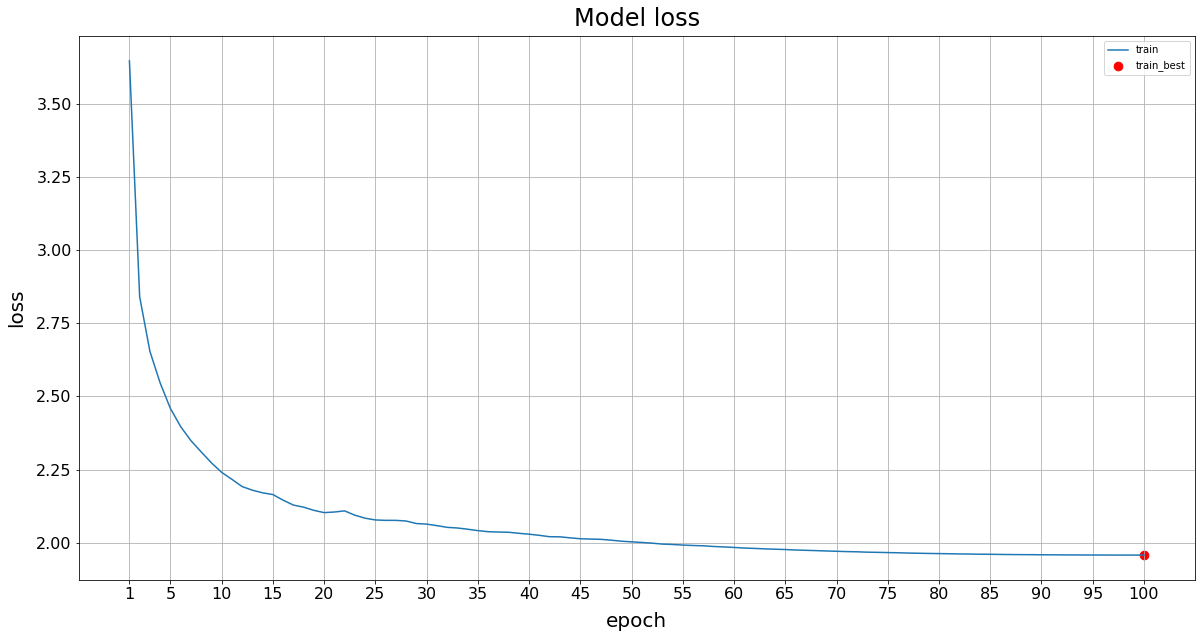

<Figure size 432x288 with 0 Axes>

In [94]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

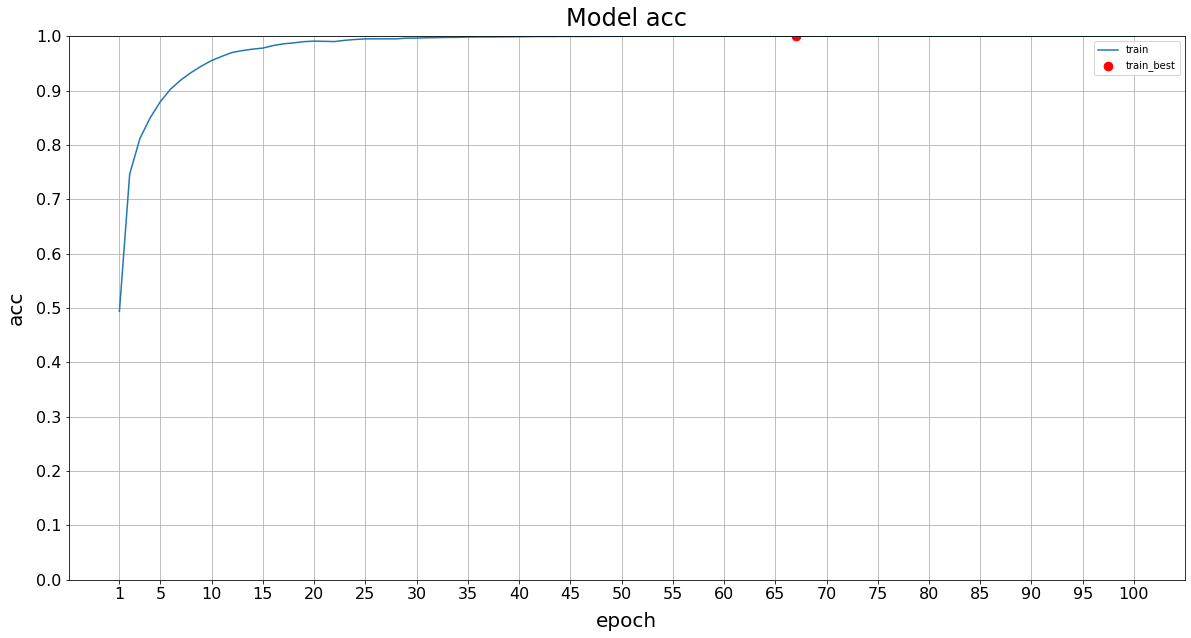

<Figure size 432x288 with 0 Axes>

In [95]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

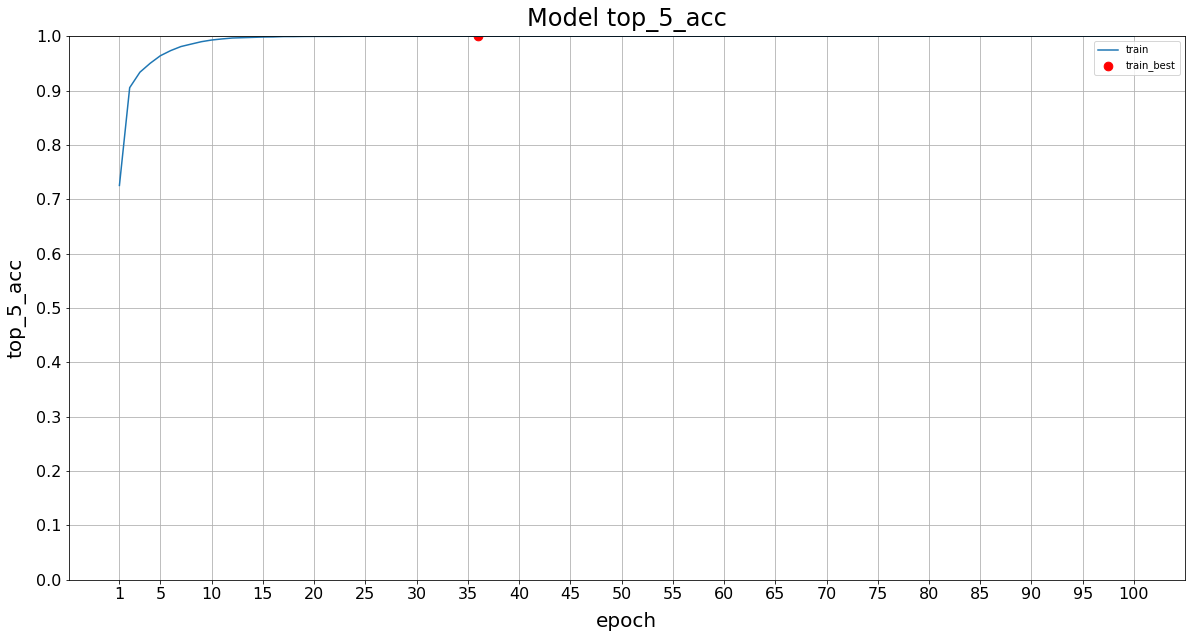

<Figure size 432x288 with 0 Axes>

In [96]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

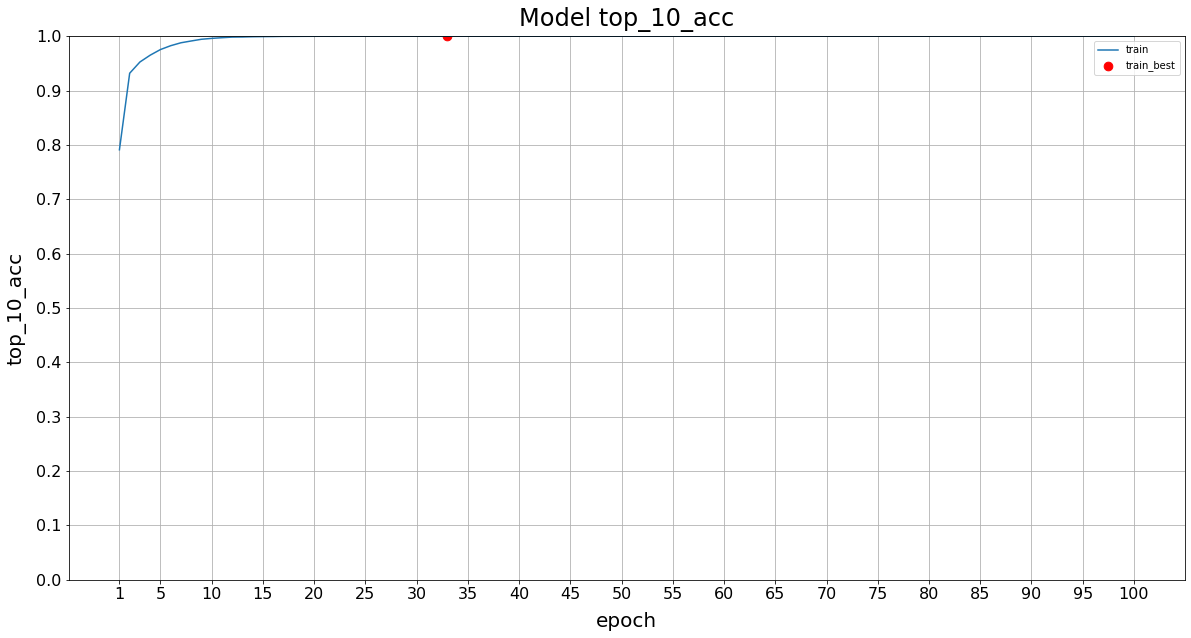

<Figure size 432x288 with 0 Axes>

In [97]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [98]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# # Sanity Check
# demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
# logger.info(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
# demo_output = tflite_keras_model(demo_raw_data)["outputs"]
# logger.info(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
# demo_prediction = demo_output.numpy().argmax()
# logger.info(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [99]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open(out_root + '/model.tflite', 'wb') as f:
    f.write(tflite_model)
    

INFO:tensorflow:Assets written to: /tmp/tmpz8lwafhy/assets


2023-05-01 12:47:33.231540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-01 12:47:33.231592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-01 12:47:33.232736: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz8lwafhy
2023-05-01 12:47:33.321932: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-01 12:47:33.321974: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz8lwafhy
2023-05-01 12:47:33.625404: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-01 12:47:33.731663: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-01 12:47:35.090144: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz8lwafhy
2023-05

In [100]:
# Zip Model
!zip $out_root/submission.zip $out_root/model.tflite

  adding: models/training_exp23_aug_largemodel_input32_block2_20230501_2017_alldata//model.tflite (deflated 8%)


In [101]:
# # Verify TFLite model can be loaded and used for prediction
# !pip install tflite-runtime
# import tflite_runtime.interpreter as tflite

# interpreter = tflite.Interpreter(out_root + "/model.tflite")
# found_signatures = list(interpreter.get_signature_list().keys())
# prediction_fn = interpreter.get_signature_runner("serving_default")

# output = prediction_fn(inputs=demo_raw_data)
# sign = output['outputs'].argmax()

# print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
# print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

In [102]:
import shutil
shutil.move(out_root ,out_root.replace("training_", "done_"))

'./models/done_exp23_aug_largemodel_input32_block2_20230501_2017_alldata/'